<h1>E-commerce — Выявление профилей потребления</h1>

<h2>Краткое описание проекта</h2>

Интернет-магазин товаров для дома «Пока все ещё тут» в срочном порядке ищет аналитиков. Необходимо помочь нашему магазину стать лучше, 
а клиентам — обустроить дом своей мечты. Наши ближайшие задачи — расчёт метрик и создание гипотез на основе полученных данных.

<h2>Цель проекта</h2>

Расчёт метрик и создание гипотез на основе полученных данных

<h2>Разбивка задачи проекта на шаги</h2>

<h3>Загрузка данных</h3>

<h3>Предобработка данных</h3>

* анализ статистических характеристик;
* обработка пропусков и дубликатов;
* проверка на корректность типов данных колонок датасета;
* поиск выбросов;
* проверка на аномалии;
* выводы.

<h3>Исследовательский анализ данных</h3>

* формирование списка товарных категорий;
* определение процента выручки по каждой сформированной категории к общей выручке;
* определение процента количества проданных товаров по каждой сформированной категории к общему количеству проданных товаров;
* определение количества заказов на одного покупателя;
* распределение заказов по месяцам для определения сезонности в продаже товаров;
* распределение заказов по дням недели для определения есть ли пиковые дни продаж;
* выводы.

<h3>Выделение сегментов покупателей на основе истории их покупок для разработки персонализированных предложений</h3>

* сегментация по категориям товаров;
* сегментация по среднему чеку;
* определение сезонности продаж на основе сформированных категорий товаров и сегментов покупателей;
* определение 3 лучших категорий товаров по числу заказов на основе сформированных категориях товаров и сегментов покупателей;
* определение 3 лучших категорий товаров по общей стоимости на основе сформированных категориях товаров и сегментов покупателей;
* выводы.

<h3>Проверка статистических гипотез</h3>

* определение статистической значимости различий в среднем чеке между сегментами пользователей категорий Товара для ремонта и Товары для хранения;
* определение статистической значимости различий в среднем чеке между сегментами пользователей категорий Товара для ремонта и Товары для кухни;
* выводы.

<h3>Общие выводы</h3>

Ссылка на презентацию: https://disk.yandex.ru/i/zc90zNwHZpy9OQ

<h2>Загрузка данных</h2>

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams, rcParamsDefault
from math import factorial
from scipy import stats as st
import numpy as np
import seaborn as sns; sns.set()
import plotly.express as px
from plotly.offline import iplot
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

Сформируем датасет

In [2]:
online_shop = pd.read_csv('ecom_dataset_upd.csv')

In [3]:
online_shop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


Видим что в датасете 7474 записей. Пропусков не наблюдается. Названия столбцов корректны.

<h2>Предобработка данных</h2>

Для начала приведём значения столбца с покупками к нижнему регистру.

In [4]:
online_shop['product'] = online_shop['product'].str.lower()

In [5]:
online_shop.head(5)

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0


Наблюдаем несоответствие типа данных в столбце date. Произведём замену

In [6]:
online_shop['date'] = pd.to_datetime(online_shop['date'], format='%Y%m%d', exact=False)

Проверим наличие пропусков в данных

In [7]:
online_shop.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

Проверим датасет на явные дубликаты и удалим их если они есть.

In [8]:
online_shop.duplicated().sum()

966

In [9]:
online_shop = online_shop.drop_duplicates()

Теперь проверим датасет на скрытые дубликаты. Позиции, которые имеют разные даты, но повторяющиеся значения для остальных столбцов.

In [10]:
online_shop[['customer_id', 'order_id', 'product']].duplicated().sum()

920

Видим что присутствуют заказы и товары для одних и тех же покупателей в разные даты. Возможно это может быть связано с периодическим отслеживанием статуса заказа. Оставим только первые записи по таким задублированным заказам

In [11]:
online_shop.drop_duplicates(subset=['customer_id', 'order_id', 'product'], keep='first', inplace=True)

Каждому заказу может соответствовать только один покупатель. Проверим так ли это.

In [12]:
order_to_customer = online_shop.groupby('order_id')['customer_id'].nunique().sort_values(ascending=False).reset_index()

In [13]:
order_to_customer.head(5)

,order_id,customer_id
0,72845,4
1,71480,3
2,69485,3
3,69410,2
4,71226,2


Видим что в датасете присутствуют заказы по нескольким покупателям. Оставим только те заказы за которым только один покупатель.

In [14]:
order_to_customer_filter = order_to_customer.loc[order_to_customer['customer_id'] > 1]

In [15]:
order_to_customer_filter = list(order_to_customer_filter['order_id'])

In [16]:
online_shop = online_shop[online_shop['order_id'].isin(order_to_customer_filter)==False].reset_index(drop=True)

Проверим наличие выбросов в датасете. Сначала проверим наличие выбросов в количестве товара

In [17]:
online_shop['quantity'].describe()

count    5522.000000
mean        2.577508
std        16.506591
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1000.000000
Name: quantity, dtype: float64

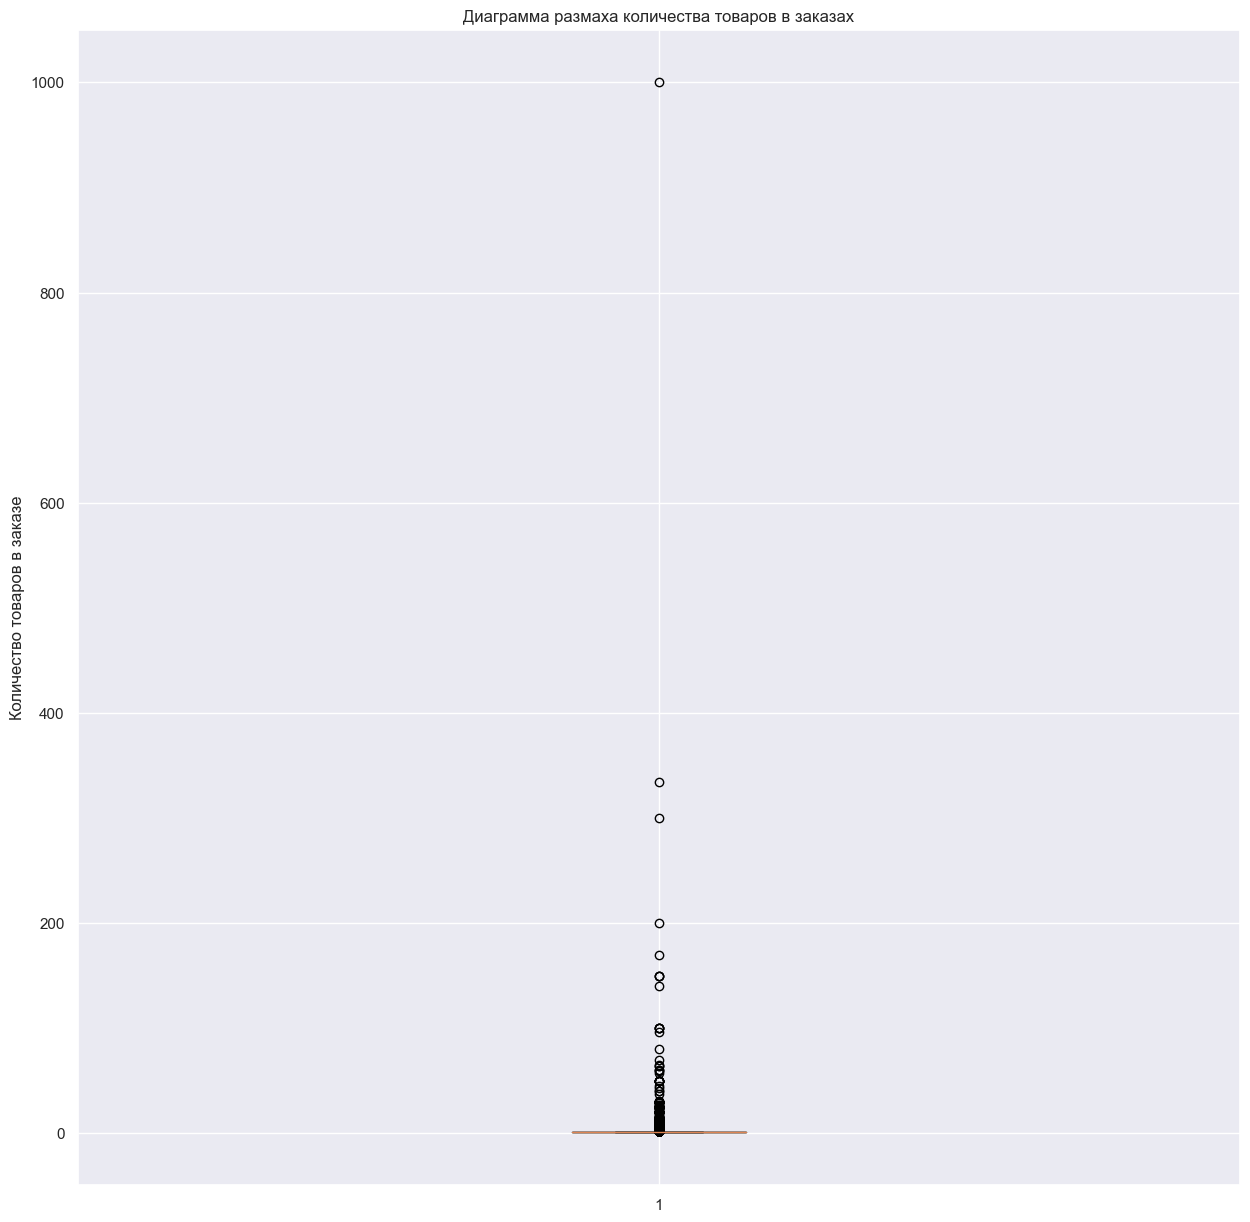

In [18]:
plt.figure(figsize=(15, 15))
plt.boxplot(online_shop['quantity'])
plt.title("Диаграмма размаха количества товаров в заказах")
plt.ylabel("Количество товаров в заказе")
plt.show()

Видим что большинство заказов с количеством товара до определённого значения около 70 распределено равномерно. После 70 ззначения встречаются гораздо реже. Изучим, что за товары продаются свыше 70 шт.

In [19]:
online_shop.query('quantity > 70')['product'].unique()

array(['крючок одежный 2-х рожковый серый металлик с полимерным покрытием *тонар*, 1110027',
       'крепеж для пружины дверной, 1107055',
       'пружина дверная 240 мм оцинкованная (д-19 мм) без крепления, 1107014',
       'муляж яблоко 9 см красное',
       'щетка для посуды *оля*, мультипласт 1807010',
       'ручка-скоба рс-100 белая *трибатрон*, 1108035',
       'щетка для мытья посуды колибри м5202 большая',
       'плечики пластмассовые размер 52 - 54 тула 1205158',
       'вешалки мягкие для деликатных вещей 3 шт шоколад',
       'вантуз с деревянной ручкой d14 см красный, burstenmann, 0522/0000',
       'универсальный нож webber из нержавеющей стали русские мотивы 12,7 см с деревянной ручкой ве-2252d',
       'крепеж для пружины дверной оцинкованный, 1107054',
       'шпингалет 80 мм белый с пружиной, 1102188'], dtype=object)

Видим что большинство из нуменклатуры товаров, число которых в одном заказе больше 70 - это товары, которые в таком количестве применимы в коммерческой деятельности.
У нас же стоит промежуточная задача - сигментация покупателей что подразумевает то что покупатели - физические лица. Удалим заказы, где количеств товаров больше 70 из датасета.

In [20]:
online_shop_filter = online_shop.query('quantity <= 70').reset_index(drop=True)

Теперь проверим наличие выбросов в цене товара и выручки

In [21]:
online_shop['price'].describe()

count     5522.000000
mean       531.584224
std        975.262577
min          9.000000
25%         90.000000
50%        150.000000
75%        524.000000
max      14917.000000
Name: price, dtype: float64

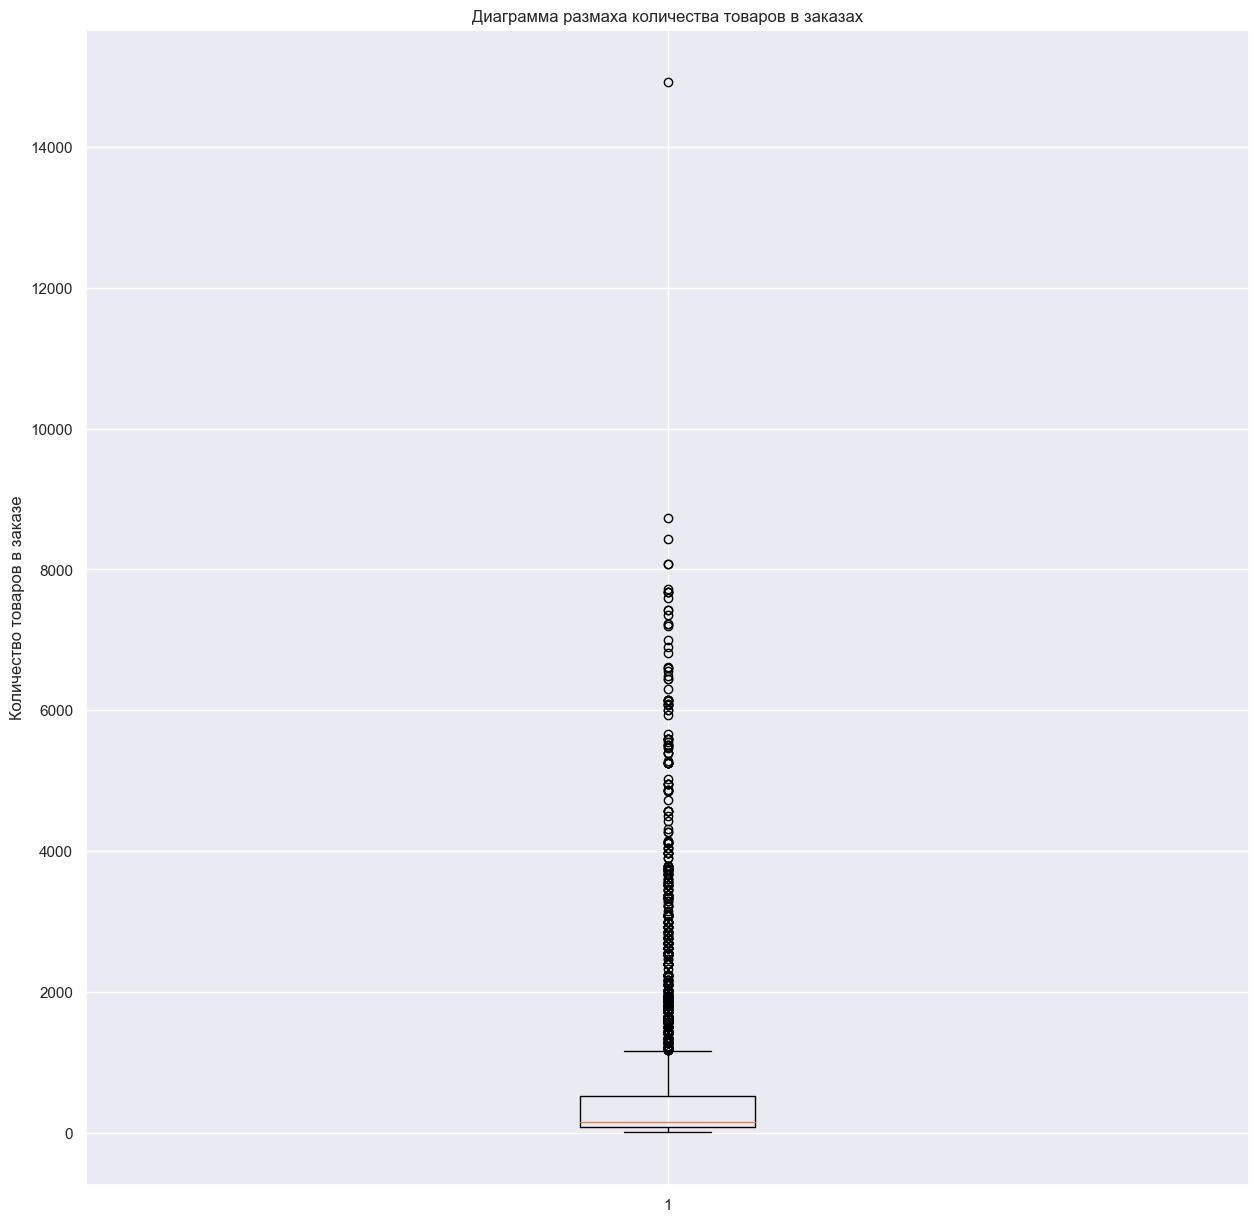

In [22]:
plt.figure(figsize=(15, 15))
plt.boxplot(online_shop['price'])
plt.title("Диаграмма размаха количества товаров в заказах")
plt.ylabel("Количество товаров в заказе")
plt.show()

Видим значительный выброс. Значение более 14000. Изучим, что за товары продаются за цену дороже 10000.

In [23]:
online_shop.query('price > 10000')['product'].unique()

array(['сушилка уличная leifheit 85210 linomatic v 400 40 м 175х237х237 см зеленая'],
      dtype=object)

Цена выглядит вполне реальной.

Также узнаем за какой период мы рассматриваем отфильтрованные данные. В первую очередь интересует необходимо ли в исследовательском анализе учитывать годы или достаточно только месяцев. 

In [24]:
online_shop['date'].min().date()

datetime.date(2018, 10, 1)

In [25]:
online_shop['date'].max().date()

datetime.date(2020, 1, 31)

Видим что рассматриваемые данные за период с 01.10.2018 по 31.01.2020. Соответственно в исследовательском анализе год тоже необходимо учитывать.

<b>Выводы:</b>
* мы отформатировали значения даты в датасете. Значения даты стали понятны;
* были проведены проверки на явные и скрытые (строки с одинаковыми заказами и товарами, но с разными датами, а также строки где нескольким покупателям принадлежит одинаковый заказ) дубликаты. После нахождения таким дубликатов - они были удалены;
* также были проведены проверки на выбросы значений количества товара и цены. На основе эспертного суждения были установлены выбросы в значениях количества товара. Далее данные выбросы были удалены;
* был установлен рассматриваемый период анализа. А именно с 01.10.2018 по 31.01.2020.

<h2>Исследовательский анализ данных</h2>

Для начала разделим товары на категории:

In [26]:
garden = ['цветок', 'рассада', 'среднеспелый', 'томат', 'помидор', 'диам', 'пеларгония', 'розовый'
          , 'зелень', 'роза', 'среднеспелый', 'муляж', 'однолетний', 'пластиковый', 'петуния', 'раннеспелый'
          , 'растение', 'огурец', 'герань', 'тимьян', 'цикламен', 'калибрахоа', 'флокс', 'тыква', 'клубника'
          , 'петрушка', 'фиалка', 'бегония', 'трава', 'флокс', 'перец', 'душица', 'комнатн', 'фуксия', 'капуста'
          , 'дыня', 'хлорофитум', 'хризантема', 'зверобой', 'кореопсис', 'цветущее', 'лавр', 'ель', 'антуриум', 'укроп'
          , 'осина', 'бадан', 'антинакипин', 'радермахер', 'хризолидокарпус', 'юкка', 'суккулент'
          , 'цинерария', 'диффенбахий', 'эхинокактус', 'гипсофил', 'ранункулус', 'эхинацея', 'мускарь'
          , 'горох', 'эхинокактус', 'табак', 'петрушка', 'шеффлер', 'многолетний', 'алиссум', 'бальзам', 'настурция'
          , 'адиантум', 'кампануть', 'нолина', 'глоксиния', 'иссоп', 'сантолина', 'мелисса'
          , 'космея', 'бархатцы', 'монарда', 'гортензия', 'диффенбахий', 'цинерария', 'шалфей', 'валериана', 'бадан'
          , 'агератум', 'аргирантерум', 'вероника', 'целозия', 'сальвия', 'фатсия', 'хоста', 'монард'
          , 'настольный', 'альбук', 'артемизия', 'калоцефалус', 'каллун', 'капсикум', 'соланум'
          , 'бархатцы', 'годеция', 'эшшольция', 'пуансетия', 'кипарисовик', 'фиттоний', 'кодонант'
          , 'калла', 'портулак', 'патиссон', 'эхеверие', 'хризантема', 'лаванда', 'кофе', 'овсянница'
          , 'суккулент', 'драцена', 'морковь', 'годеция', 'эшшольция', 'комнатный', 'аптение', 'настурция', 'цветущий'
          , 'девичий', 'лантан', 'ель', 'фикус', 'лен', 'лапчатка', 'рудбекия', 'цитрофортунелла', 'подсолнечник', 'горшок' 
          , 'тележка', 'черенок', 'автополив', 'циперус', 'дендробиум', 'эхеверия', 'эвкалипт', 'кампанула', 'букет', 'азалия'
          , 'калатея', 'мирт', 'аспарагус', 'молодило', 'гербера', 'розмарин', 'крассула', 'мята', 'каланхое', 'акаулис'
          , 'мимоза', 'гвоздика', 'аптения', 'пуансеттия', 'скиммия', 'фиттония', 'алоэ', 'спатифиллум', 'лиан', 'калатея'
          , 'луковиц', 'эпипремнум', 'гиацинт', 'незабудк', 'земляник', 'декабрист', 'ромашк', 'гиацинт', 'горшк', 'чабер'
          , 'георгина', 'смолевка', 'цинния', 'базилик', 'колокольчик', 'вербейник', 'котовник', 'ясколка', 'афеляндра'
          , 'виола', 'платикодон', 'энотера', 'аптения', 'вербена', 'пеперомия', 'гардения', 'цинния', 'лобелия', 'муррайя'
          , 'муррайя', 'арбуз', 'баклажан', 'джункус', 'седум', 'гайлардия', 'барвинок', 'дихондра', 'аквилег', 'астр'
          , 'солидаго', 'физостегия', 'ясколка', 'лобелия', 'анемона', 'буддлея', 'мединилл', 'импатиенс'
          , 'замиокулькас', 'пуансеттия', 'пахира', 'энотера', 'физостегия', 'гимнокалициум', 'нефролепис', 'бахромчат'
          , 'хамедорея', 'литопс', 'нефролепис']

In [27]:
kitchen = ['термокружка', 'вилка', 'ложк', 'нож', 'кувшин', 'салфет', 'овоще', 'чайник'
           , 'просеиватель', 'кухон', 'банка', 'стакан', 'кастрюля', 'чайный', 'кружка', 'сковород', 'тарелка'
           , 'противень', 'дуршлаг', 'бидон', 'термос', 'рыбочистка', 'толкушка', 'лопатка', 'скатерть', 'ковш'
           , 'холодца', 'выпечк', 'пресс', 'разделочная', 'пьезозажигалка', 'миксер', 'посуды', 'масленка'
           , 'мантоварка', 'картофелемялка', 'миска', 'блюдце', 'хлебница', 'блюдо', 'сахарница'
           , 'терка', 'крышка', 'половник', 'посудомое', 'рассекатель', 'фужеров'
           , 'кексов', 'столовых', 'орехоколка', 'бокал', 'круж', 'сито', 'скалка', 'отделитель', 'соко'
           , 'кондитер', 'пищев', 'сотейник', 'котел', 'тортница', 'электроштопор', 'салатник', 'кухня', 'обеденн', 'cоковыжим'
           , 'luminarc', 'свч', 'венчик']

In [28]:
bathroom = ['ванн', 'дозатор', 'соль', 'зубная', 'полотенц', 'мыльница', 'пена', 'халат', 'держатель', 'фен', 'ерш'
            , 'ёрш', 'мыло']

In [29]:
cleaning = ['корыто', 'щетка', 'щётка', 'веник', 'ведро', 'микрофибр', 'швабра', 'налета'
            , 'прищеп', 'подрукавник', 'глажения', 'досок', 'корзина', 'насадка', 'ролика', 'мытья'
            , 'губка', 'подкладка', 'перчатки', 'тряпкодержатель', 'окномойка', 'отжим', 'стирки'
            , 'отбеливатель', 'совок', 'засоров', 'стиральн', 'пластмассов', 'сметка', 'алюминиев', 'чистк'
            , 'чистящ', 'белья', 'мешок', 'известк', 'антижир']

In [30]:
tools = ['болт', 'крючок', 'стремянк', 'фал ', 'шпагат', 'полировки', 'петля', 'скребок', 'пробки', 'крепеж'
               , 'инструмент', 'шнур', 'сварк', 'бензин', 'пружина', 'напильник', 'скоб', 'сверел', 'строительн'
               , 'сверло', 'термометр', 'вентиляц', 'короб', 'линейка', 'угольник', 'уголок', 'фиксатор', 'пылесос'
               , 'лестница', 'штангенциркуль', 'стяж', 'вантуз', 'шпингалет']

In [31]:
storage = ['утюг', 'коробк', 'полка', 'комод', 'фоторамка', 'ключница', 'перекладина', 'модульный', 'этажерка', 'стойка'
           , 'стеллаж', 'нетканый', 'полк', 'моп', 'обувница', 'вешал', 'ящик', 'мебел', 'лоток', 'корзинка', 'гладильн'
           , 'плечики', 'пуф', 'контейнер', 'подставка', 'чехол', 'кофр']

In [32]:
textile = ['подушк', 'штор', 'ковер', 'плед', 'полотен', 'простын', 'покрывал', 'пододеял', 'наматрасник', 'одеял', 'навол'
           , 'постел' , 'ткань', 'халат', 'хлопок']

Распределим товары по категориям:

In [33]:
def to_category(product_name):
    if any(i in product_name.lower() for i in garden):
        return 'товары для сада и дачи'
    elif any(i in product_name.lower() for i in kitchen):
        return 'товары для кухни'
    elif any(i in product_name.lower() for i in bathroom):
        return 'товары для ванной'
    elif any(i in product_name.lower() for i in cleaning):
        return 'товары для уборки'
    elif any(i in product_name.lower() for i in tools):
        return 'товары для ремонта'
    elif any(i in product_name.lower() for i in storage):
        return 'товары для хранения'
    elif any(i in product_name.lower() for i in textile):
        return 'текстиль'
    else:
        return 'другое'

In [34]:
online_shop['category'] = online_shop['product'].apply(to_category)

Определим процент выручки по каждой сформированной категории к общей выручке. Для этого введём новое поле с общей стоимостью позиции.

In [35]:
online_shop['amount'] = online_shop['price'] * online_shop['quantity']

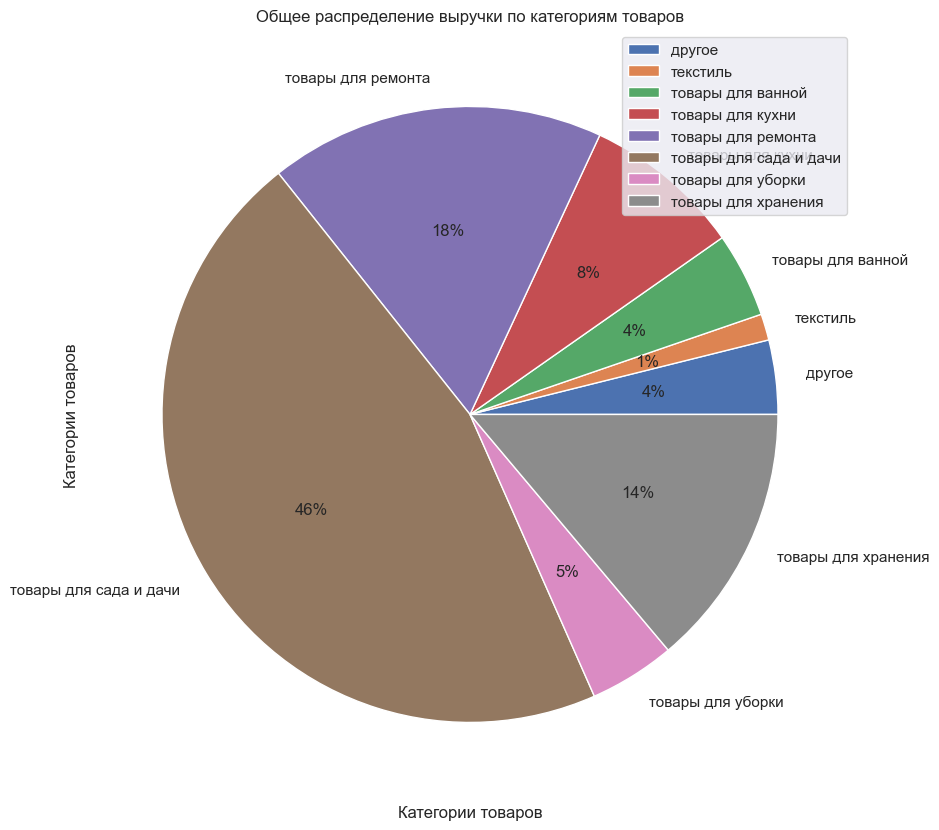

In [36]:
online_shop.pivot_table(index = 'category', values = 'amount', aggfunc = 'sum').plot(kind='pie', figsize=(10,10), autopct = '%1.0f%%',subplots=True)
plt.title("Общее распределение выручки по категориям товаров")
plt.gca().set(xlabel='Категории товаров', ylabel='Категории товаров')
plt.show()

Как видим что наибольшую выручку за рассматриваемый период дали товары из категории "Товары для сада и дачи", затем идут товары из категории "Товары для ремонта" и затем "Товары для хранения". Наименьшую выручку принесли товары из категории "Текстиль".

Теперь определим процент количества проданных товаров по каждой сформированной категории к общему количеству проданных товаров.

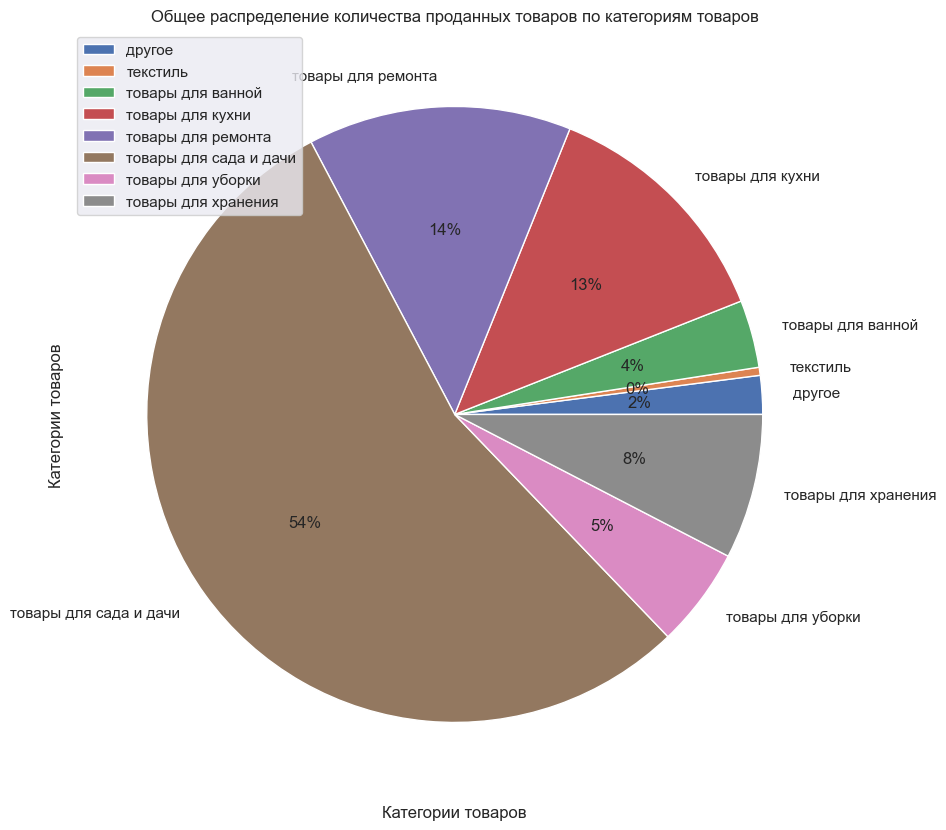

In [37]:
online_shop.pivot_table(index = 'category', values = 'quantity', aggfunc = 'sum').plot(kind='pie', figsize=(10,10), autopct = '%1.0f%%',subplots=True)
plt.title("Общее распределение количества проданных товаров по категориям товаров")
plt.gca().set(xlabel='Категории товаров', ylabel='Категории товаров')
plt.show()

Как видим: за рассматриваемый период наибольшее количество проданных товаров из категории "Товары для сада и дачи", на втором и третьем месте во сравнимыми показателями расположились товары из категорий "Товары для ремонта"  и "Товары для кухни". Наименьшее количество проданных товаров из категории "Текстиль".

Теперь определим число заказов на одного покупателя. Узнаем встречались ли повторные покупки за рассматриваемый период.

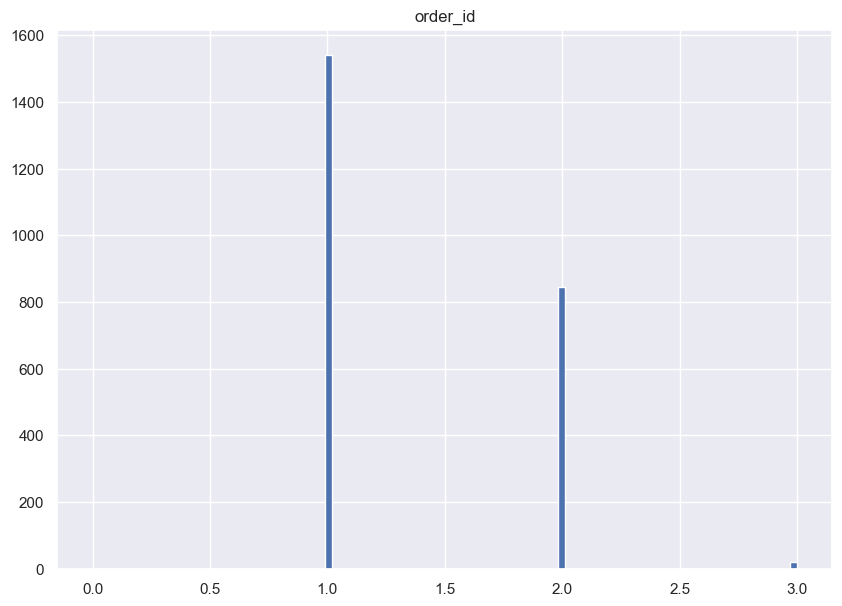

In [38]:
online_shop.groupby('customer_id').agg({'order_id': 'nunique'}).hist(bins=100, range = (0, 3),figsize=(10,7))
plt.show()

Видим что повторную покупку совершают только чуть более половины покупателей. Третью покупку совершает лишь небольшое число покупателей.

Распределим заказы по месяцам для определения сезонности в продаже товаров. Напомним что минимальная дата: 2018-10-01 ,а максимальная дата: 2020-01-31.

Добавим в датасет столбцы: месяц и год

In [39]:
def month_category(month_number):
    if month_number == 1:
        return 'Январь'
    elif month_number == 2:
        return 'Февраль'
    elif month_number == 3:
        return 'Март'
    elif month_number == 4:
        return 'Апрель'
    elif month_number == 5:
        return 'Май'
    elif month_number == 6:
        return 'Июнь'
    elif month_number == 7:
        return 'Июль'
    elif month_number == 8:
        return 'Август'
    elif month_number == 9:
        return 'Сентябрь'
    elif month_number == 10:
        return 'Октябрь'
    elif month_number == 11:
        return 'Ноября'
    elif month_number == 12:
        return 'Декабрь'

In [40]:
online_shop['month'] = pd.DatetimeIndex(online_shop['date']).month

In [41]:
online_shop['month'] = online_shop['month'].apply(month_category)

In [42]:
online_shop['year'] = pd.DatetimeIndex(online_shop['date']).year

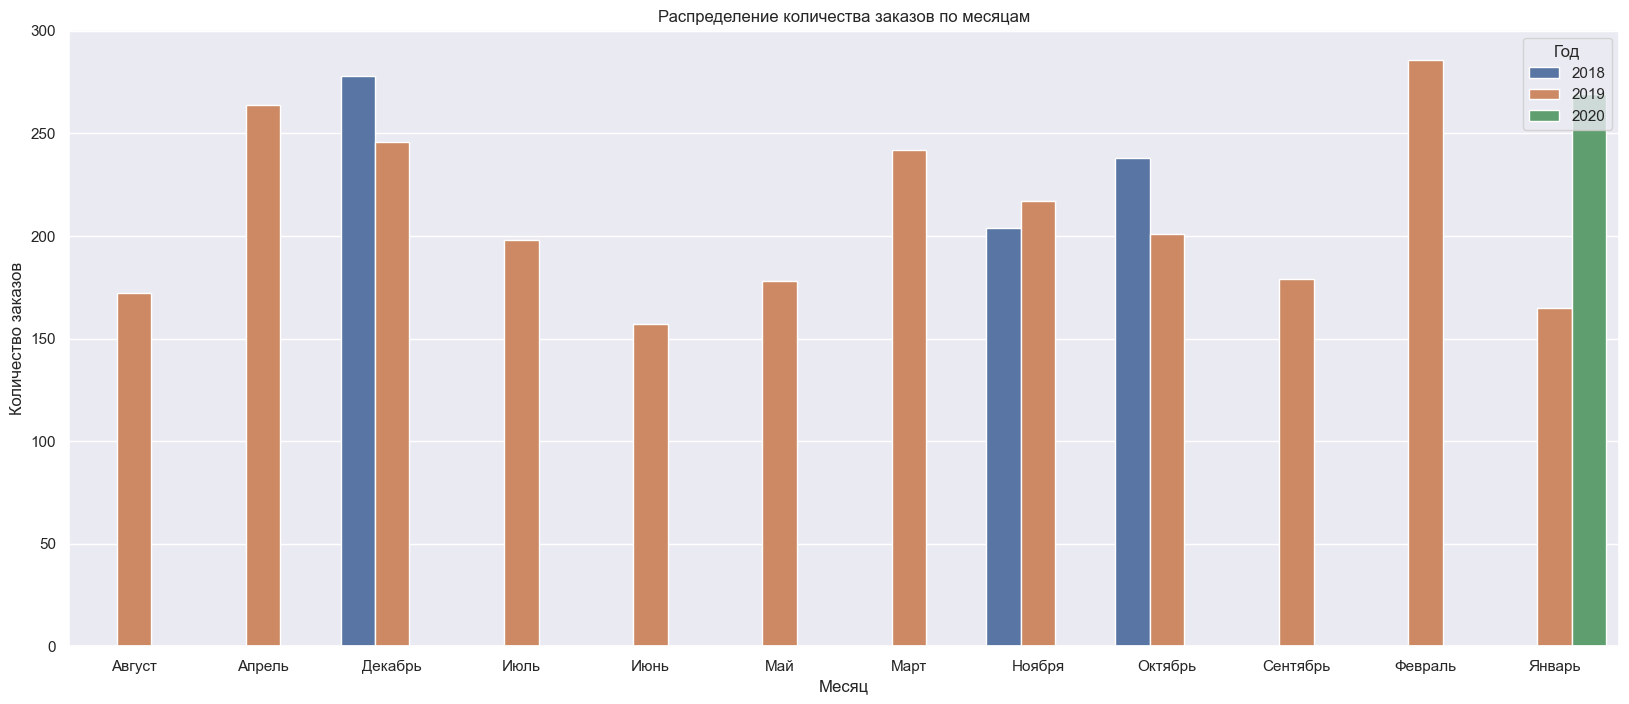

In [43]:
grouped_month = online_shop.groupby(['month', 'year'])['order_id'].nunique().reset_index()
plt.figure(figsize=(20, 8))
sns.barplot(x='month', y='order_id', hue='year', data=grouped_month)
plt.title('Распределение количества заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.legend(title='Год')
plt.show()

Можно сделать вывод что декабрь является стабильно сезонным месяцем. Высокие данные по обоим годам это подтверждают. Это в первую очередь связано подготовкой к Новому Году и большим количеством заказов в связи с этим. Высокий результат по заказам в феврале 2019 года. Несмотря на то что мы располагаем данными только за один год февраль вполне можно назвать сезонным месяцем поскольку в этом месяц совершаются заказы к 23 февраля и 8 марта.

К сожалению из-за невозможности форматирования даты заказов с разбиением на часы в представленном датасете распределить заказы по времени совершения не представляется возможным. Распределим заказы по времени дня недели.

In [44]:
online_shop['day_name'] = online_shop['date'].dt.day_name()

In [45]:
def day_category(day_name):
    if day_name == 'Monday':
        return 'Понедельник'
    elif day_name == 'Tuesday':
        return 'Вторник'
    elif day_name == 'Wednesday':
        return 'Среда'
    elif day_name == 'Thursday':
        return 'Четверг'
    elif day_name == 'Friday':
        return 'Пятница'
    elif day_name == 'Saturday':
        return 'Суббота'
    elif day_name == 'Sunday':
        return 'Воскресенье'  

In [46]:
online_shop['day_name'] = online_shop['day_name'].apply(day_category)

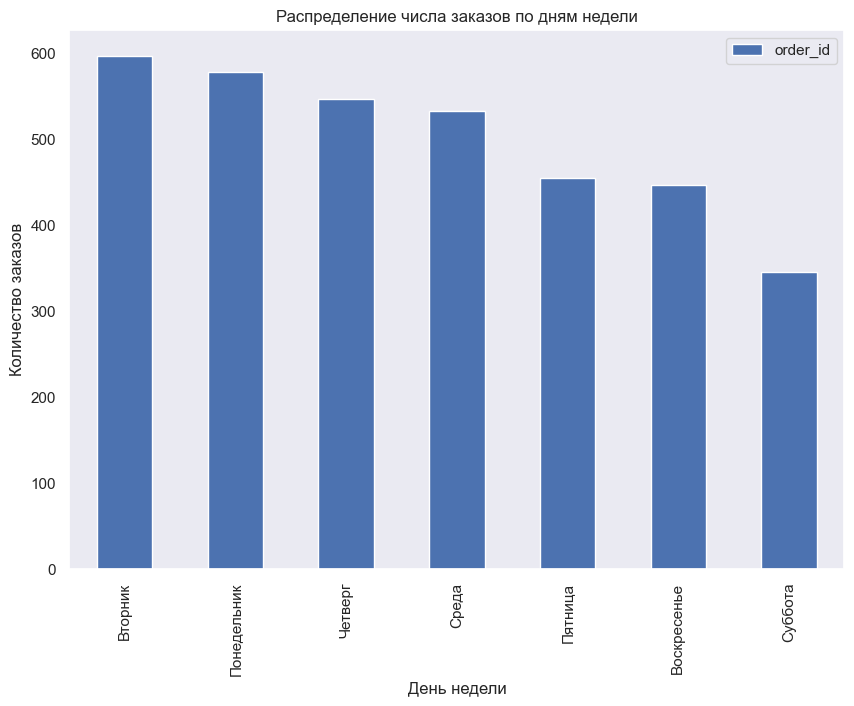

In [47]:
grouped_hour = online_shop.pivot_table(index = 'day_name', values = 'order_id', aggfunc = 'nunique').sort_values(by = 'order_id', ascending = False)
grouped_hour.plot(kind = 'bar', figsize=(10, 7))
plt.title('Распределение числа заказов по дням недели')
plt.ylabel('Количество заказов')
plt.xlabel('День недели')
plt.grid()
plt.show()

Видим что в субботу количество заказов достигает наименьшего значения и в воскресенье заметен подъём.

<b>Выводы:</b>
* на основании представленной нуменклатуры товаров было осуществлено категорирование товарной группы. За образец был взят пример категорирования товарной группы крупнейших сетей строительных гипермаркетов. В результате было выделено 8 категорий: товары для сада и дачи, товары для кухни, товары для ванной, товары для уборки, товары для ремонта, товары для хранения, текстиль, а также категория "другое". Категория "другое" выделена для товаров, которые нельзя отнести в представленные выше категории, а также  вследствие редких продаж данных товаров;
* после анализа суммарной выручки по категориям товаров замечено что наибольшую выручку за рассматриваемый период дали товары из категории "Товары для сада и дачи", затем идут товары из категории "Товары для ремонта" и затем "Товары для хранения". Наименьшую выручку принесли товары из категории "Текстиль";
* после анализа суммарного количества проданных товаров по категориям товаров за рассматриваемый период наибольшее количество проданных товаров из категории "Товары для сада и дачи", на втором и третьем месте во сравнимыми показателями расположились товары из категорий "Товары для ремонта"  и "Товары для кухни". Наименьшее количество проданных товаров из категории "Текстиль";
* было выявлено что повторную покупку совершают только чуть более половины покупателей. Третью покупку совершает лишь небольшое число покупателей. Рекомендуется подумать над улучшением сервиса как технического так и клиентского;
* можно сделать вывод что декабрь является стабильно сезонным месяцем. Высокие данные по обоим годам это подтверждают. Это в первую очередь связано подготовкой к Новому Году и большим количеством заказов в связи с этим. Высокий результат по заказам в феврале 2019 года. Несмотря на то что мы располагаем данными только за один год февраль вполне можно назвать сезонным месяцем поскольку в этом месяц совершаются заказы к 23 февраля и 8 марта;
* что касается недельного пика загруженности заказами, то здесь наблюдается значительное уменьшение количества заказов в пятницу. В субботу количество заказов достигает наименьшего значения и в воскресенье заметен подъём. Отделу маркетинга рекомендуется подумать над составлением клиенских программ и акций для пятницы-субботы.

<h2>Выделение сегментов покупателей на основе истории их покупок для разработки персонализированных предложений</h2>

Для начала проанализируем много покупателей сделали несколько заказов.

In [48]:
online_shop.pivot_table(index = 'customer_id', columns = 'category', values = 'order_id', aggfunc = 'nunique').describe()

category,другое,текстиль,товары для ванной,товары для кухни,товары для ремонта,товары для сада и дачи,товары для уборки,товары для хранения
count,117.000000,33.0,178.000000,392.000000,96.000000,1652.000000,167.000000,320.00000
mean,1.094017,1.0,1.123596,1.117347,1.114583,1.289952,1.119760,1.11875
std,0.586969,0.0,0.741357,0.757911,0.662845,1.784602,0.512523,0.92592
min,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
25%,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
50%,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
75%,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
max,7.000000,1.0,9.000000,14.000000,7.000000,69.000000,5.000000,17.00000


Как видим повторные заказы начинаются только после 75%-ого процентиля покупателей. Данная ситуация наблюдается абсолютно по каждой товарной категории. В этой ситуации стоит выделить покупателей с любимой товарной категорией. Поскольку у нас повторные заказы начинаются только после 75%-ого процентиля покупателей будем считать наличие одного и более заказов у покупателя по товарной категории - правом считать эту категорию любимой у покупателя. Также для того чтобы присвоить покупателю любимую категорию товара необходимо чтобы количество совершенных заказов в ней было больше чем по другим категориям. Данная информация понадобится для рассылки покупателю персонализированных предложений.

Выполним сегментацию покупателей по любимым категориям товаров

In [49]:
pivot_table = online_shop.pivot_table(index = 'category', columns = 'customer_id', values = 'order_id', aggfunc = 'nunique')

In [50]:
pivot_table.set_axis(pivot_table.columns.tolist(), axis=1).reset_index()

,category,000d6849-084e-4d9f-ac03-37174eaf60c4,001cee7f-0b29-4716-b202-0042213ab038,00299f34-5385-4d13-9aea-c80b81658e1b,002d4d3a-4a59-406b-86ec-c3314357e498,003bbd39-0000-41ff-b7f9-2ddaec152037,004d24e9-4a6c-4d0e-8727-8391dfd4b43a,005ba170-45e8-42de-93f7-192481ae2659,00bd74b1-2792-47db-a2f1-680a09ac5026,00c0f92a-121a-4883-a78d-2c7b5fe187de,...,feeaebd0-2c7c-4408-a75a-0081d395888f,fef19457-5e7b-4d5d-b031-806041bc251a,ff0c73c3-6b62-4e67-8e12-bb83ed1851d5,ff31d802-dae6-484d-a3dc-c9723f1cb538,ff422162-fc4a-4b65-a0e2-17f5095ea2c6,ff601403-b094-4b86-9ac6-264d725b9277,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,ffb80538-3fda-4351-8ea9-9d2bec58bb07,ffe82299-3f5b-4214-87fe-3d36ecccfac3
0,другое,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,текстиль,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,товары для ванной,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,товары для кухни,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
4,товары для ремонта,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
5,товары для сада и дачи,1.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,2.0,...,1.0,2.0,1.0,NaN,1.0,2.0,NaN,1.0,NaN,1.0
6,товары для уборки,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
7,товары для хранения,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Создадим списки с идентификаторами покупателей, с категорими по которым тот или иной покупатель сделал наибольшее количество заказов и с количеством этих заказов.

In [51]:
customer_id_temp = []
category_temp = []
amount_orders = []
for col_l in list(pivot_table):
    max_indices = [i for i, val in enumerate(pivot_table[col_l]) if val == max(pivot_table[col_l])]
    if len(max_indices) == 1:  
        customer_id_temp.append(col_l)
        category_temp.append(pivot_table[col_l].idxmax())
        amount_orders.append(pivot_table[col_l].max())

Сформируем функцию определения сегмента покупателя по категориям приобретаемых им товаров

In [52]:
def customer_categories(customer_id):
    
    if (customer_id in customer_id_temp) and (amount_orders[customer_id_temp.index(customer_id)] >= 1):
        return 'Любимая категория '+category_temp[customer_id_temp.index(customer_id)]


Зададим сегмент покупателям (тем кто подпадает под получение любимой категории товаров)

In [53]:
online_shop['best_category'] = online_shop['customer_id'].apply(customer_categories)

Сформируем график процентного распределения заказов покупателей по категориям

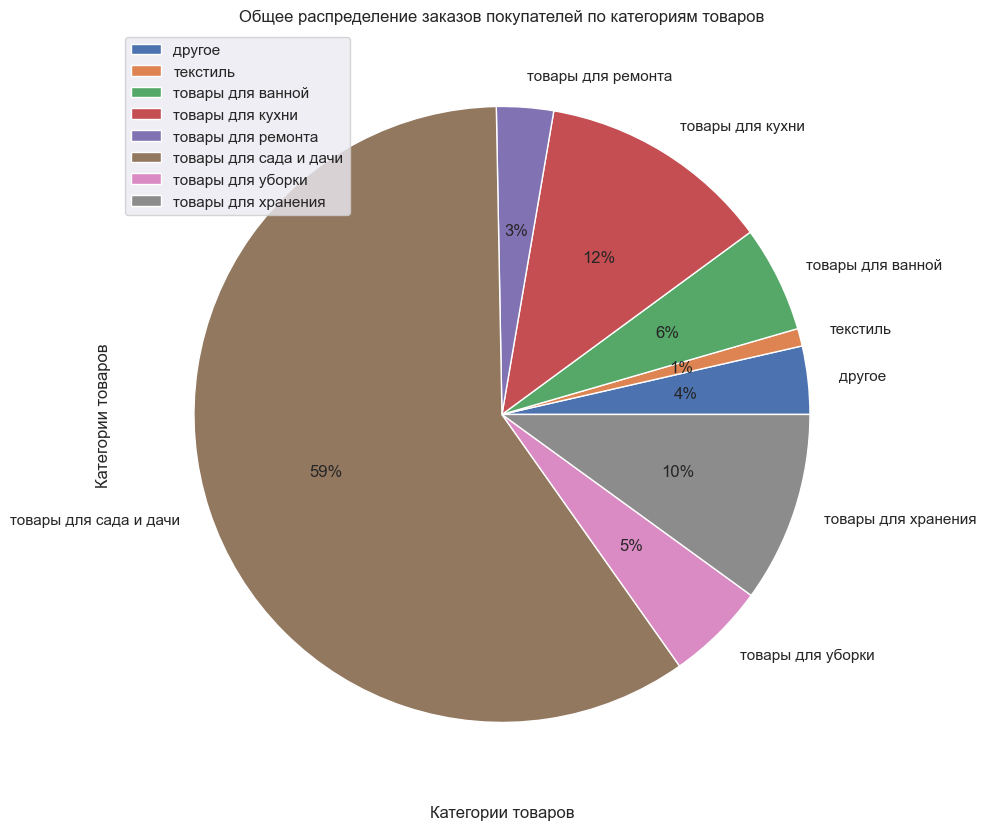

In [54]:
online_shop.pivot_table(index = 'category', values = 'order_id', aggfunc = 'nunique').plot(kind='pie', figsize=(10,10), autopct = '%1.0f%%',subplots=True)
plt.title("Общее распределение заказов покупателей по категориям товаров")
plt.gca().set(xlabel='Категории товаров', ylabel='Категории товаров')
plt.show()

Видим что 59% от всех покупателей магазина приобретали товары в категории "Дача и сад", 12% - в категории "Товары для кухни", 10% - в категории "Товары для хранения". Наименьшее количество (1%) покупателей приобретали товары в категории "Текстиль".

Теперь выполним сегментацию покупателей по среднему чеку

Проанализируем разброс размеров среднего чека по покупателю.

In [55]:
pivot_table_check = online_shop.pivot_table(index = 'customer_id', values = 'amount', aggfunc = 'mean')

In [56]:
pivot_table_check = pivot_table_check.set_axis(pivot_table_check.columns.tolist(), axis=1).reset_index()

In [57]:
pivot_table_check.describe()

,amount
count,2413.000000
mean,1286.128374
std,13854.368623
min,15.000000
25%,200.000000
50%,509.000000
75%,1087.000000
max,675000.000000


Видим что половина покупателей потратили за период анализируемых данных чуть более 500 рублей.

Создадим списки со списками идентификаторов покупателей и общей суммой выручки со всех заказов того или иного покупателя.

In [58]:
customer_id_temp = list(pivot_table_check['customer_id'])

In [59]:
customer_id_amount = list(pivot_table_check['amount'])

Выделим группы доходности.

In [60]:
def revenue_group(customer_id):
    
    if (customer_id in customer_id_temp) and (customer_id_amount[customer_id_temp.index(customer_id)] <= np.quantile(pivot_table_check['amount'], 0.25)):
        return 'низкая доходность'
    elif (customer_id in customer_id_temp) and (customer_id_amount[customer_id_temp.index(customer_id)] <= np.quantile(pivot_table_check['amount'], 0.5)):
        return 'доходность чуть ниже средней'
    elif (customer_id in customer_id_temp) and (customer_id_amount[customer_id_temp.index(customer_id)] <= np.quantile(pivot_table_check['amount'], 0.75)):
        return 'высокая доходность'
    else:
        return 'очень высокая'

In [61]:
online_shop['revenue_group'] = online_shop['customer_id'].apply(revenue_group)

Определим сезонности продаж на основе сформированных категорий товаров и сегментов покупателей по категориям товаров

Для начала определим сезонность продаж по категориям для клиентов, имеющих любимые категории товаров:

In [62]:
list_categories = online_shop['category'].unique()

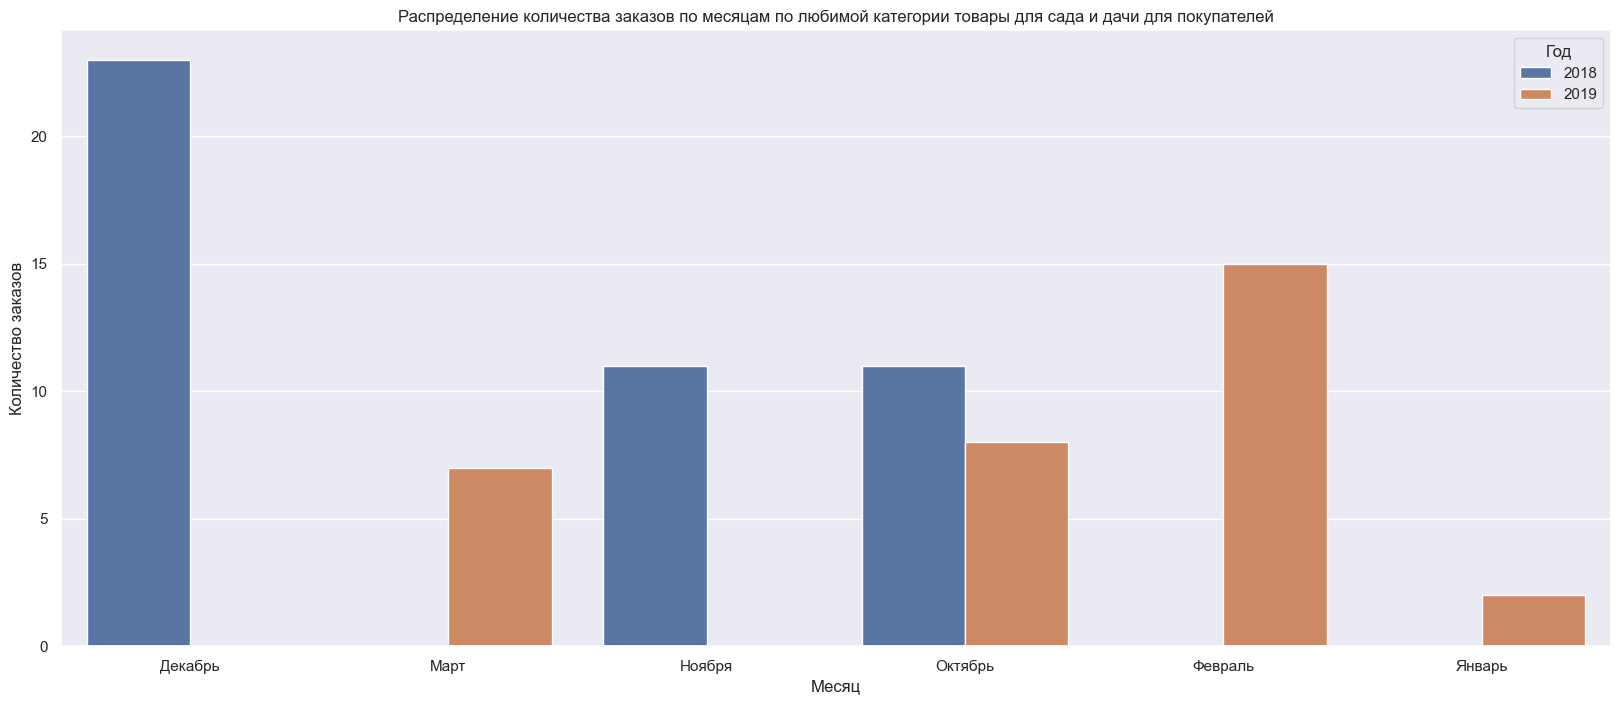

Нет необходимых данных для построения графика по категории товары для уборки
Нет необходимых данных для построения графика по категории товары для хранения
Нет необходимых данных для построения графика по категории товары для ремонта
Нет необходимых данных для построения графика по категории товары для кухни
Нет необходимых данных для построения графика по категории товары для ванной


<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

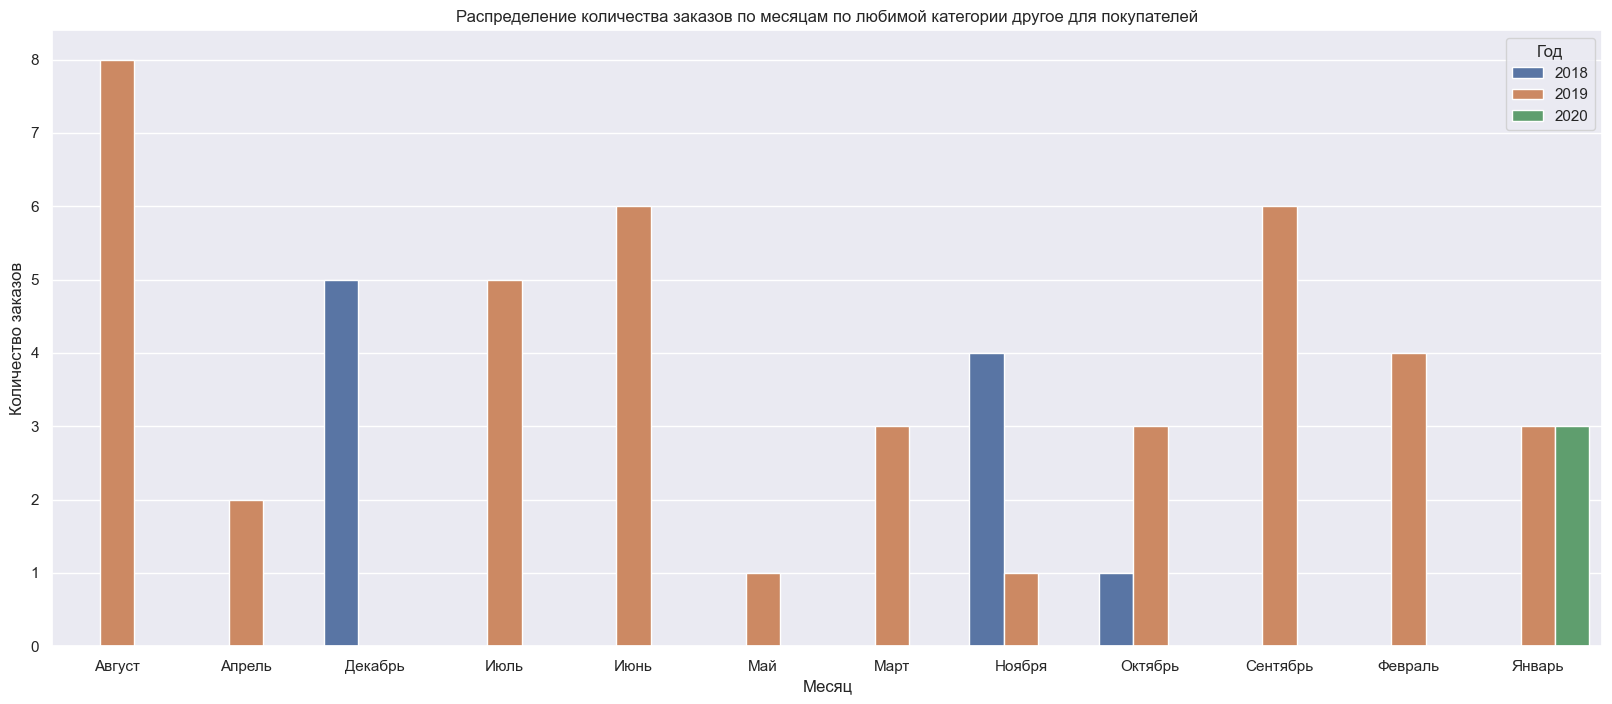

Нет необходимых данных для построения графика по категории текстиль


<Figure size 2000x800 with 0 Axes>

In [63]:
for row in list_categories:
    try:
        seasonality_chart = online_shop.loc[(online_shop['category'] == row) & (online_shop['best_category'].str.contains(r'Любимая категория '+row) == True)].groupby(['month', 'year'])['order_id'].nunique().reset_index()
        plt.figure(figsize=(20, 8))
        sns.barplot(x='month', y='order_id', hue='year', data=seasonality_chart)
        plt.title(f"Распределение количества заказов по месяцам по любимой категории {row} для покупателей")
        plt.xlabel('Месяц')
        plt.ylabel('Количество заказов')
        plt.legend(title='Год')
        plt.show()
    except: print(f"Нет необходимых данных для построения графика по категории {row}")
    

Как видим наиболее сезонным месяцем для покупателей, чаще всего формирующих заказы в категории "Товары для сада и дачи"  является декабрь. Он лидирует с большим отрывом. Это напрямую связано с приближающимися новогодними праздниками. По категории "Другое" наиболее сезонным месяцем для покупателей, чаще всего формирующих заказы в этой категории является август. По остальным категориям данные для анализа отсутствуют.

Теперь определим сезонность продаж по категориям товаров для обычных клиентов:

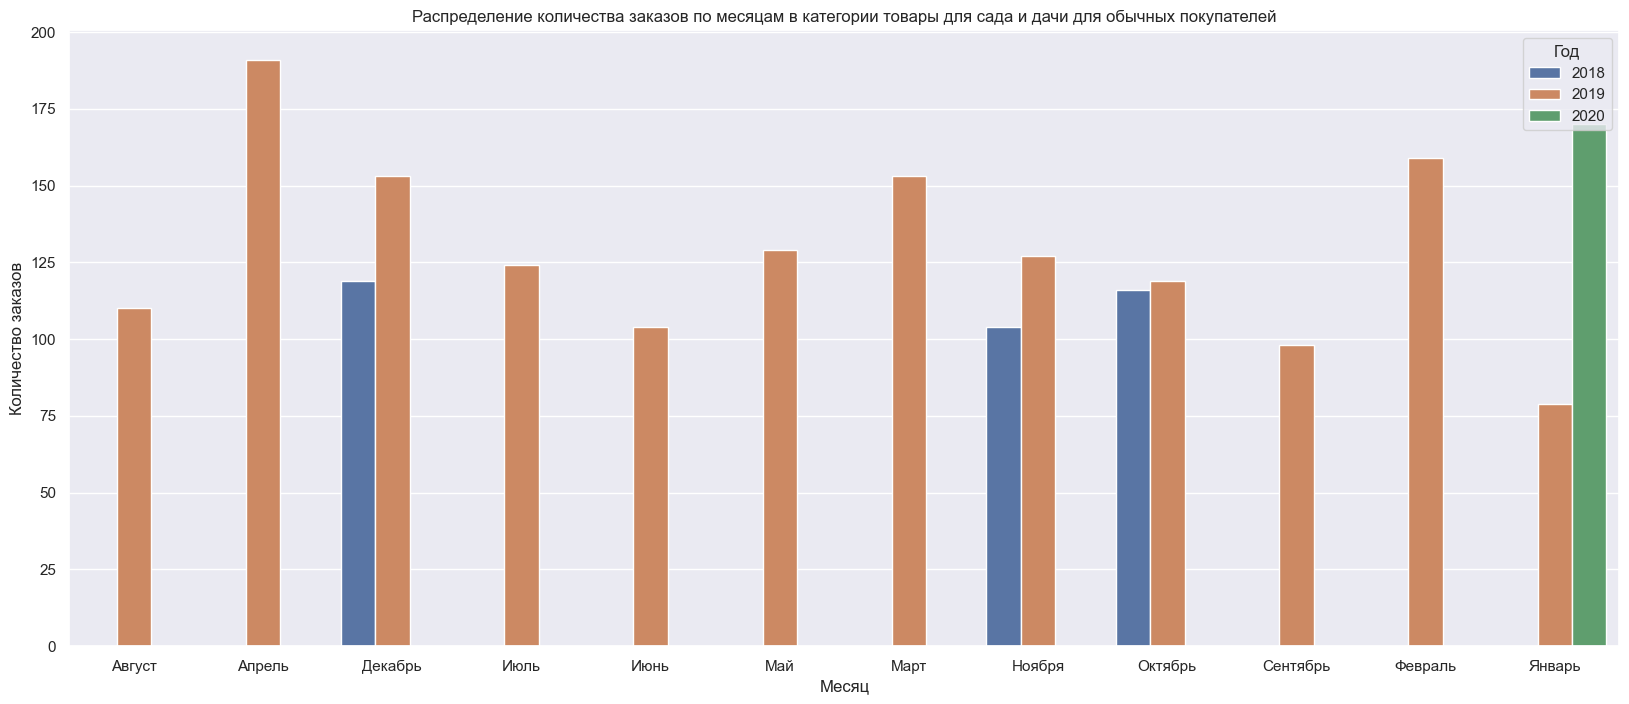

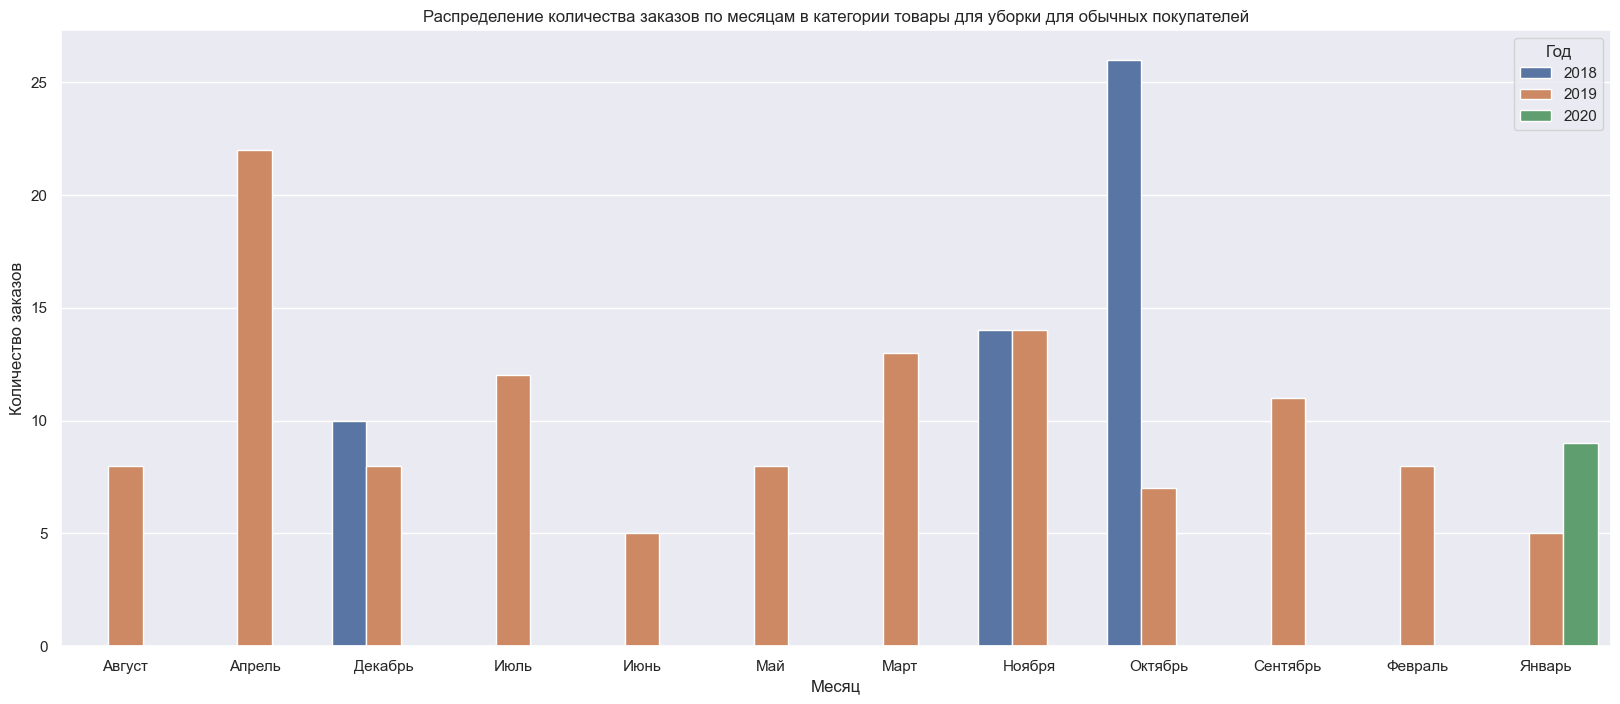

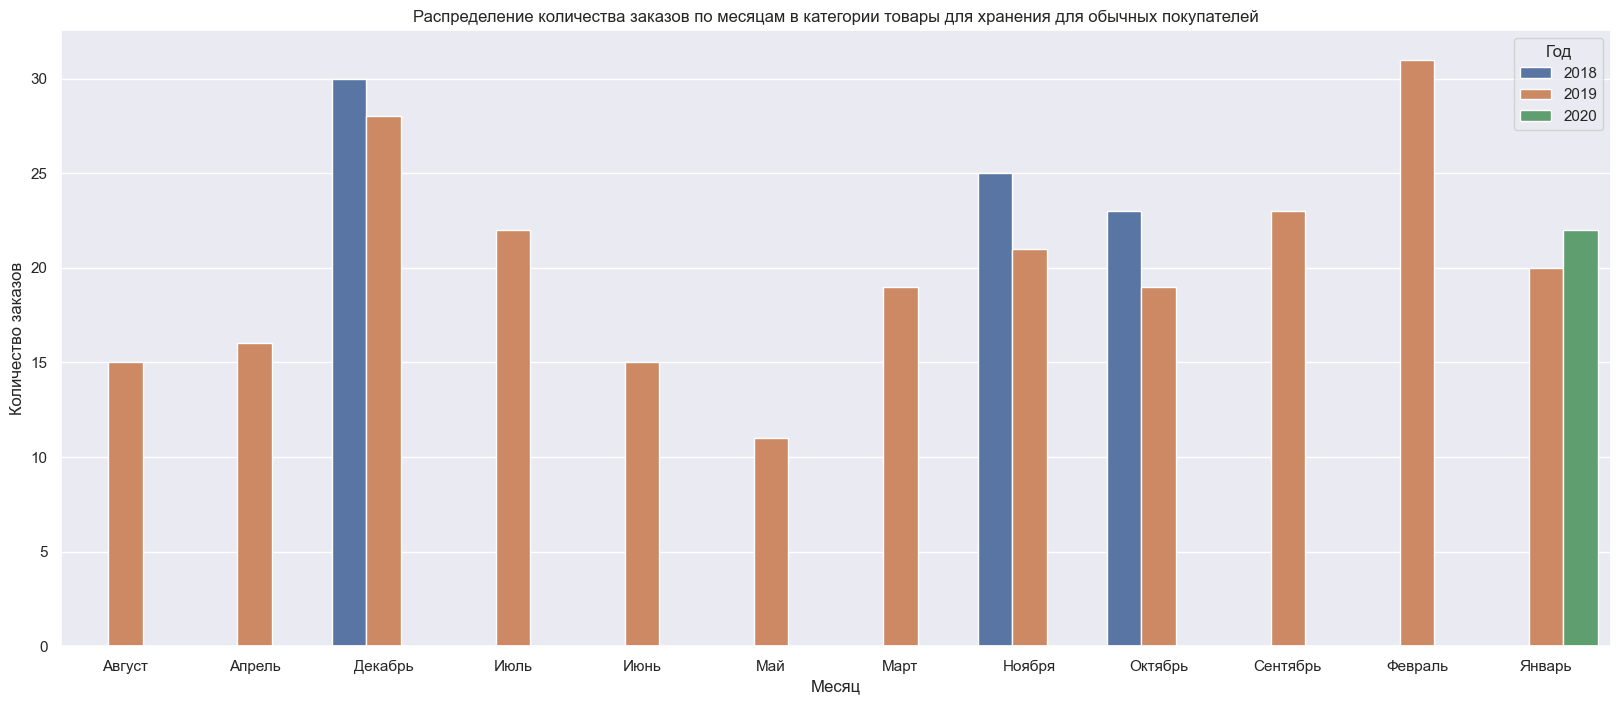

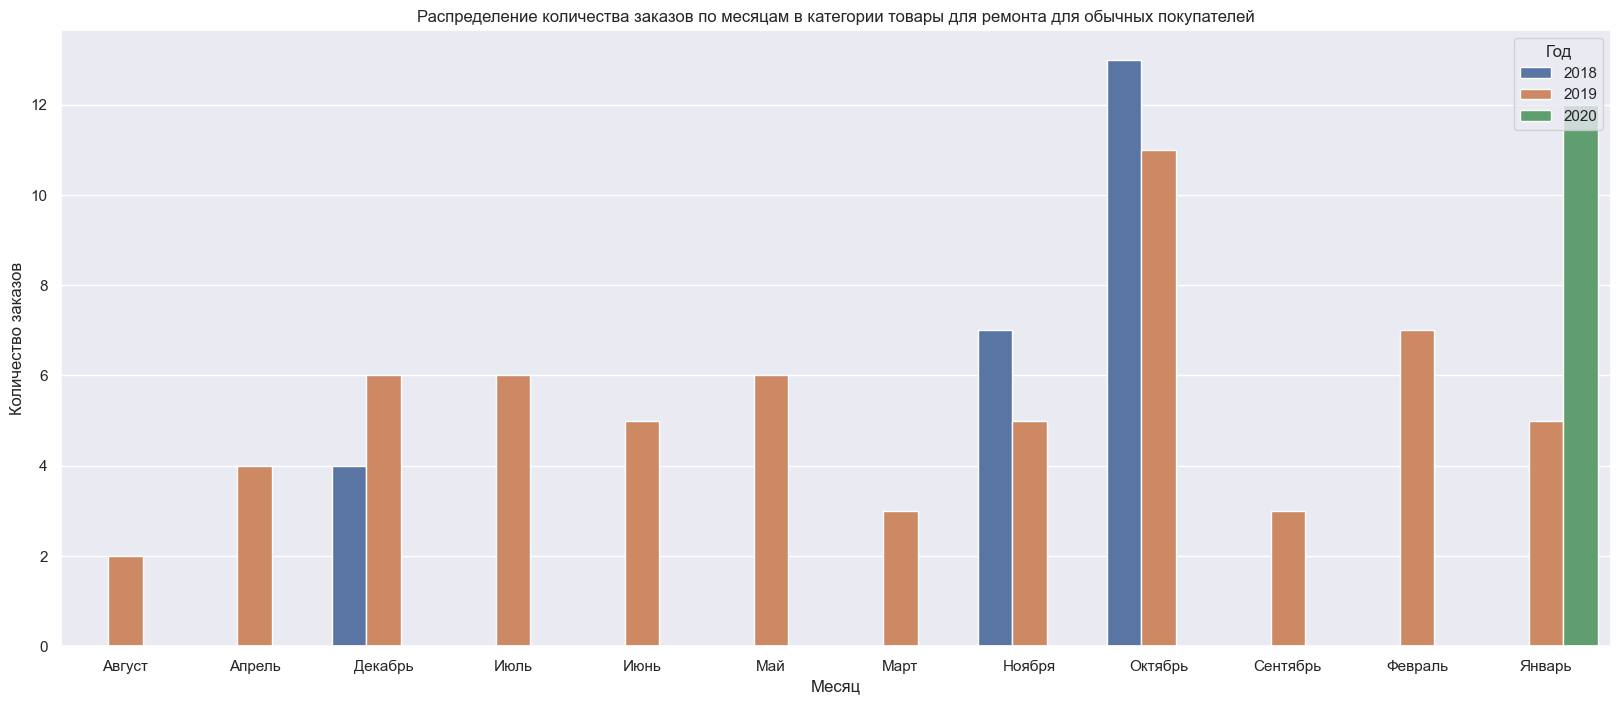

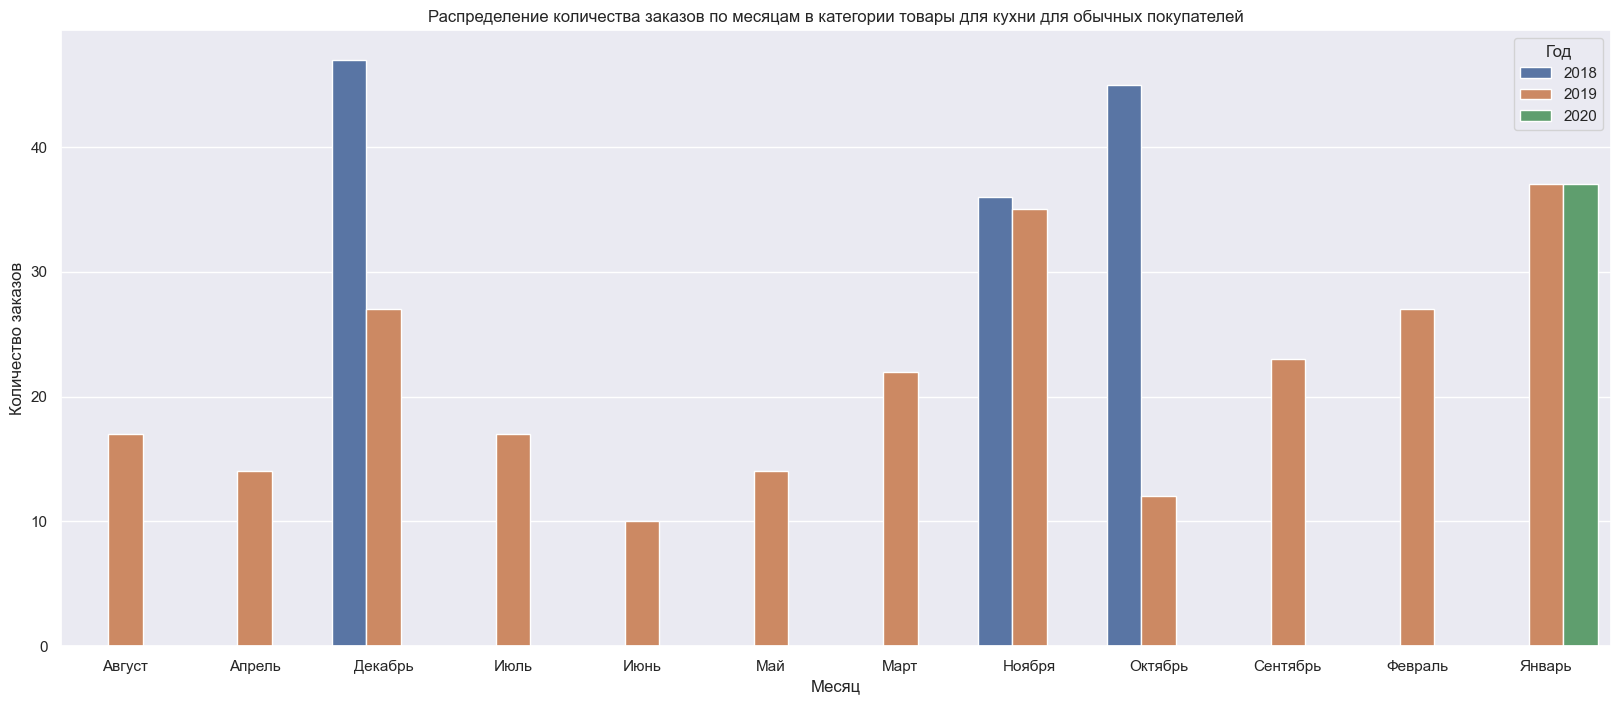

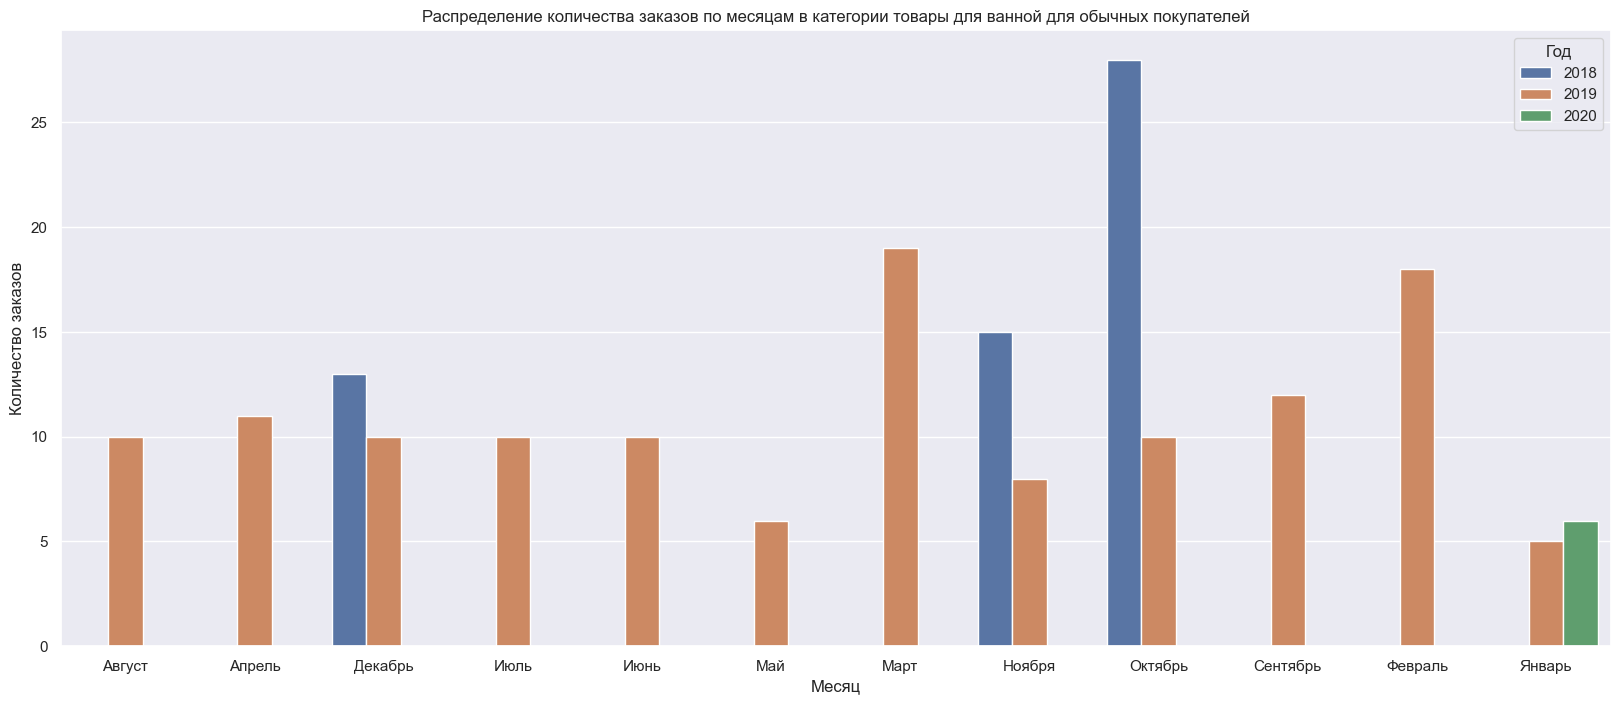

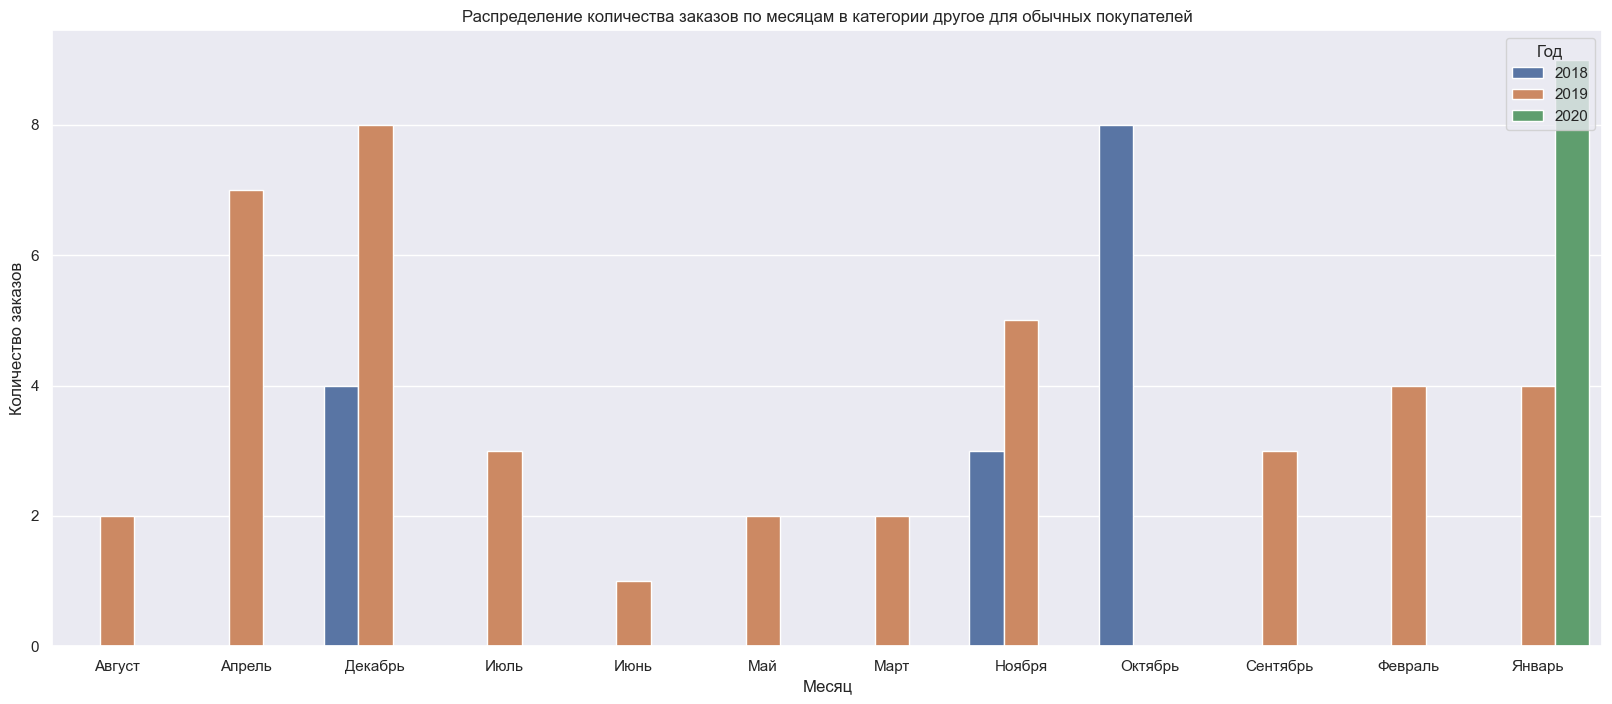

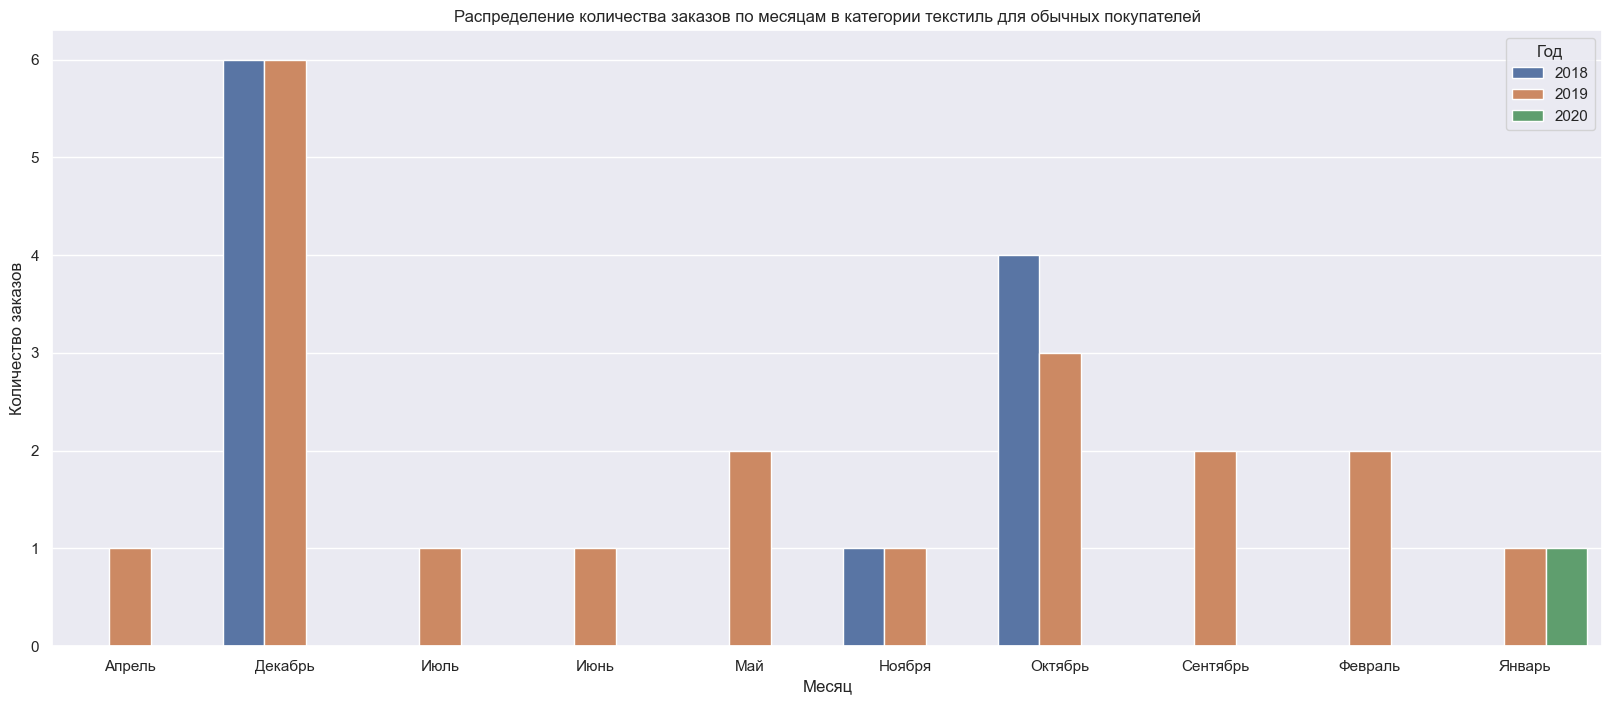

In [64]:
for row in list_categories:
    try:
        seasonality_chart = online_shop.loc[(online_shop['category'] == row) & (online_shop['best_category'].isna() == True)].groupby(['month', 'year'])['order_id'].nunique().reset_index()
        plt.figure(figsize=(20, 8))
        sns.barplot(x='month', y='order_id', hue='year', data=seasonality_chart)
        plt.title(f"Распределение количества заказов по месяцам в категории {row} для обычных покупателей")
        plt.xlabel('Месяц')
        plt.ylabel('Количество заказов')
        plt.legend(title='Год')
        plt.show()
    except: print(f"Нет необходимых данных для построения графика по категории {row}")

Видим что для широкой массы покупателей:
* в категории "товары для уборки" наиболее сезонными месяцами являются ноябрь и октябрь;
* в категории "товары для хранения" - февраль;
* в категории "товары для ремонта" - декабрь;
* в категории "товары для кухни" - октябрь, ноябрь, декабрь;
* в категории "товары для ванной" - декабрь;
* в категории "другое" - декабрь.

Теперь определим сезонность продаж по категориям товаров по сегментам клиентской доходности.

In [65]:
revenue_categories = online_shop['revenue_group'].unique()

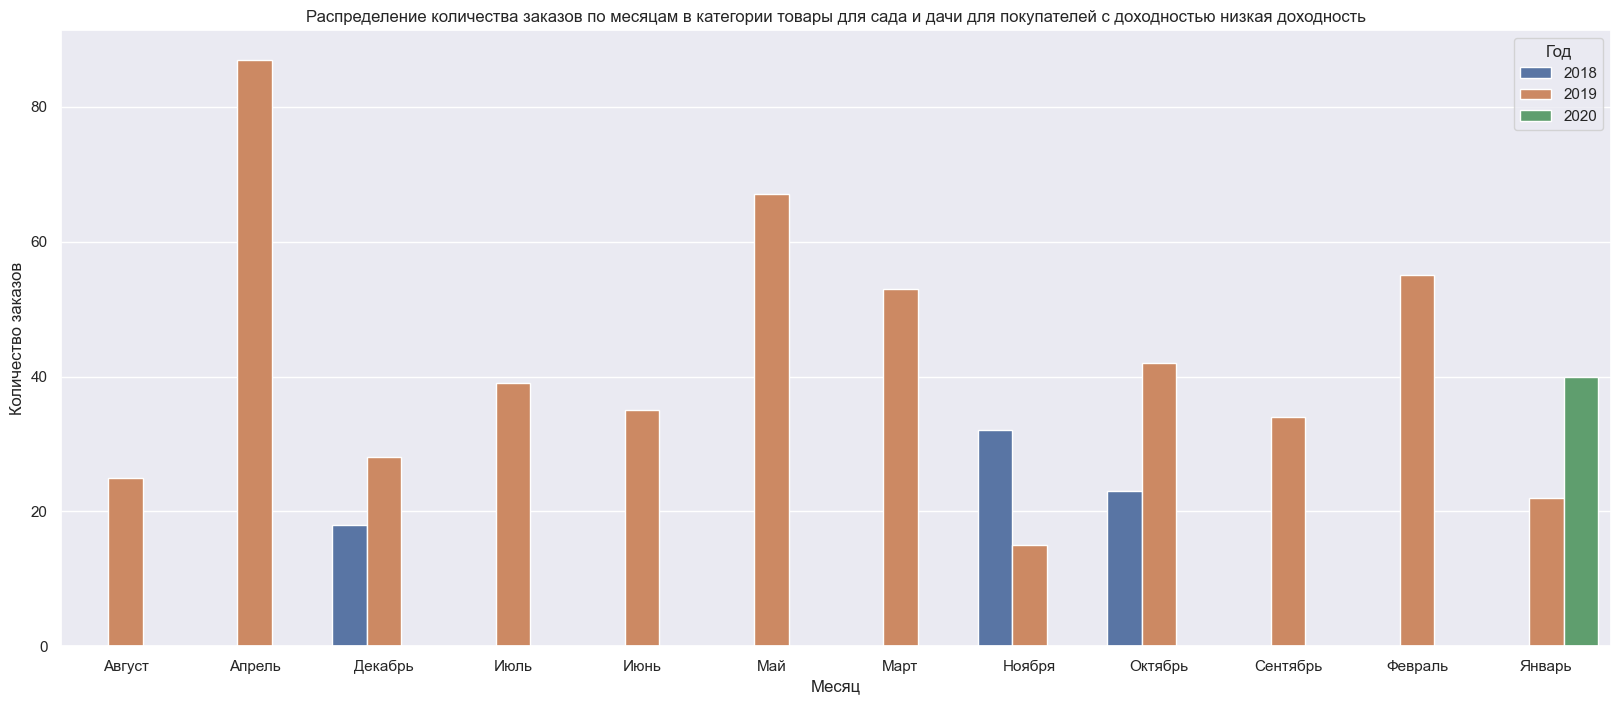

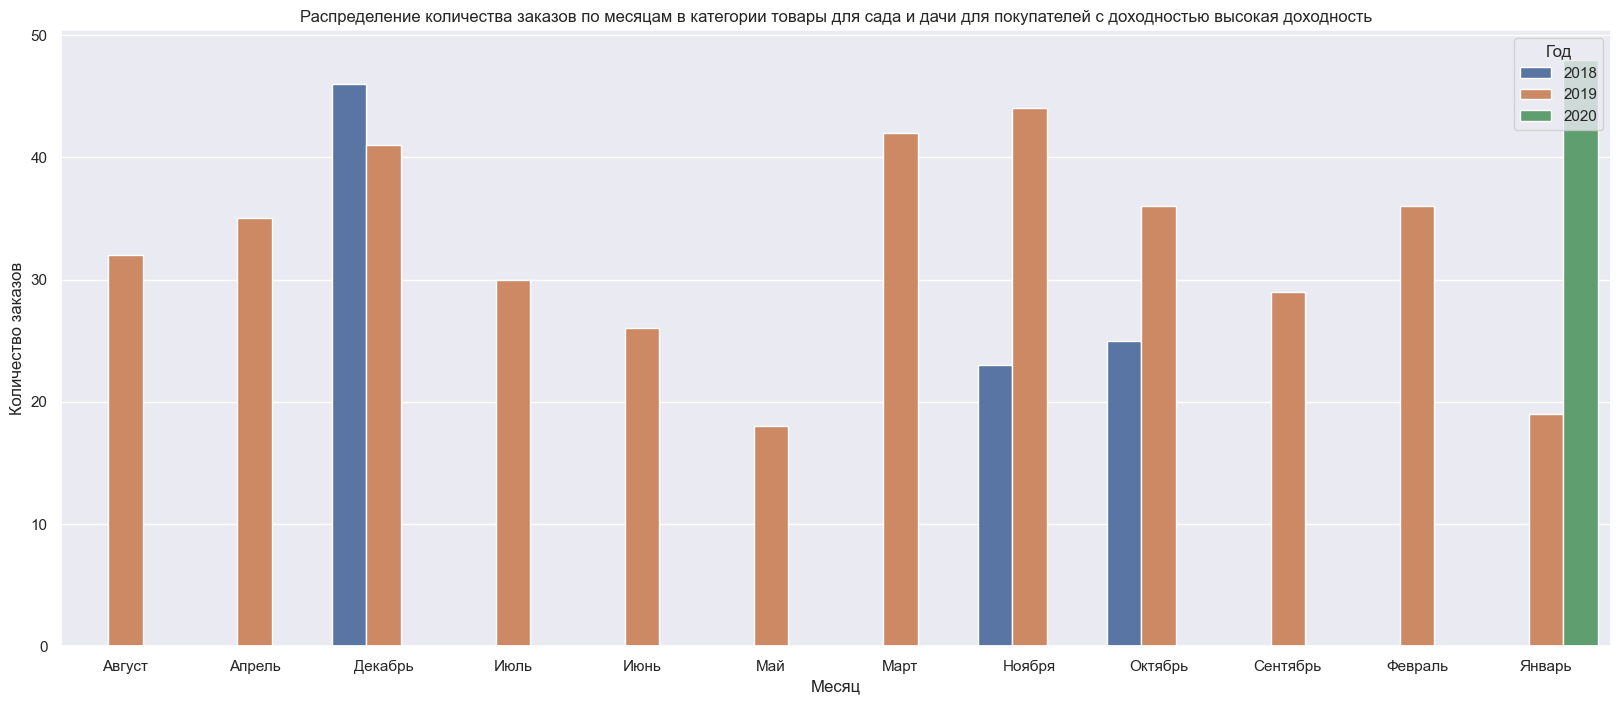

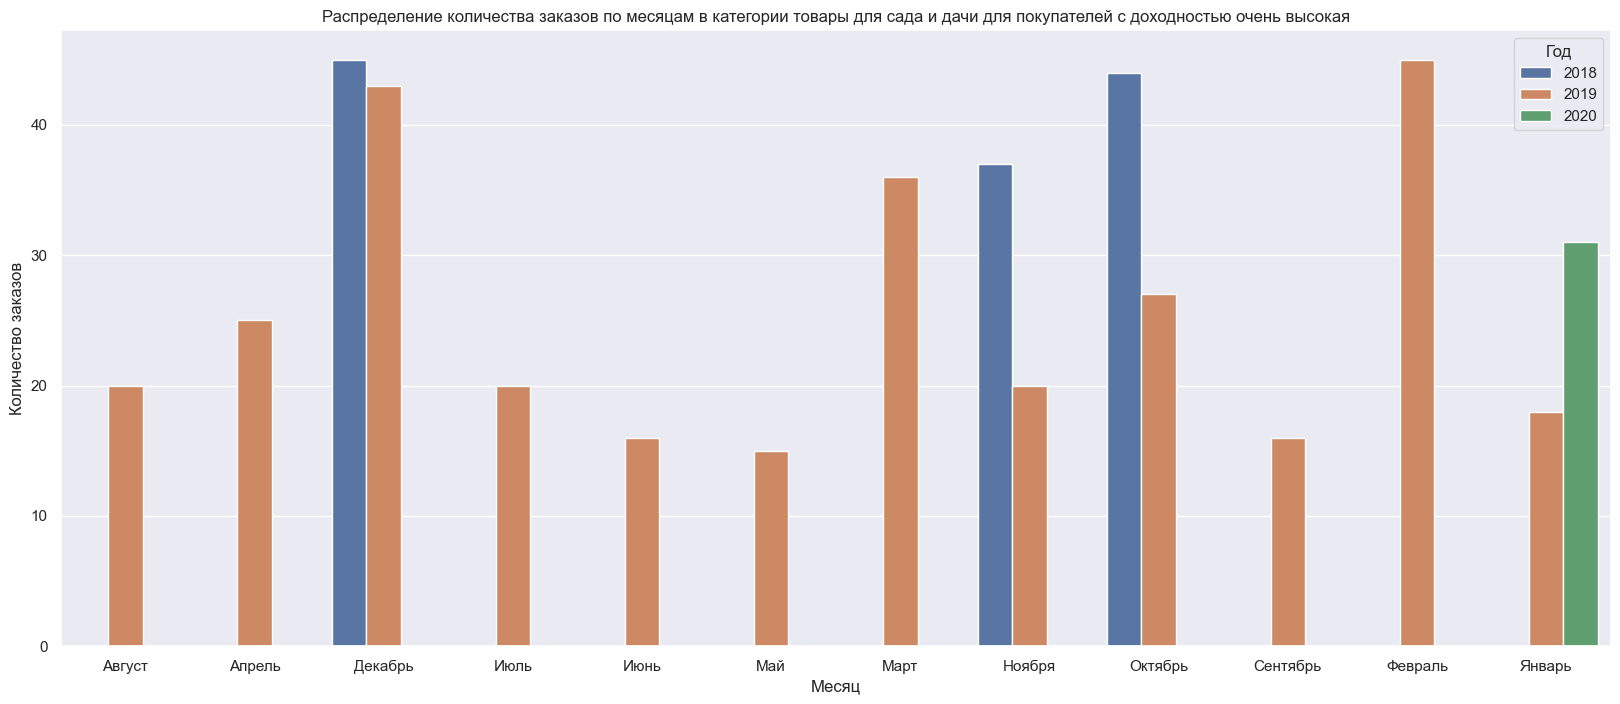

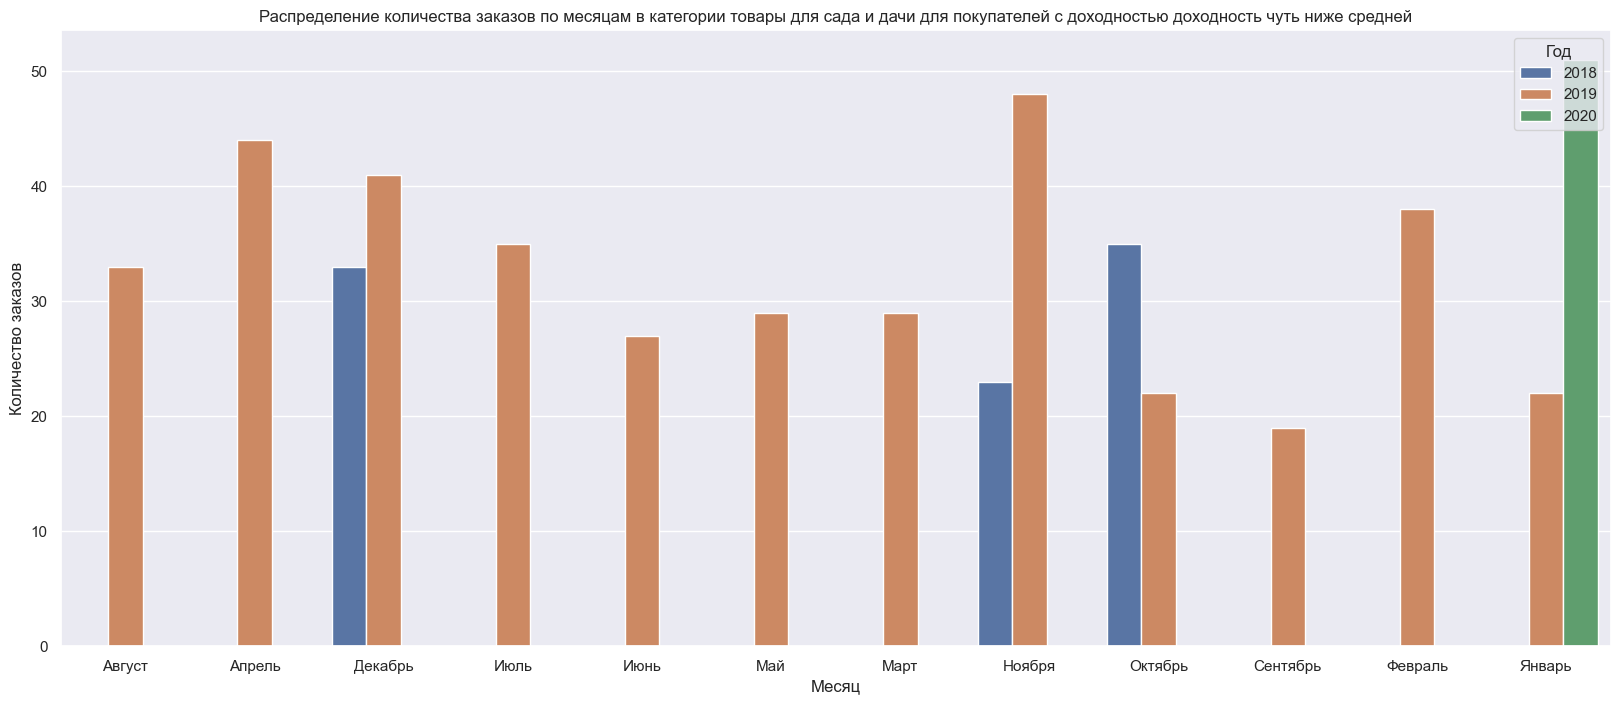

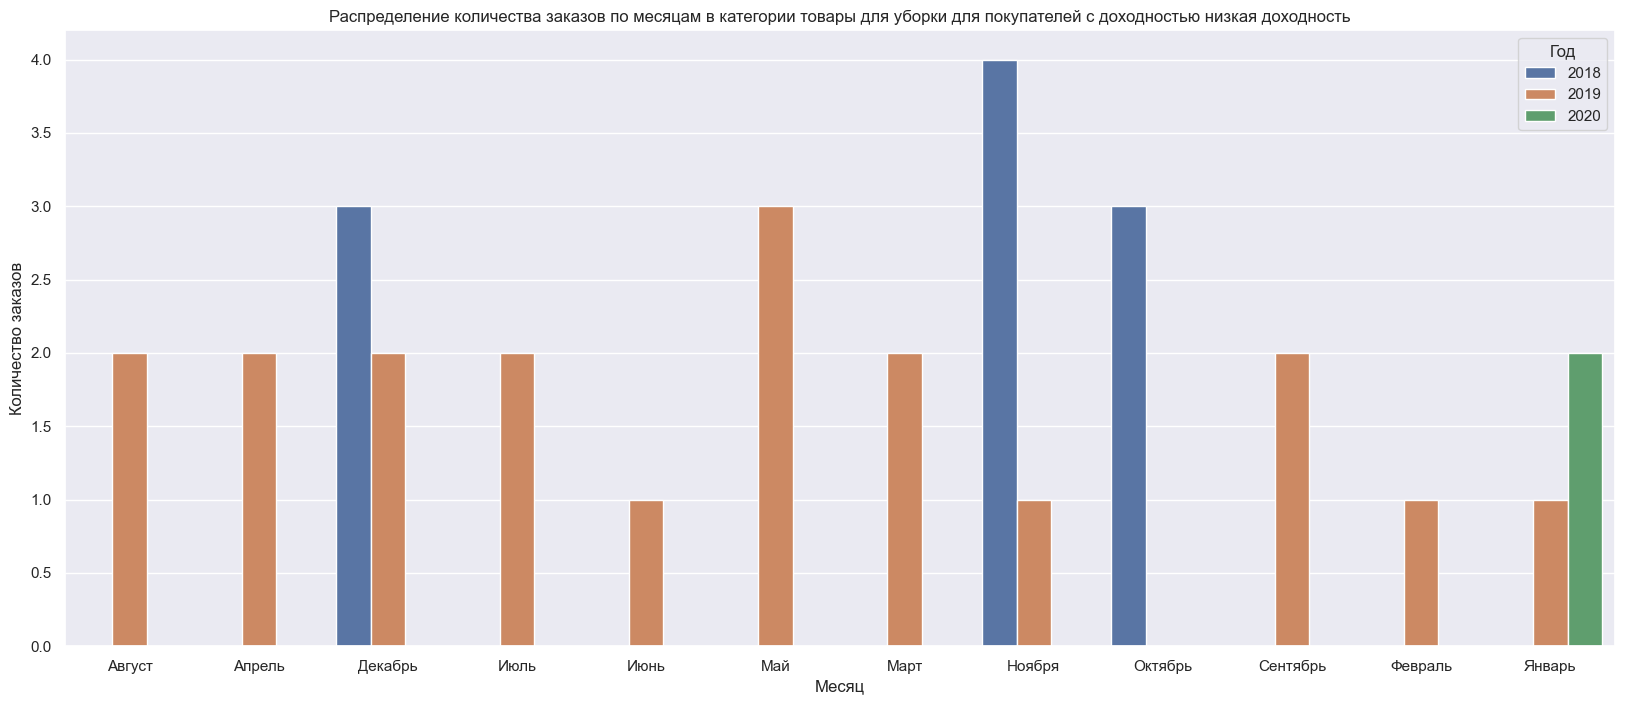

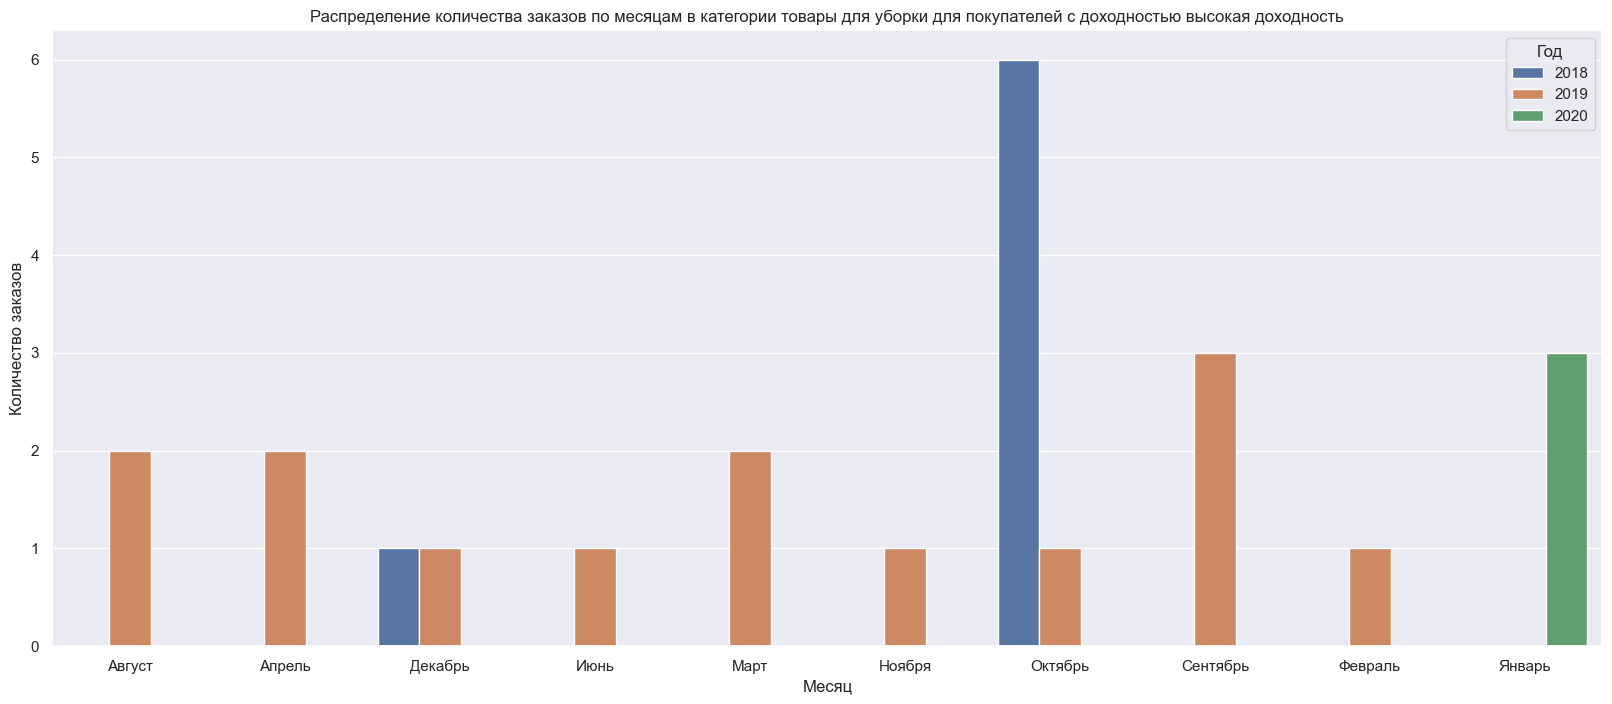

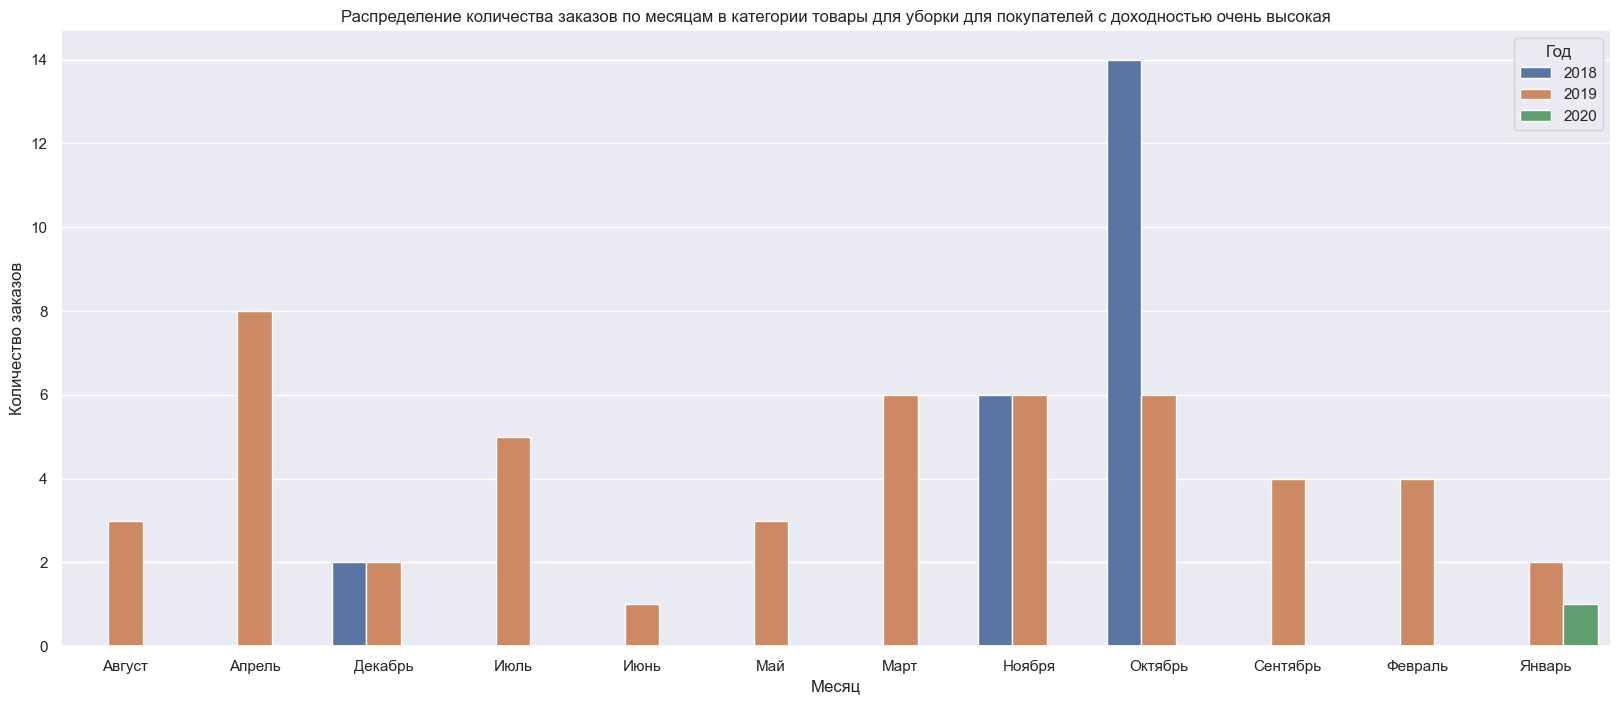

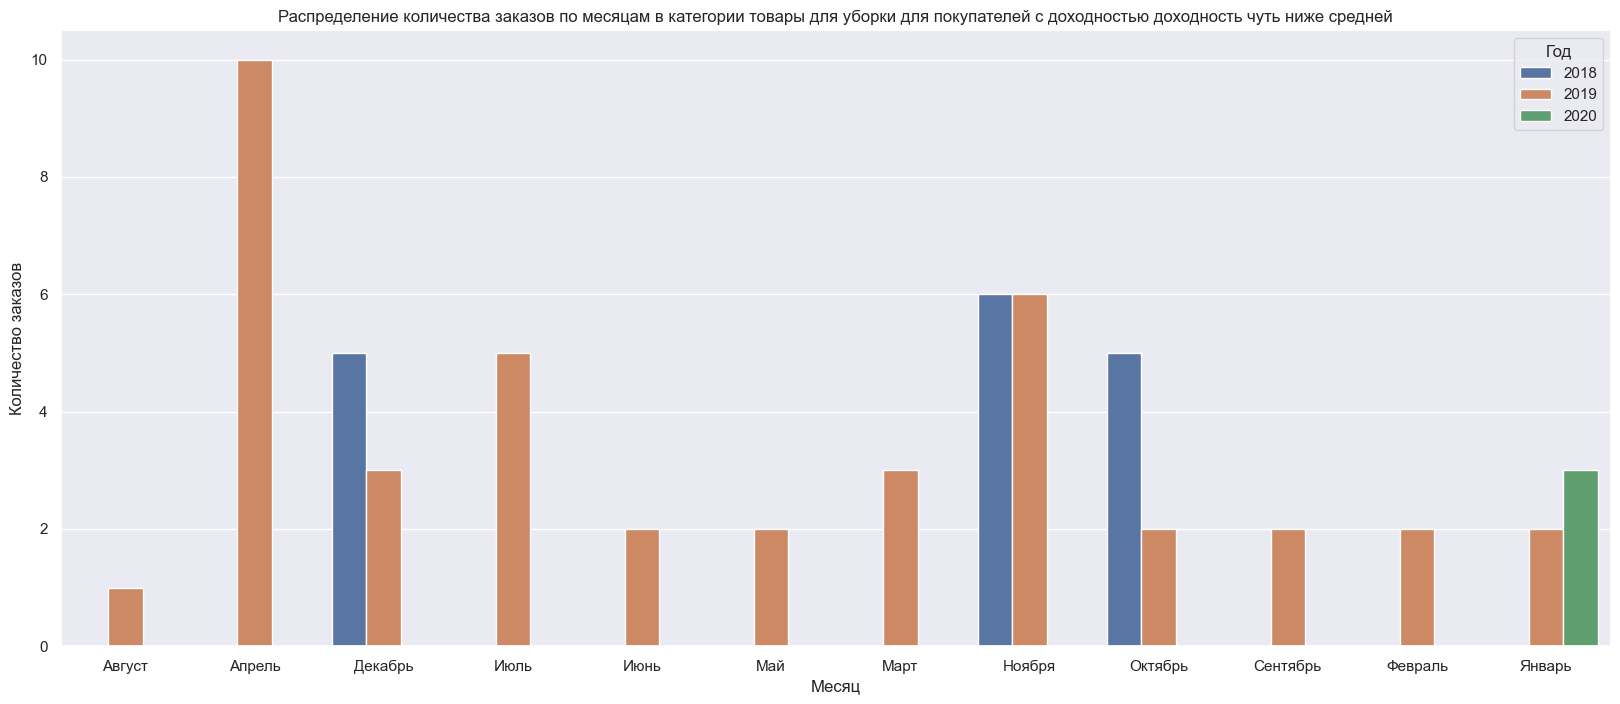

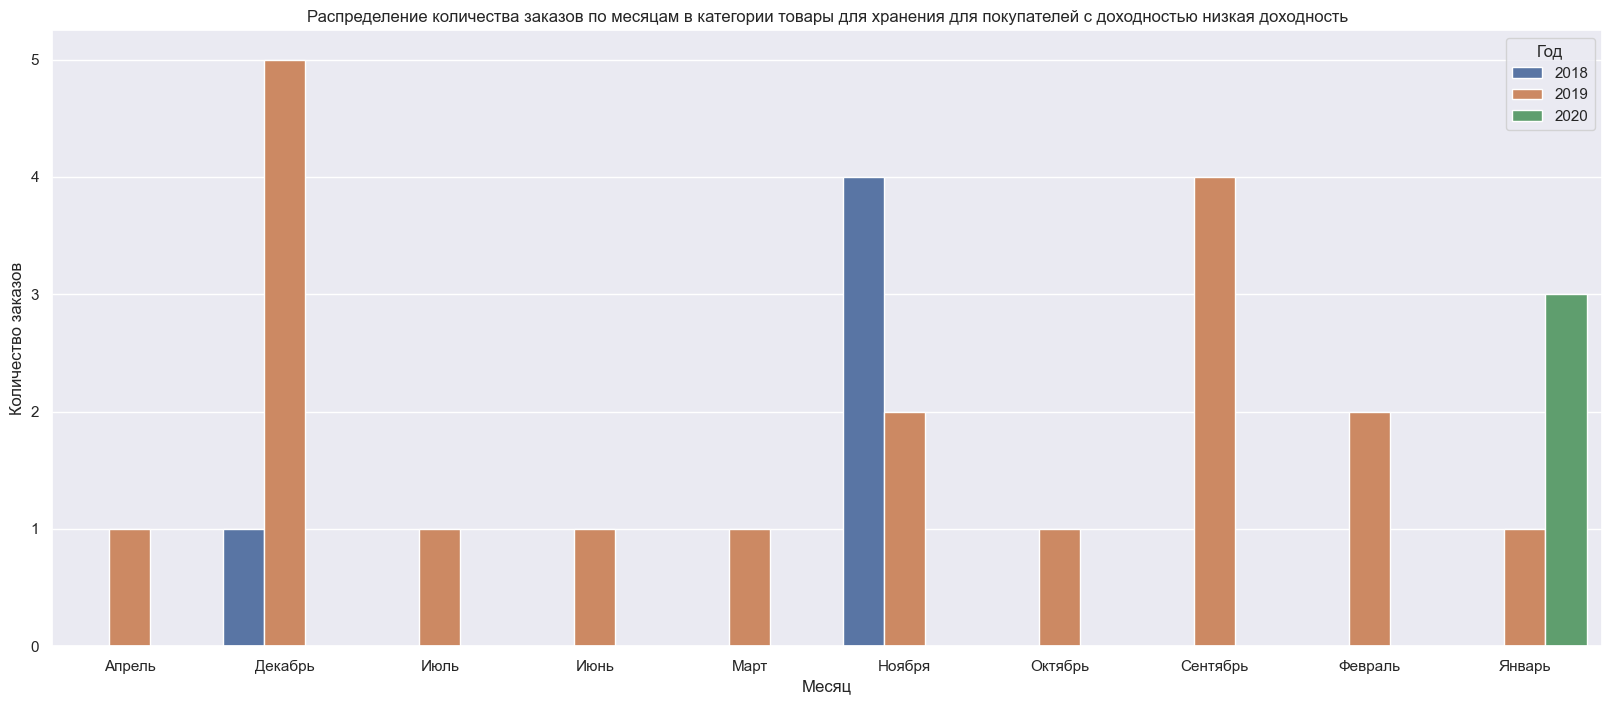

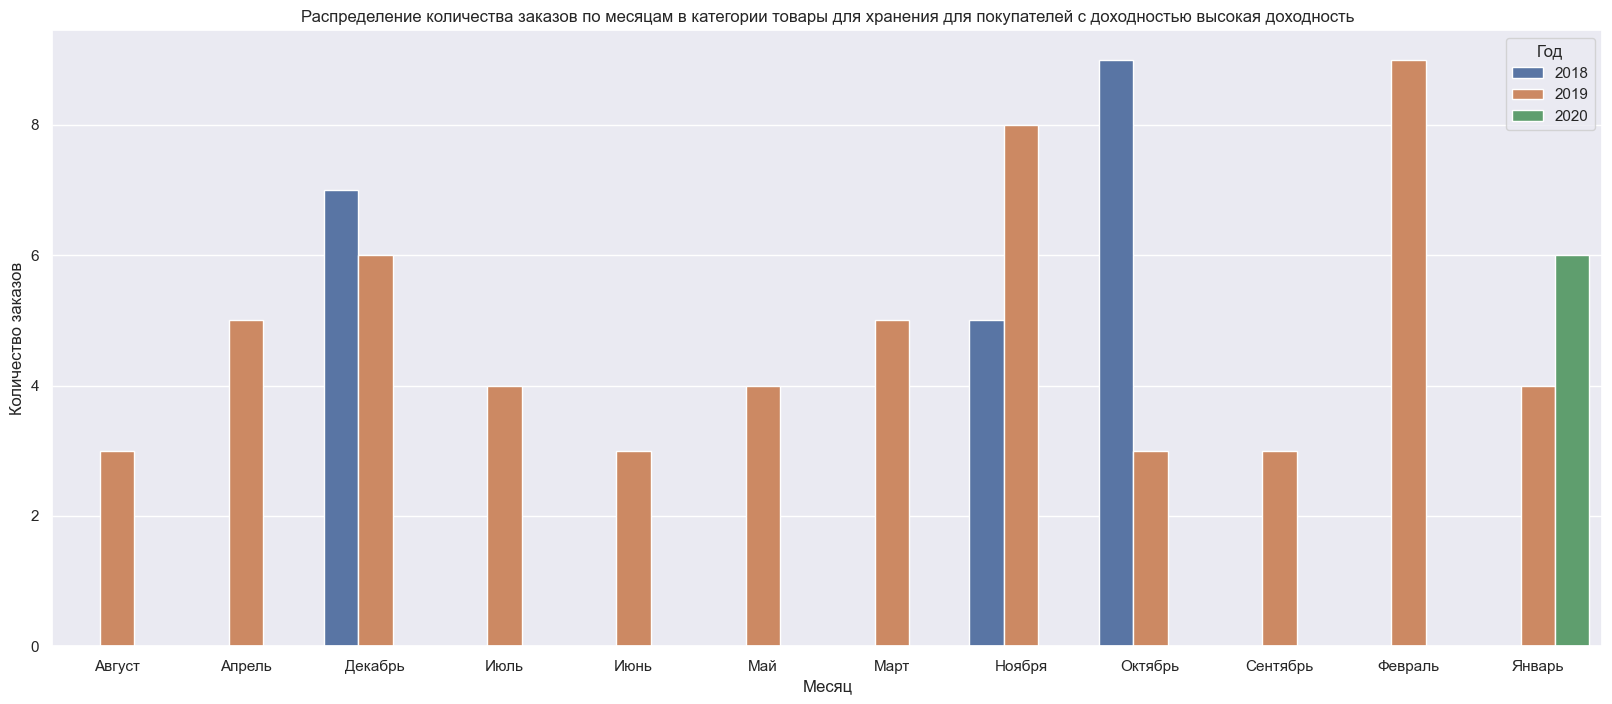

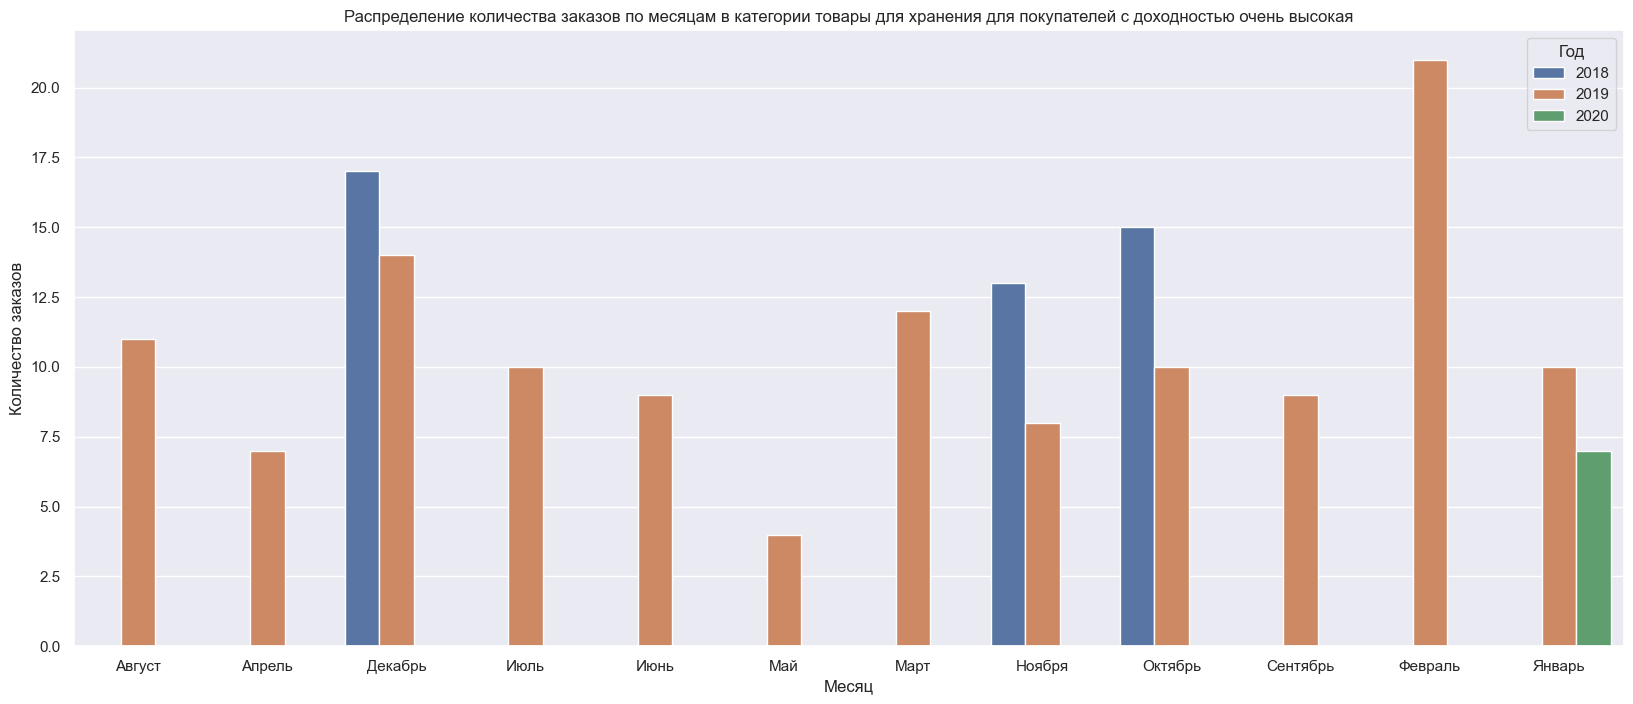

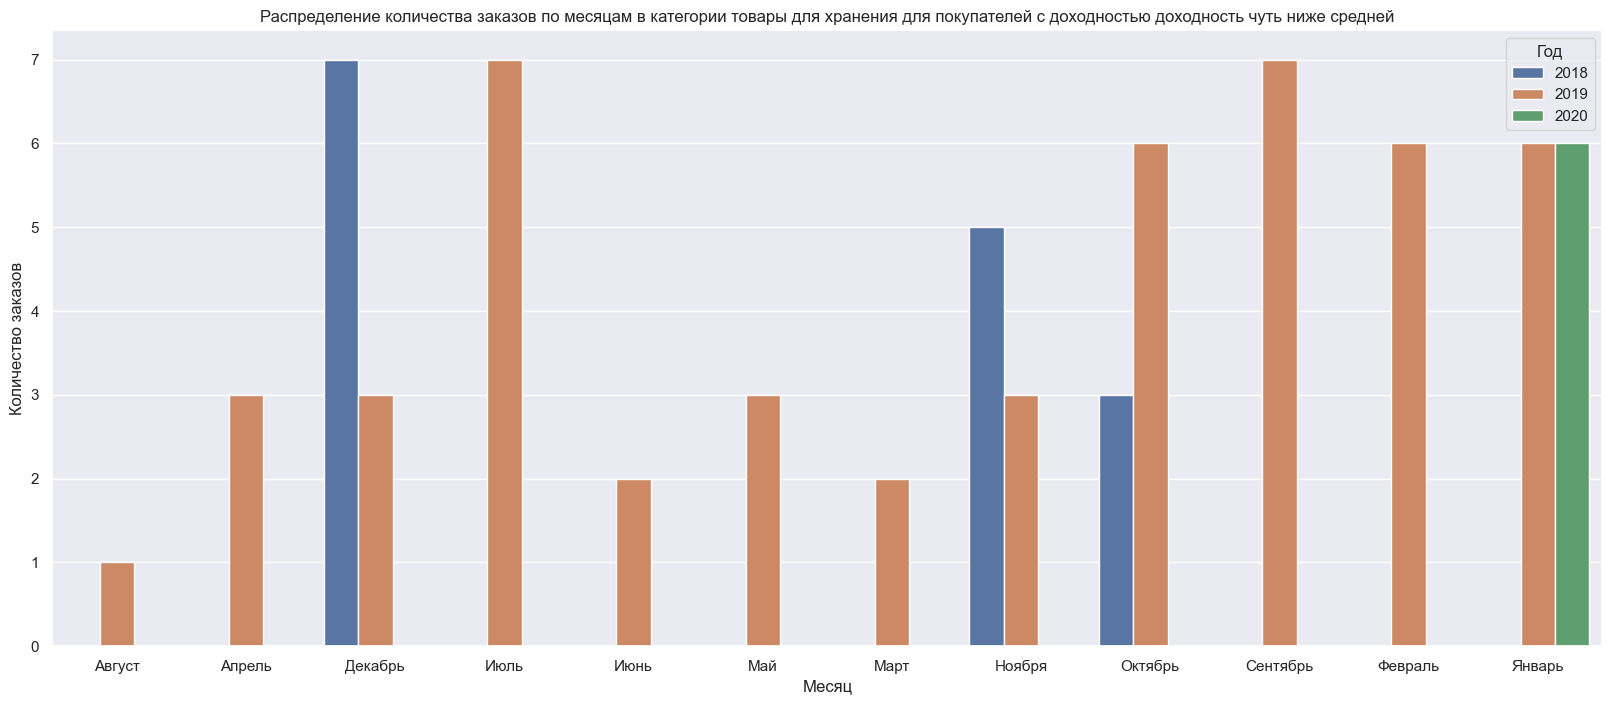

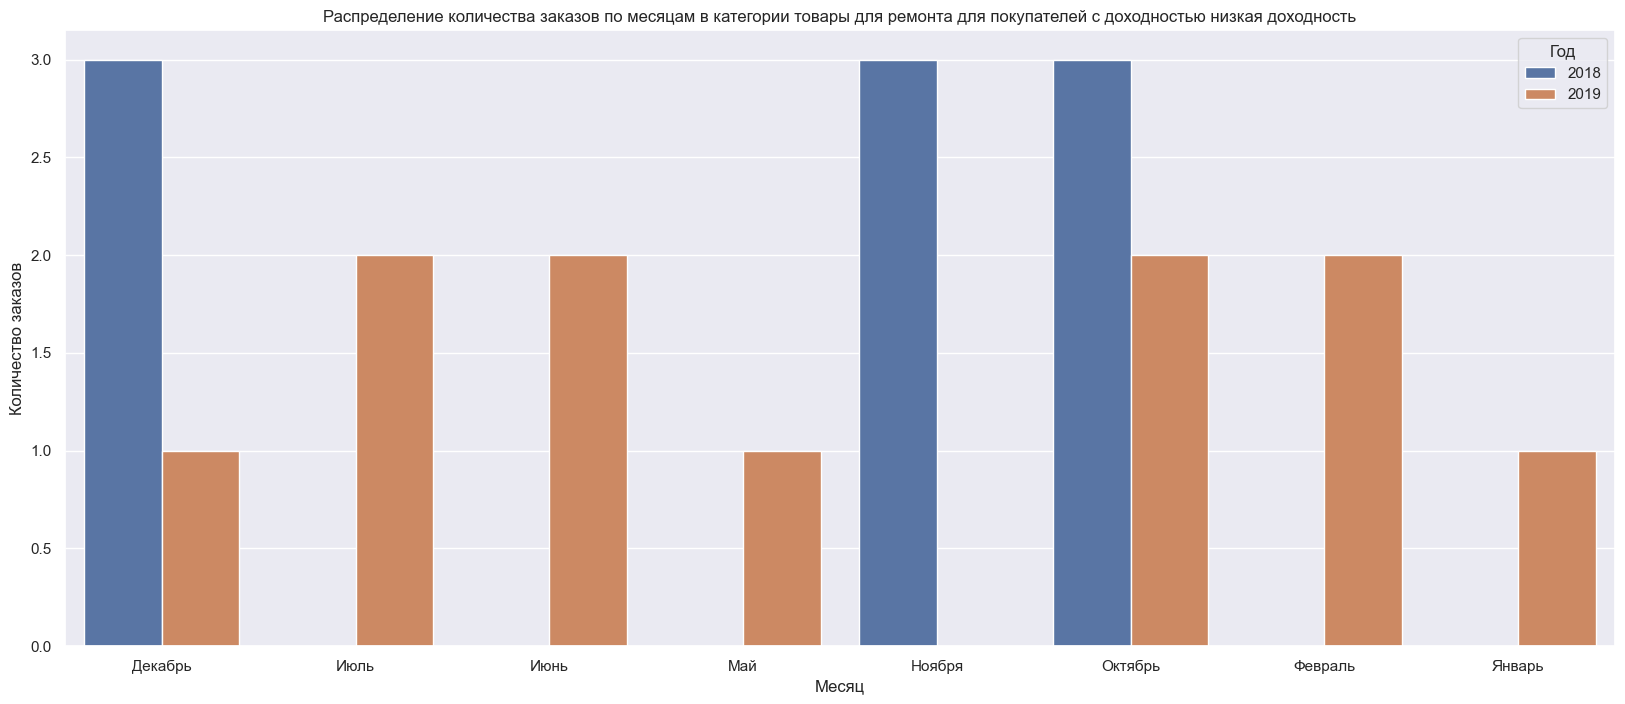

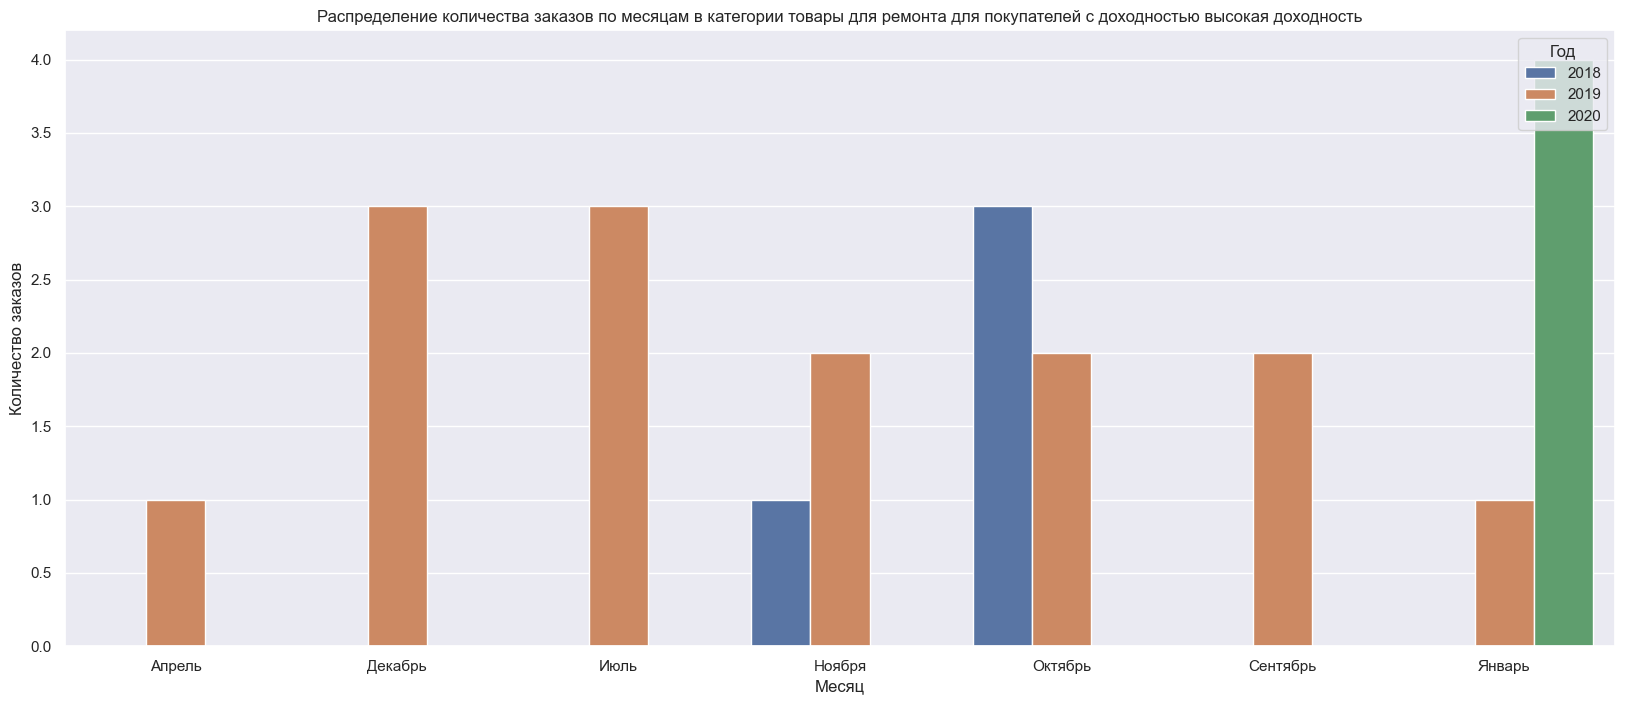

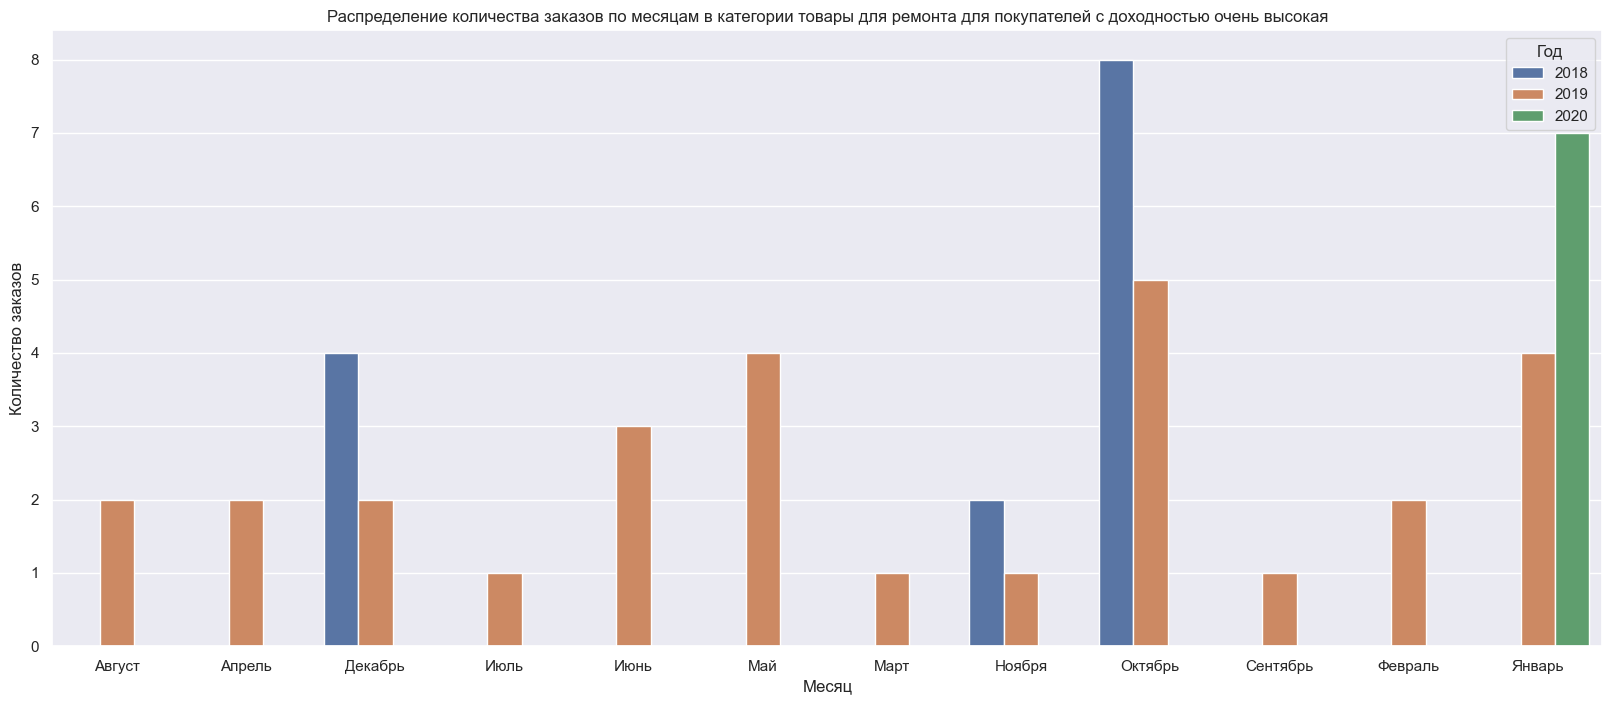

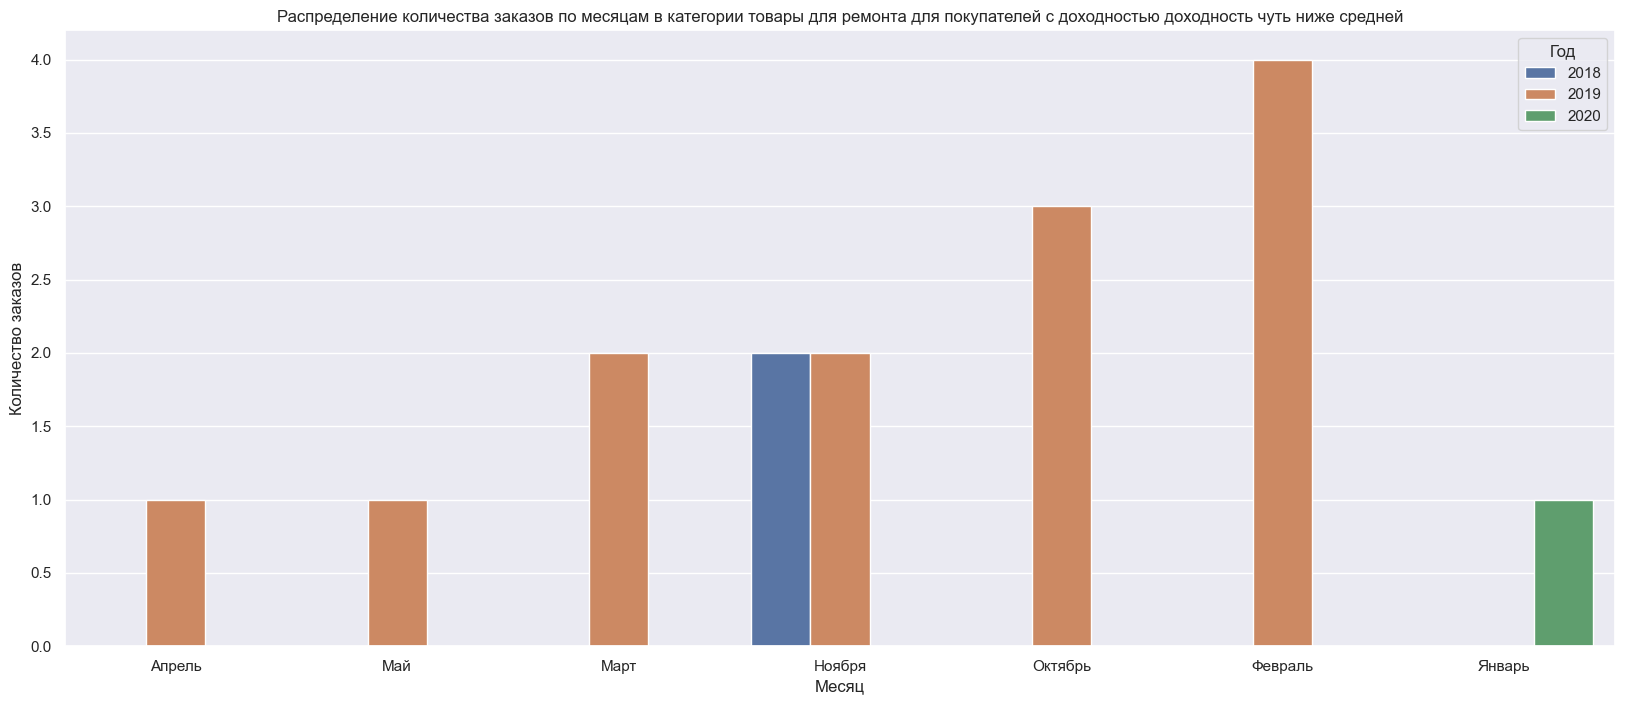

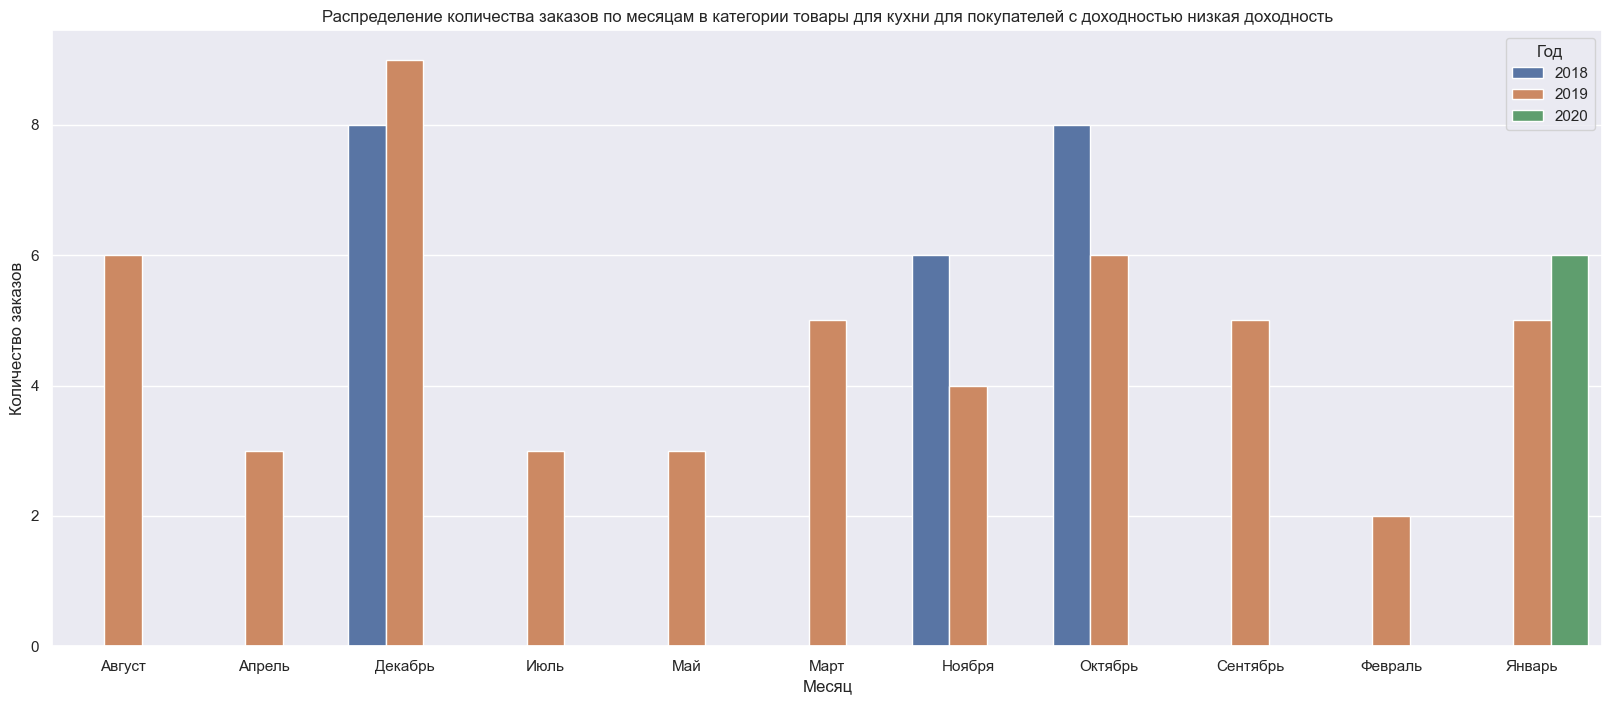

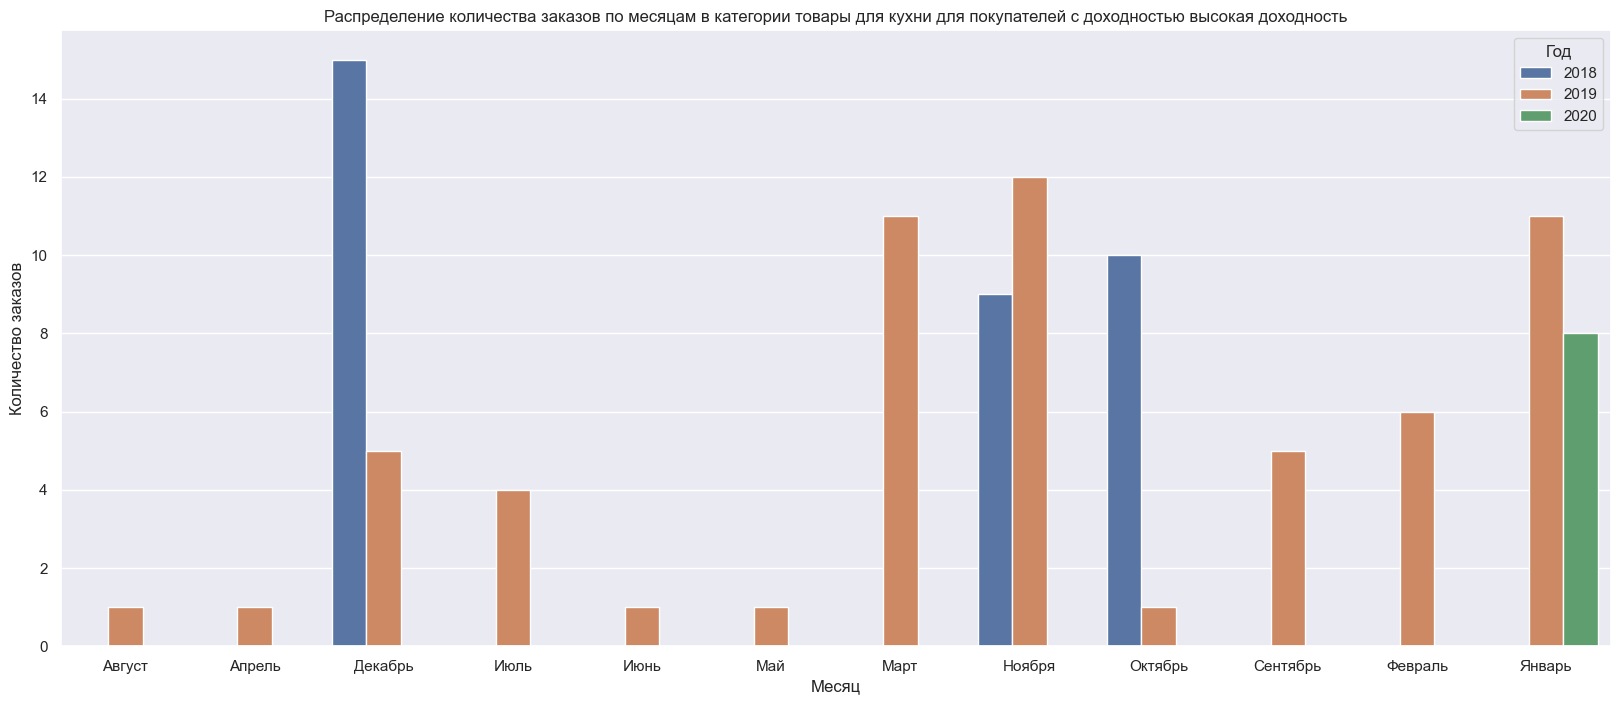

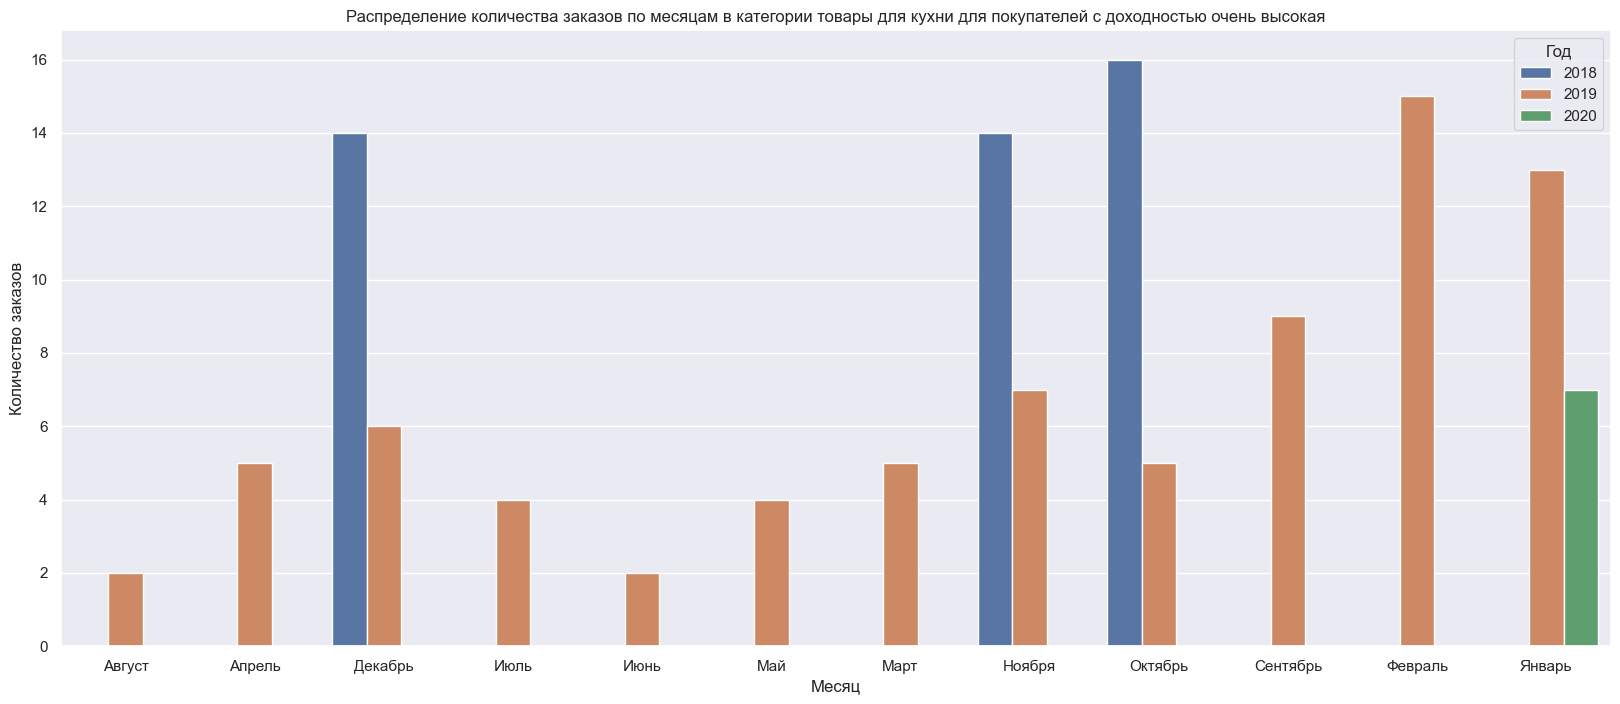

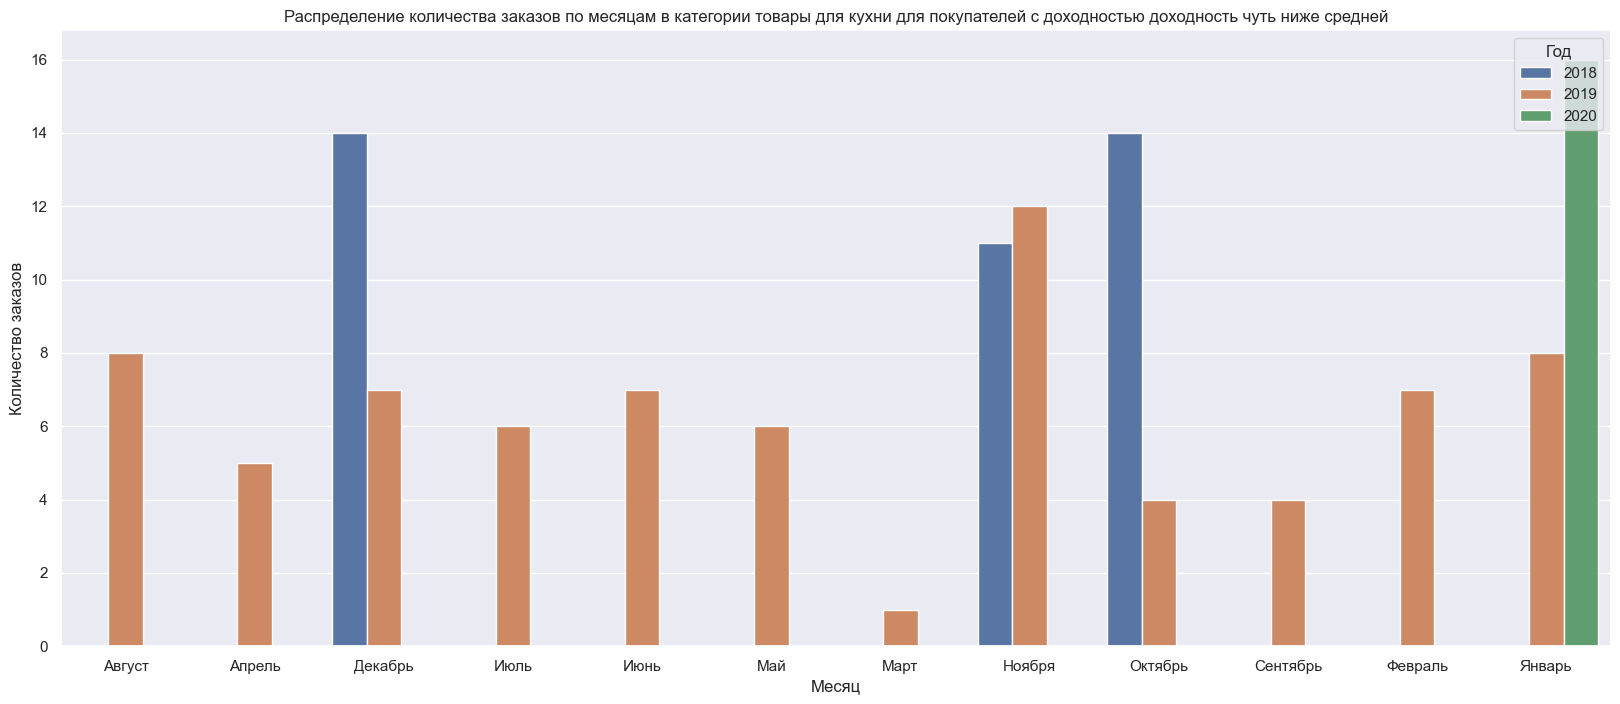

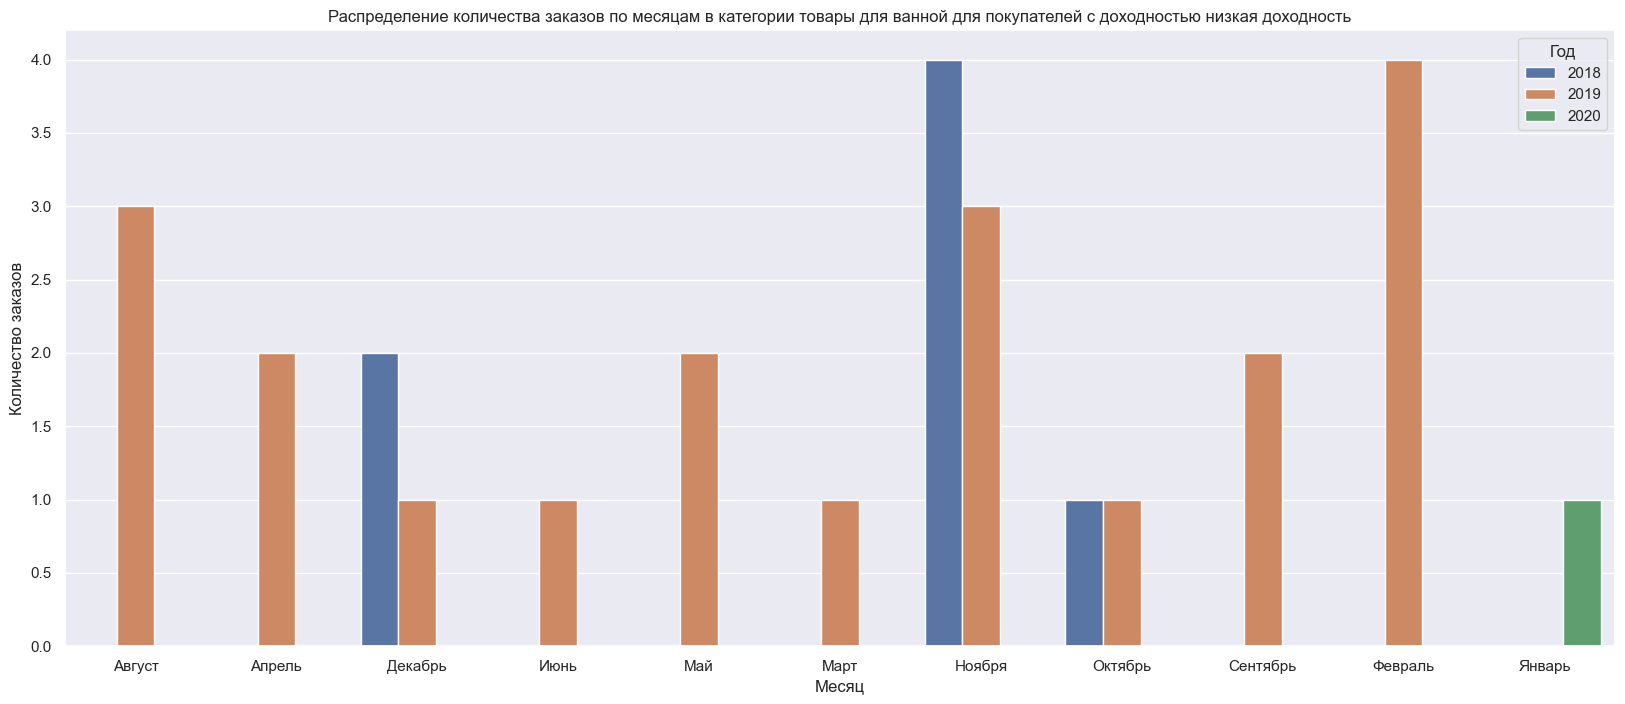

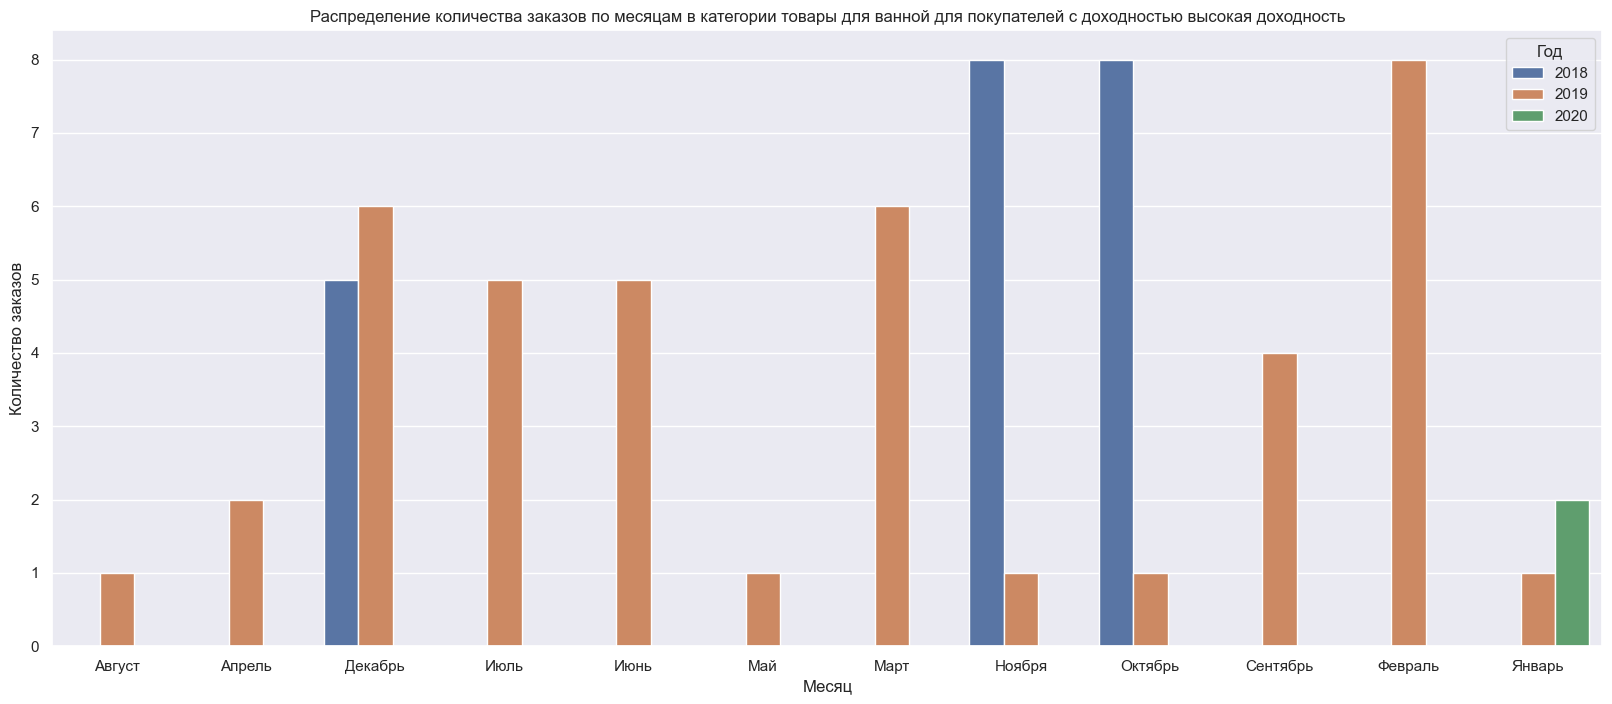

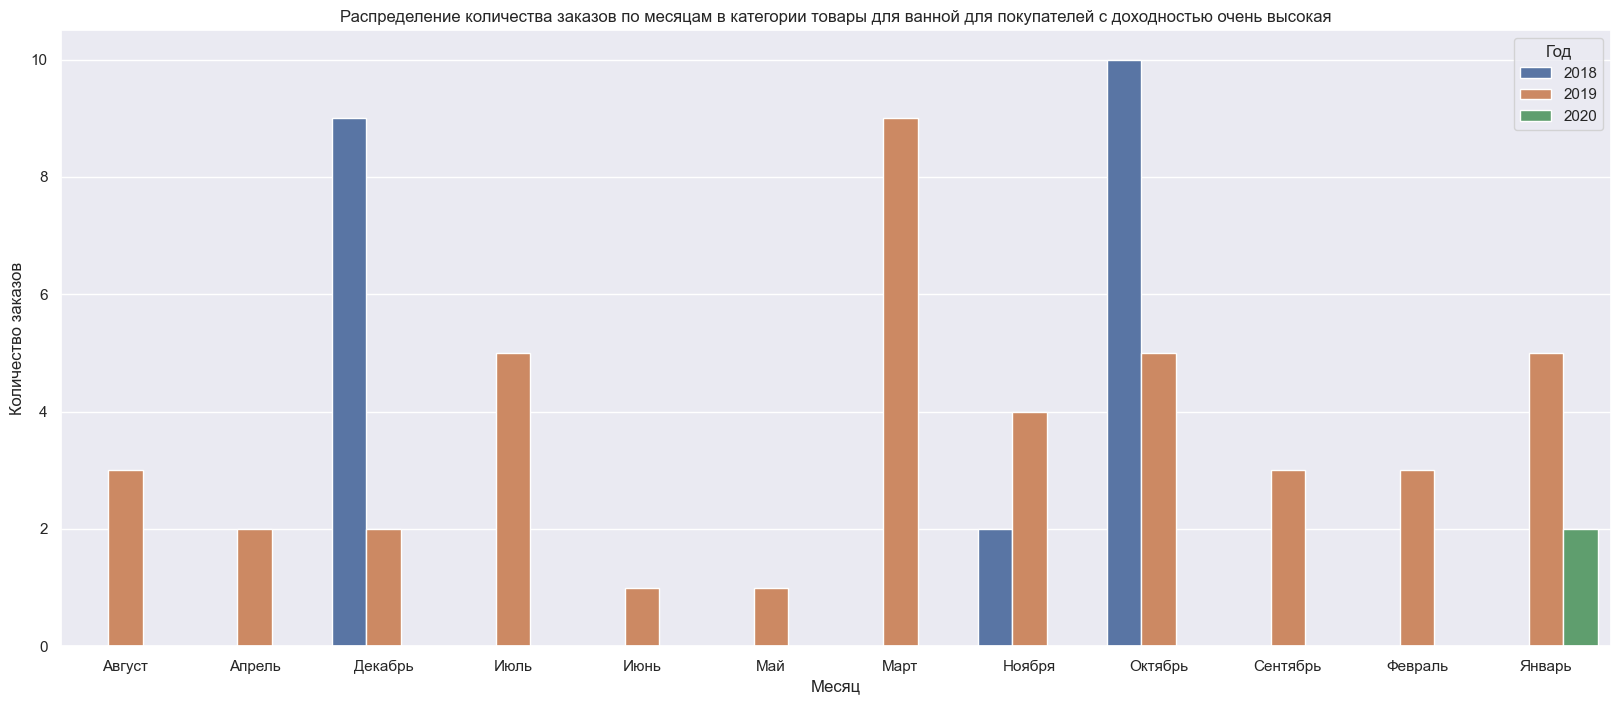

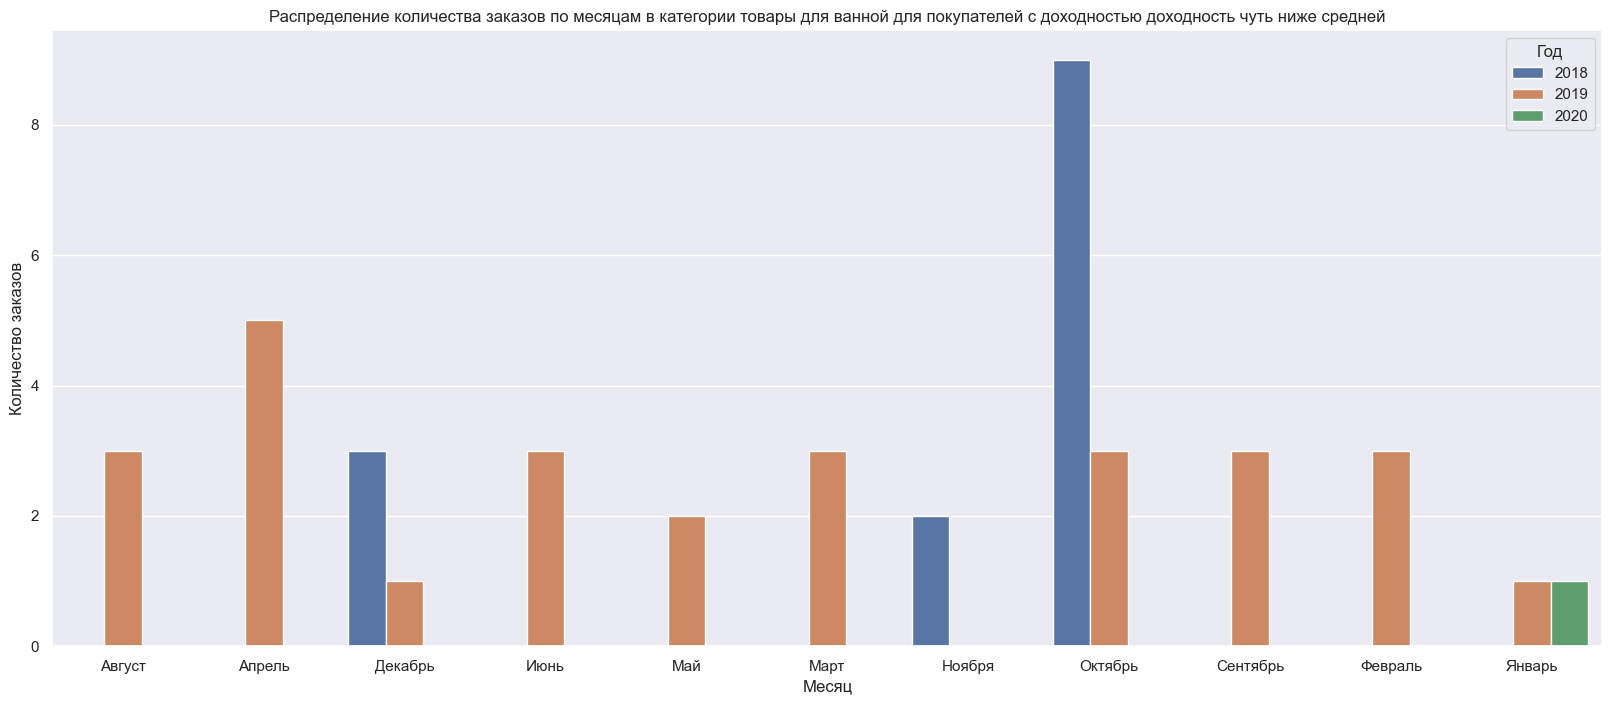

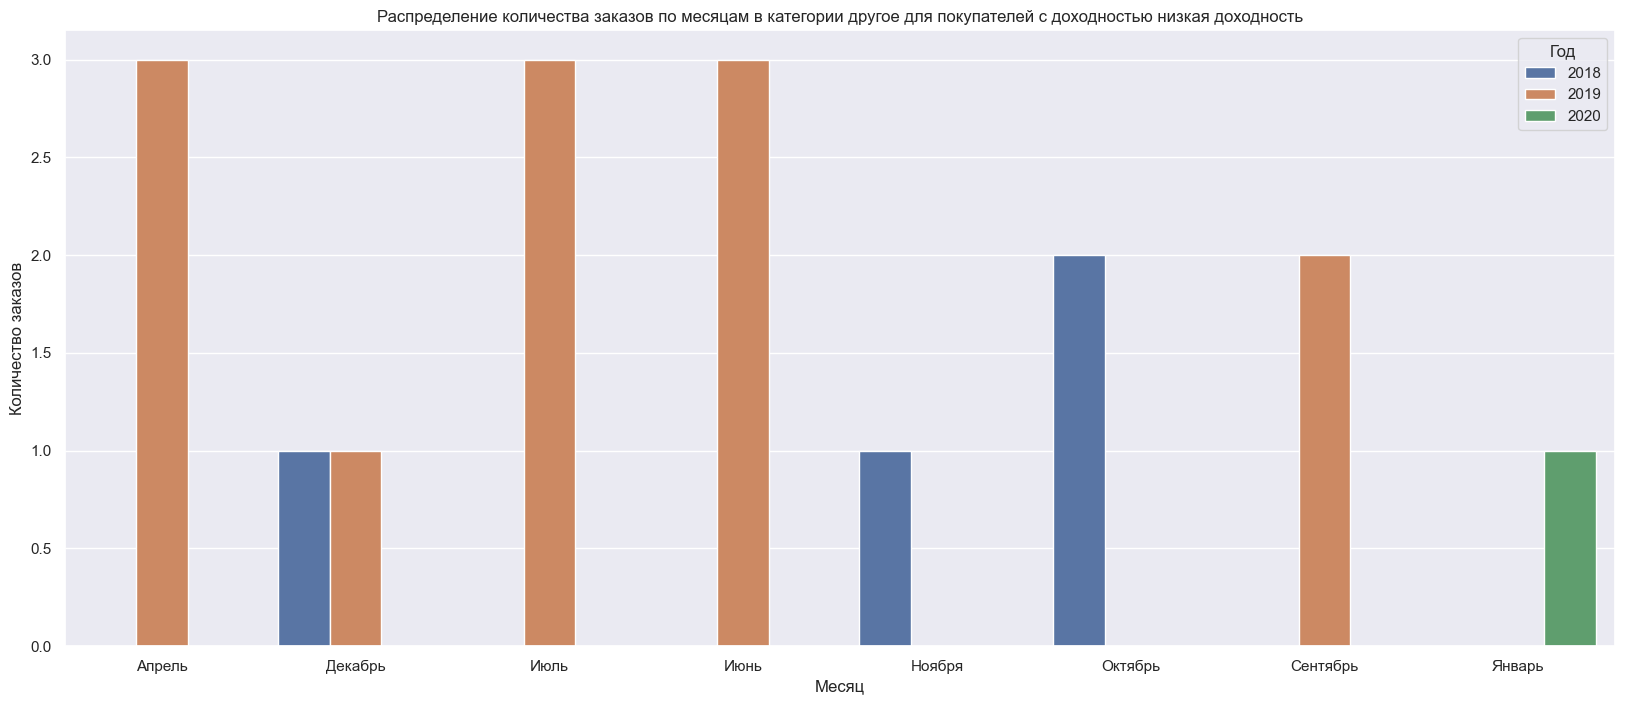

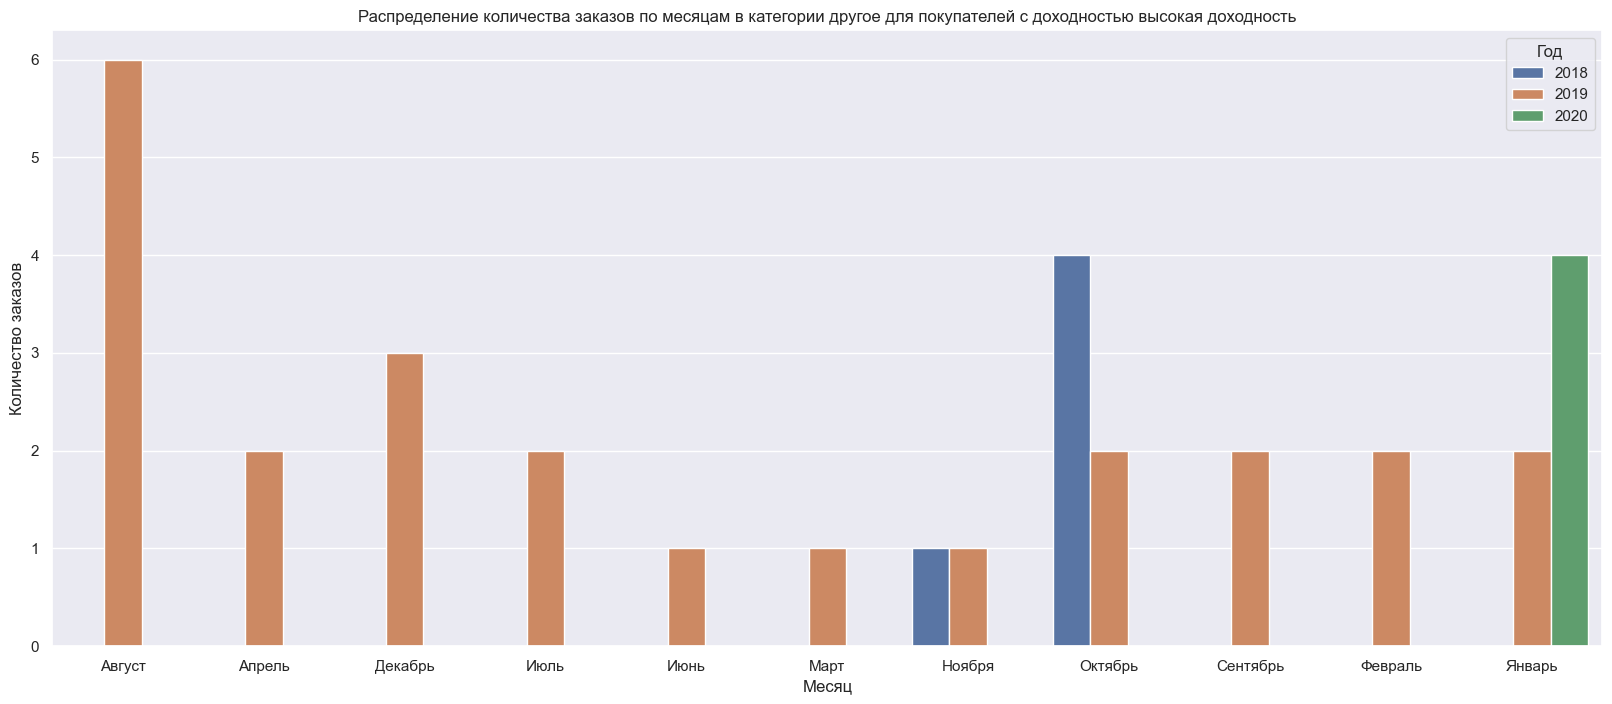

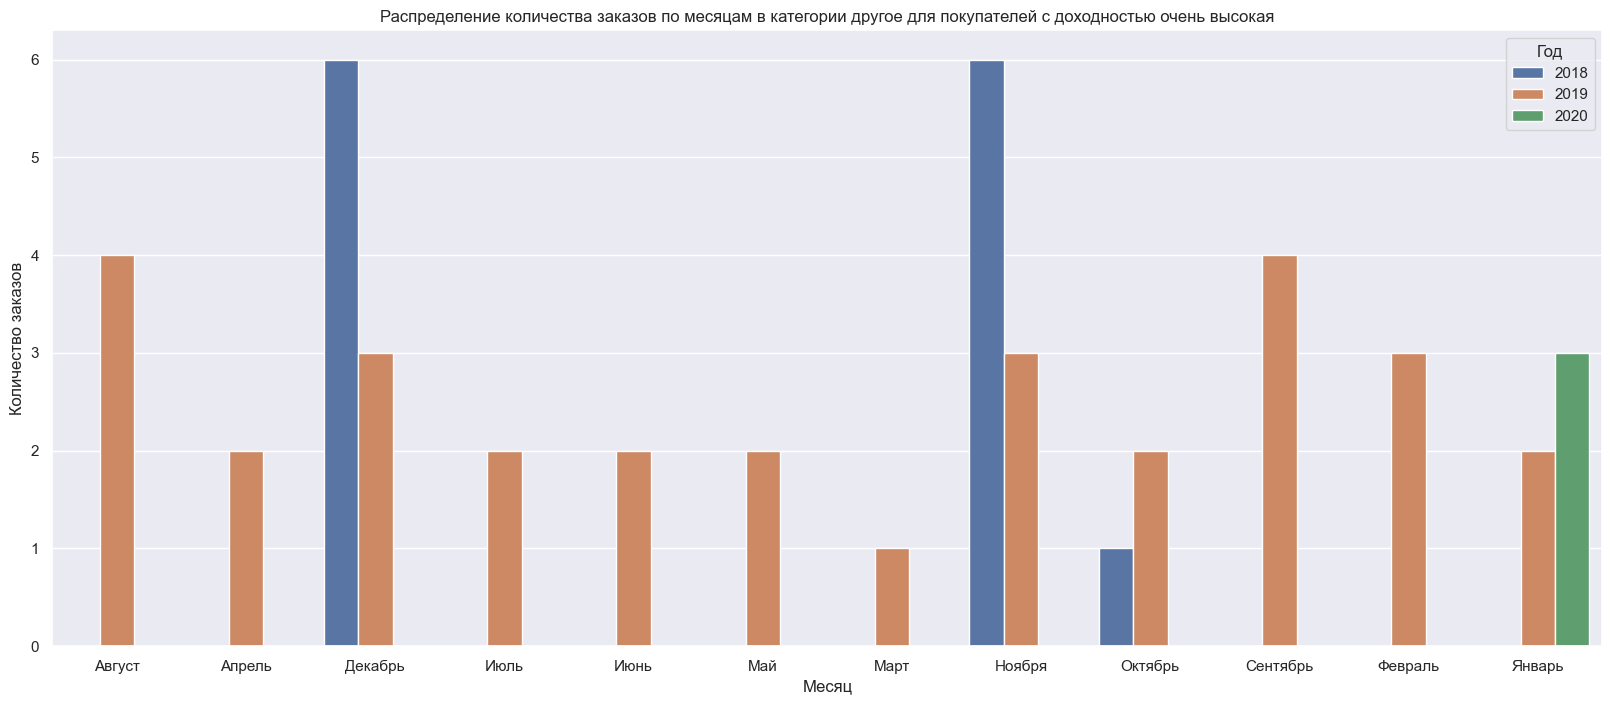

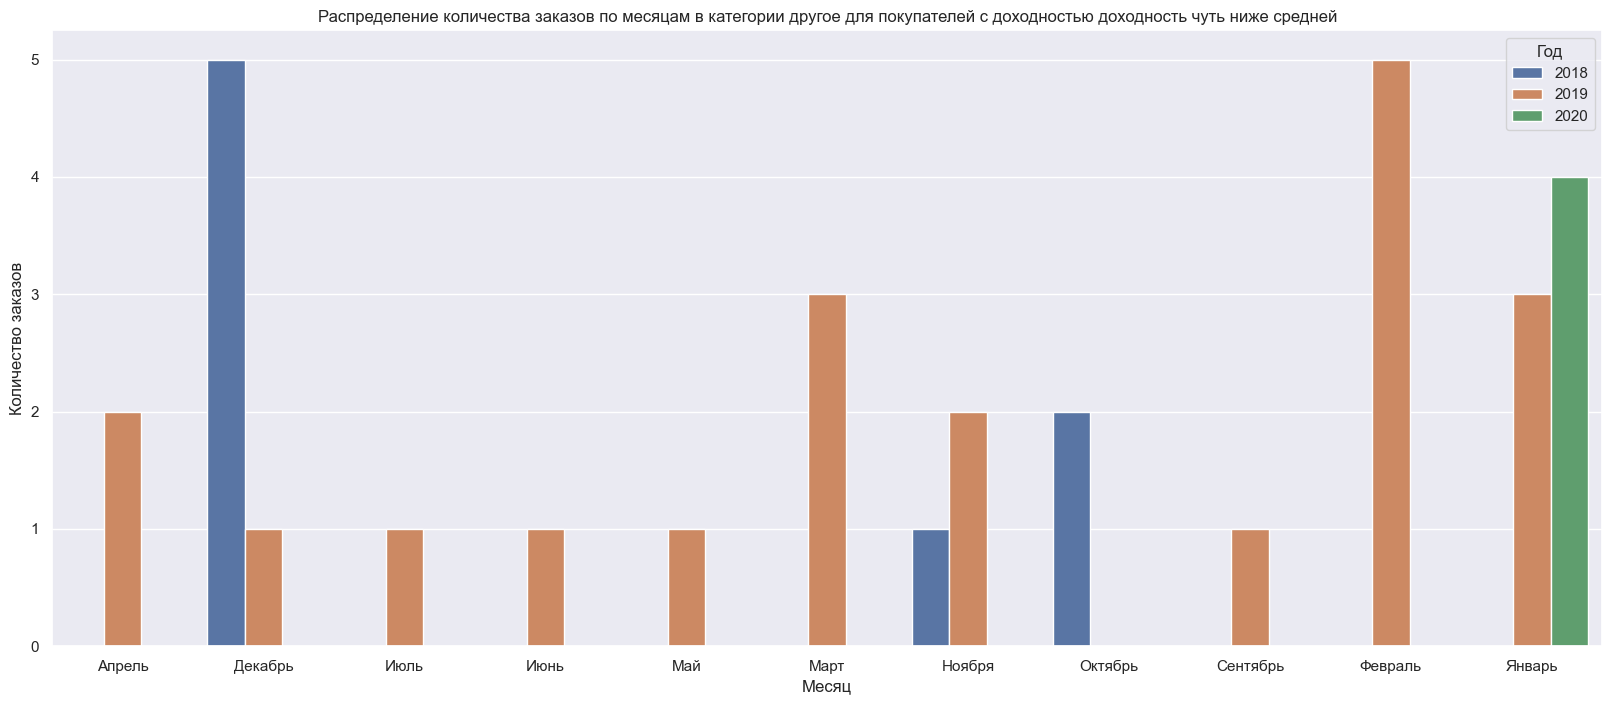

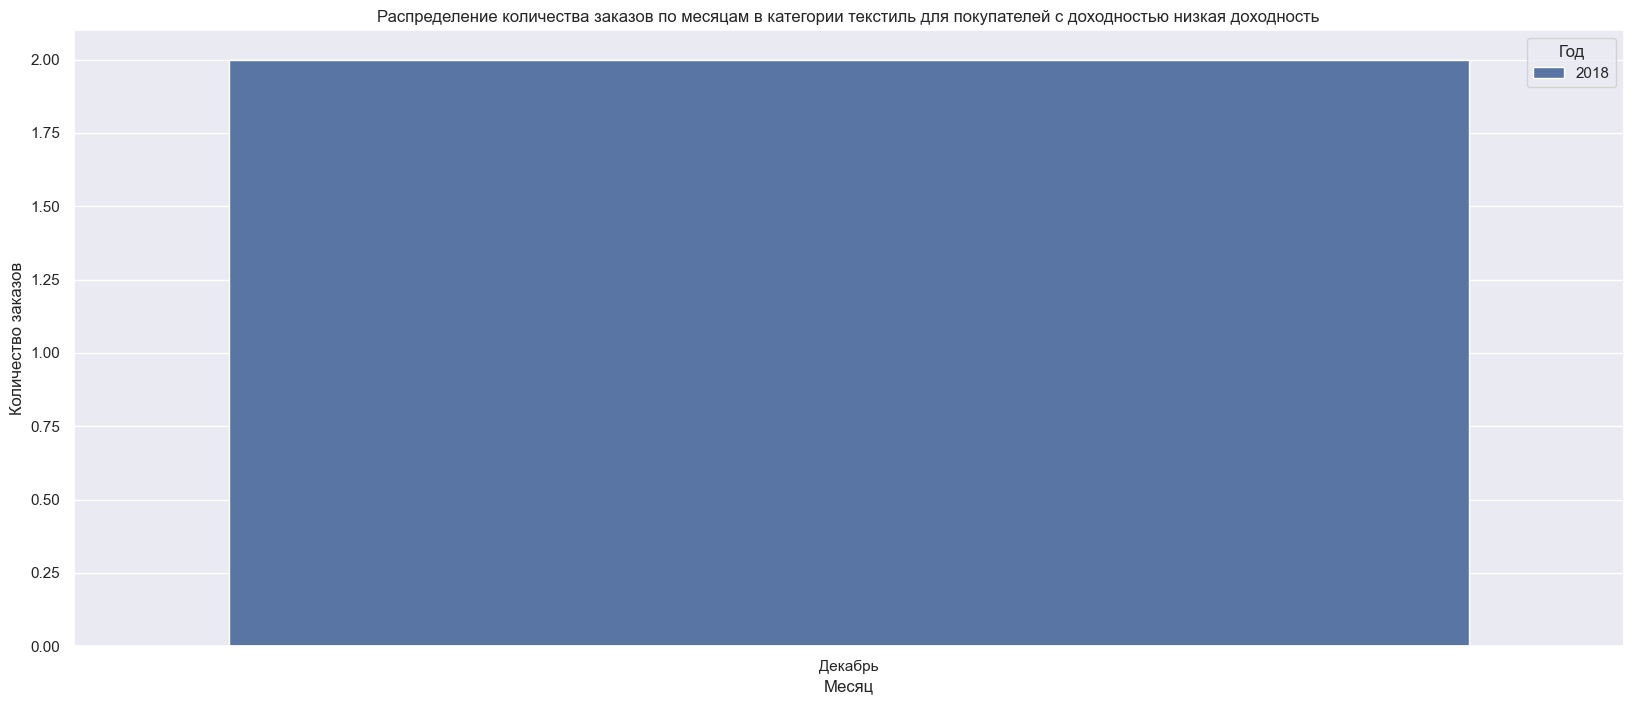

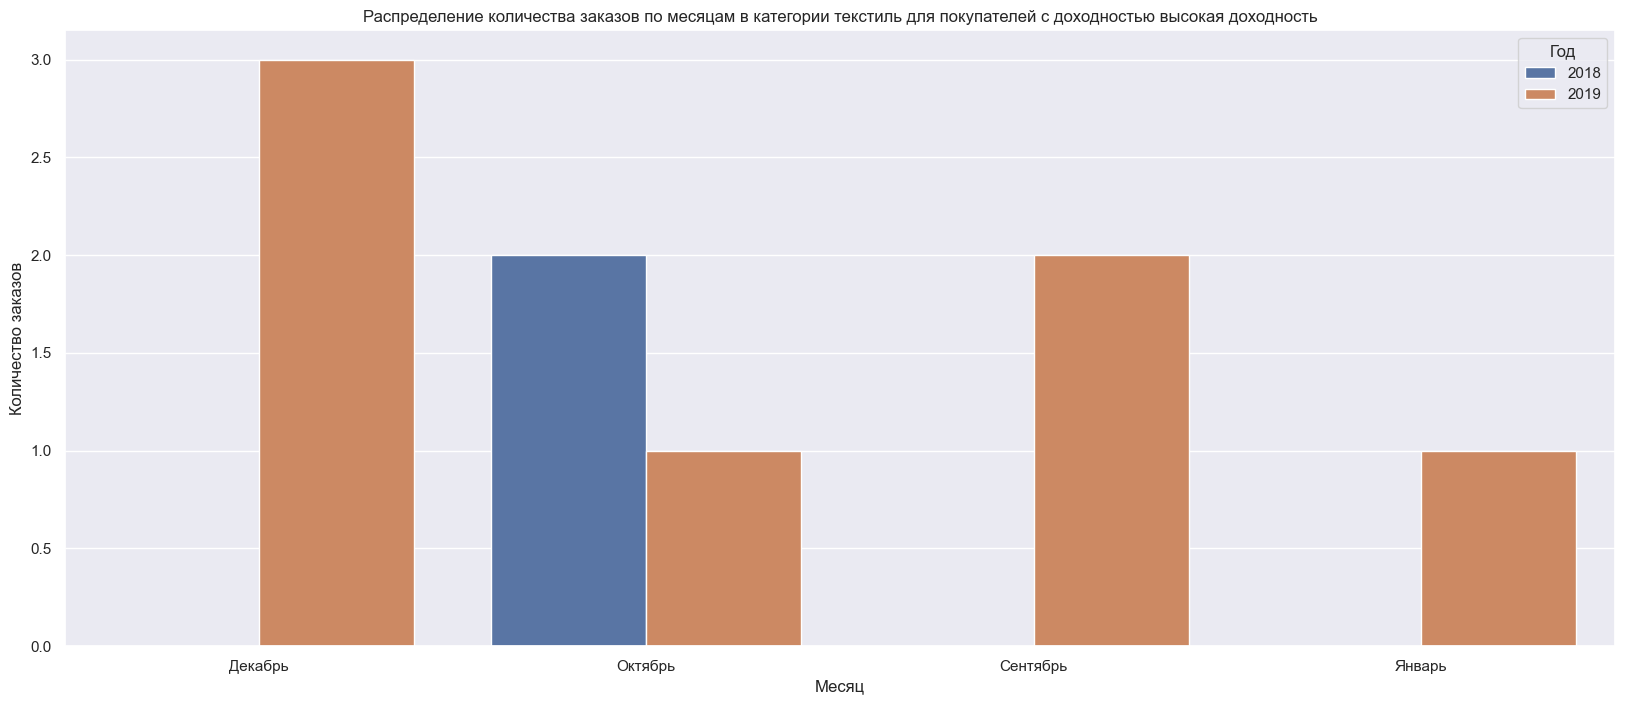

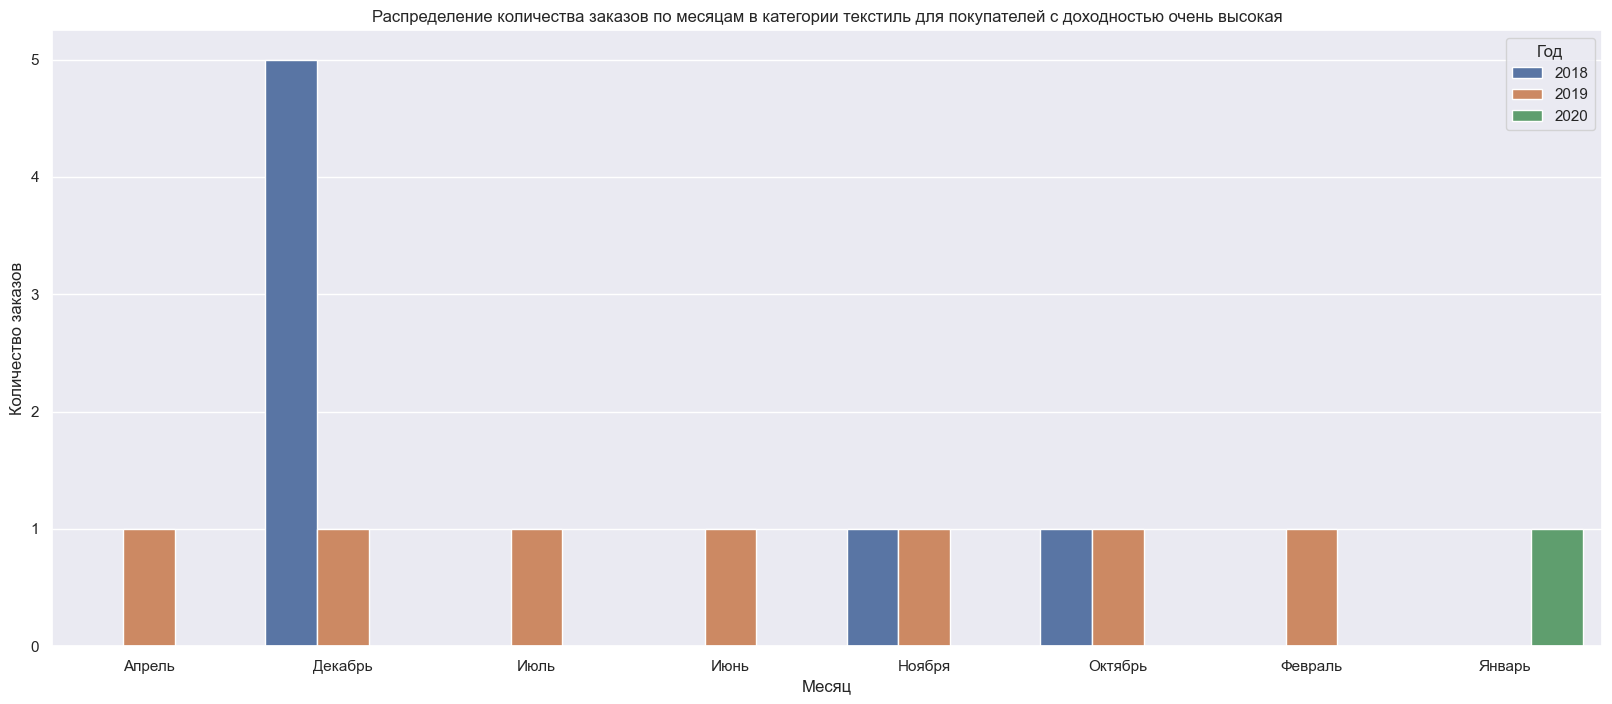

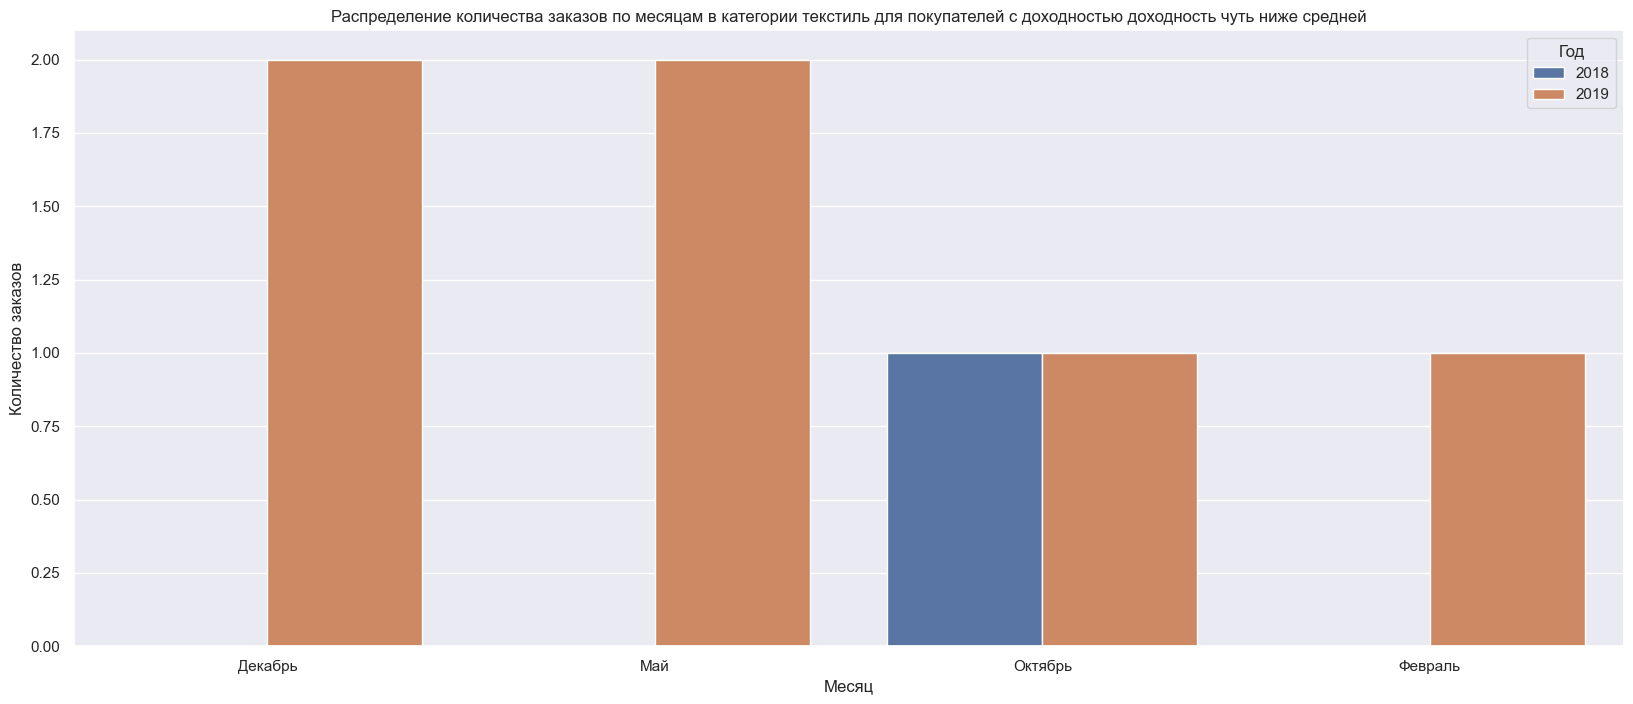

In [66]:
for row in list_categories:
    for row_revenue in revenue_categories:
        try:
            seasonality_chart = online_shop.loc[(online_shop['category'] == row) & (online_shop['revenue_group'] == row_revenue)].groupby(['month', 'year'])['order_id'].nunique().reset_index()
            plt.figure(figsize=(20, 8))
            sns.barplot(x='month', y='order_id', hue='year', data=seasonality_chart)
            plt.title(f"Распределение количества заказов по месяцам в категории {row} для покупателей с доходностью {row_revenue}")
            plt.xlabel('Месяц')
            plt.ylabel('Количество заказов')
            plt.legend(title='Год')
            plt.show()
        except: print(f"Нет необходимых данных для построения графика по категории {row}")

Определим 3 лучших категорий товаров по числу заказов на основе сформированных категориях товаров и сегментов покупателей.

Для начала определим 3 лучших категорий товаров по числу заказов у сегмента покупателей, имеющих любимые категории товаров.

In [67]:
top_categories = online_shop.loc[online_shop['best_category'].str.contains(r'Любимая категория') == True].groupby('category').agg({'order_id': 'nunique'}).reset_index()
top_categories.columns = ['category', 'amount_orders']
top_categories.sort_values(by='amount_orders', ascending=False, inplace=True)
top_categories.head(3)

,category,amount_orders
5,товары для сада и дачи,77
0,другое,63
3,товары для кухни,18


Теперь определим 3 лучших категорий товаров по числу заказов у сегмента покупателей, не имеющих любимые категории товаров

In [68]:
top_categories = online_shop.loc[online_shop['best_category'].isna() == True].groupby('category').agg({'order_id': 'nunique'}).reset_index()
top_categories.columns = ['category', 'amount_orders']
top_categories.sort_values(by='amount_orders', ascending=False, inplace=True)
top_categories.head(3)

,category,amount_orders
5,товары для сада и дачи,2054
3,товары для кухни,420
7,товары для хранения,340


Теперь определим 3 лучших категорий товаров по числу заказов у по сегментам клиентской доходности.

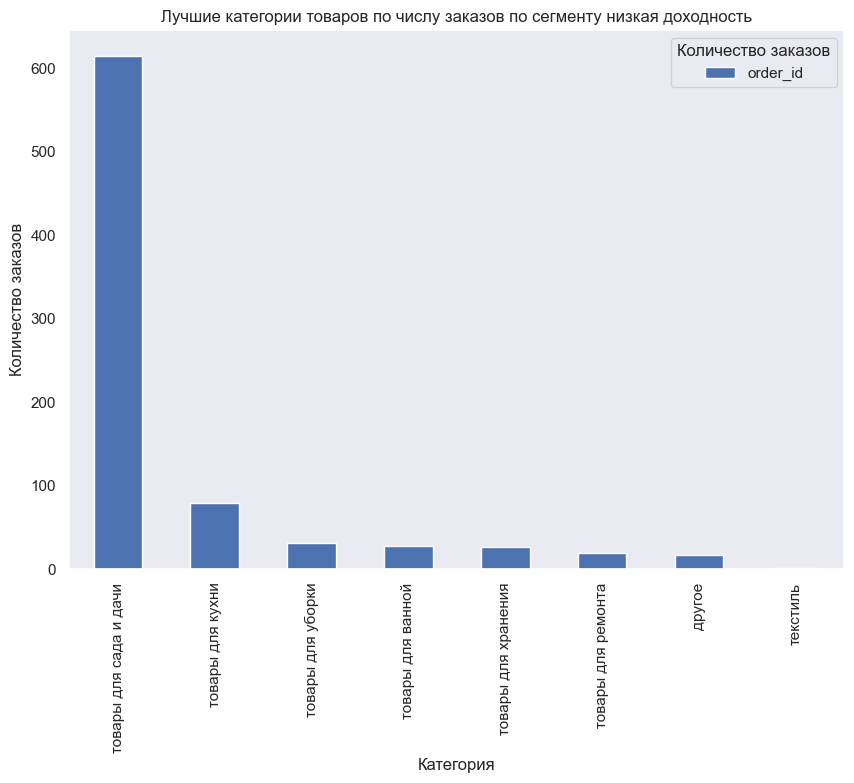

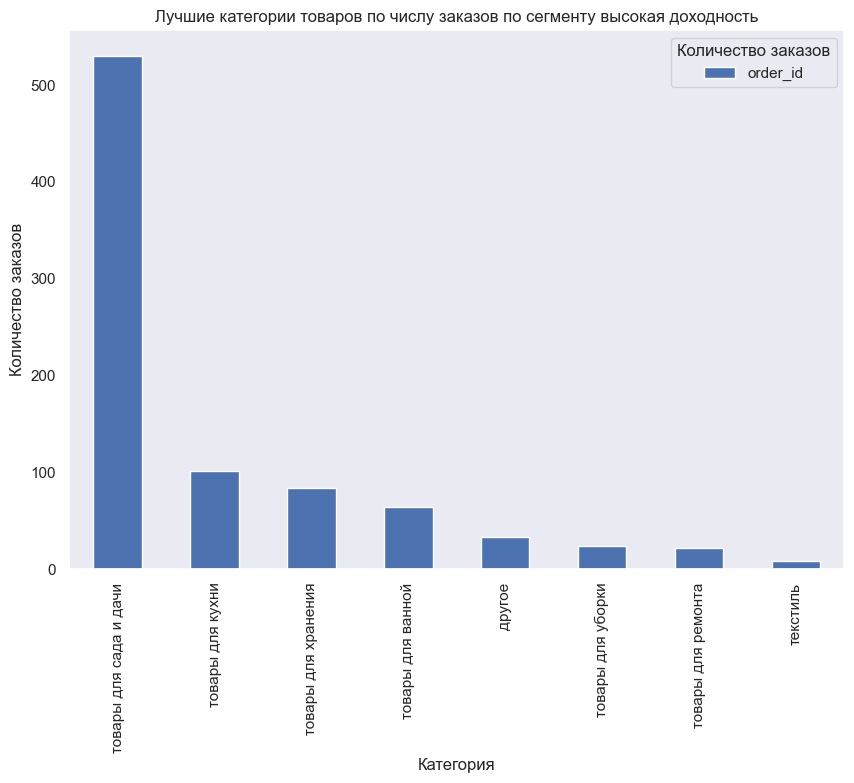

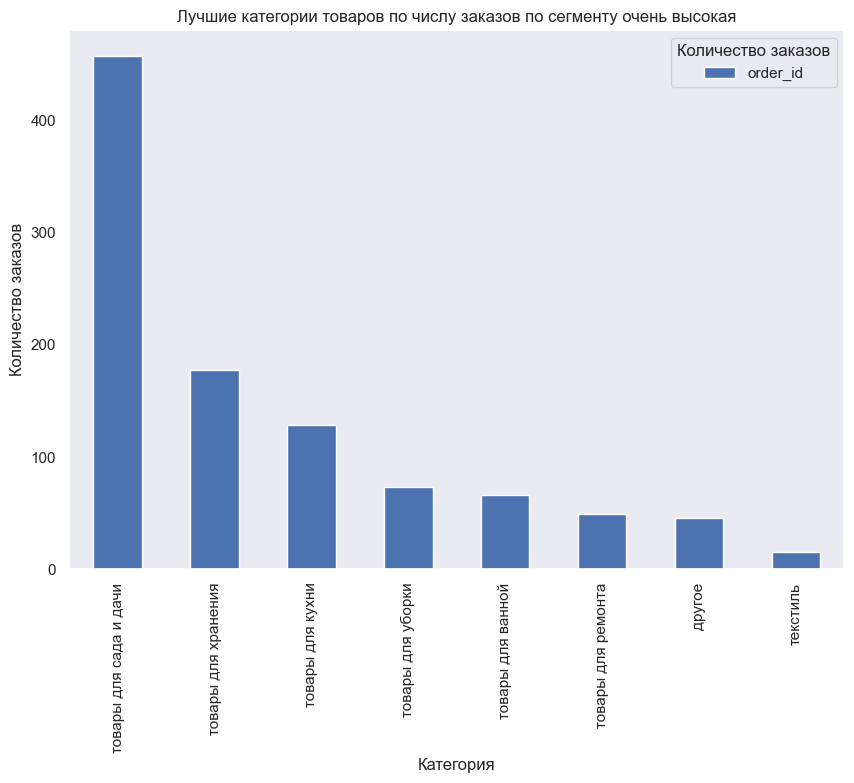

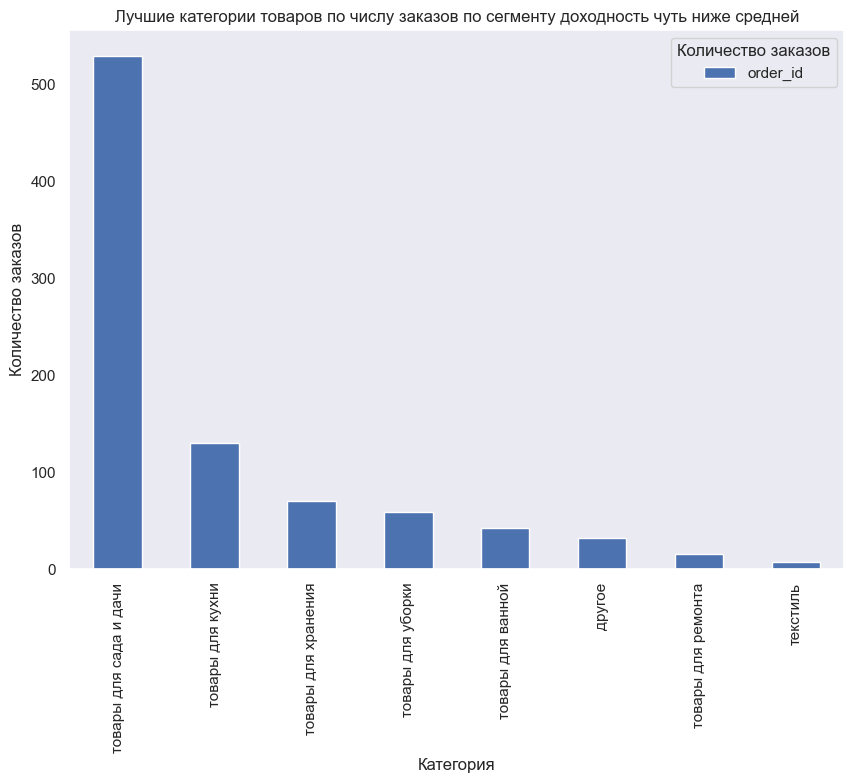

In [69]:
for row_revenue in revenue_categories:
    try:
        top_categories = online_shop.query('revenue_group == @row_revenue').pivot_table(index = 'category', values = 'order_id', aggfunc = 'nunique').sort_values(by = 'order_id', ascending = False)
        top_categories.plot(kind = 'bar', figsize=(10, 7))
        plt.title('Лучшие категории товаров по числу заказов по сегменту '+row_revenue)
        plt.ylabel('Количество заказов')
        plt.xlabel('Категория')
        plt.legend(title='Количество заказов')
        plt.grid()
        plt.show()
    except: print(f"Нет необходимых данных для построения графика по категории {row_revenue}")

Теперь определим 3 лучших категорий товаров по общей стоимости на основе сформированных категориях товаров и сегментов покупателей.

Для начала определим 3 лучших категорий товаров по общей стоимости у сегмента покупателей, имеющих любимые категории товаров.

In [70]:
top_categories = online_shop.loc[online_shop['best_category'].str.contains(r'Любимая категория') == True].groupby('category').agg({'amount': 'sum'}).reset_index()
top_categories.columns = ['category', 'amount_sum']
top_categories.sort_values(by='amount_sum', ascending=False, inplace=True)
top_categories.head(3)

,category,amount_sum
0,другое,116948.0
5,товары для сада и дачи,104194.0
7,товары для хранения,26517.0


Для начала определим 3 лучших категорий товаров по общей стоимости у сегмента покупателей, не имеющих любимые категории товаров.

In [71]:
top_categories = online_shop.loc[online_shop['best_category'].isna() == True].groupby('category').agg({'amount': 'sum'}).reset_index()
top_categories.columns = ['category', 'amount_sum']
top_categories.sort_values(by='amount_sum', ascending=False, inplace=True)
top_categories.head(3)

,category,amount_sum
5,товары для сада и дачи,2.004025e+06
4,товары для ремонта,7.977233e+05
7,товары для хранения,6.100532e+05


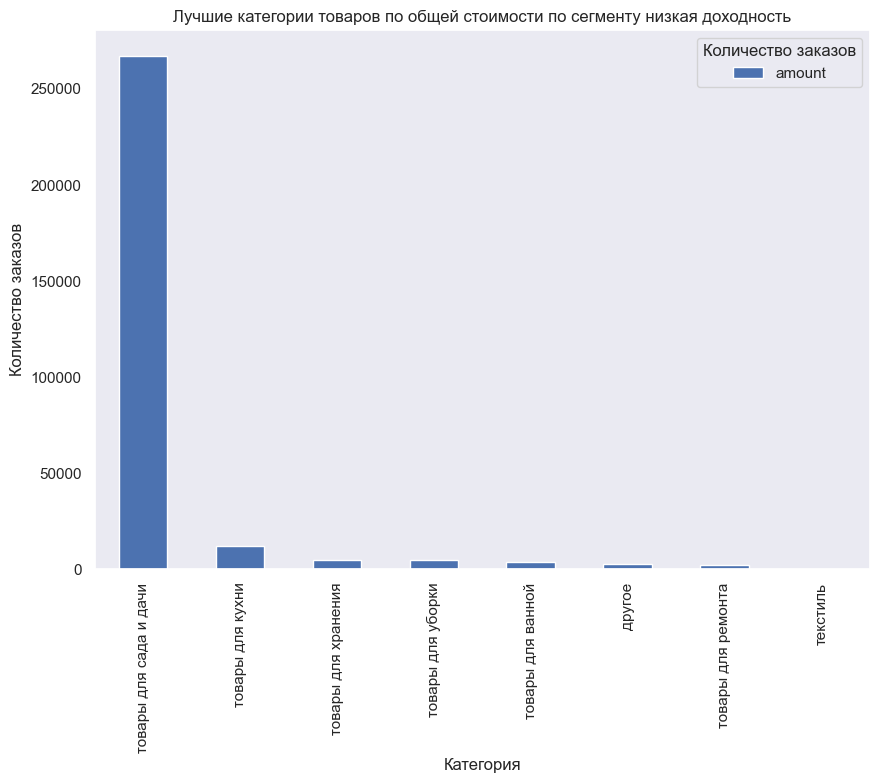

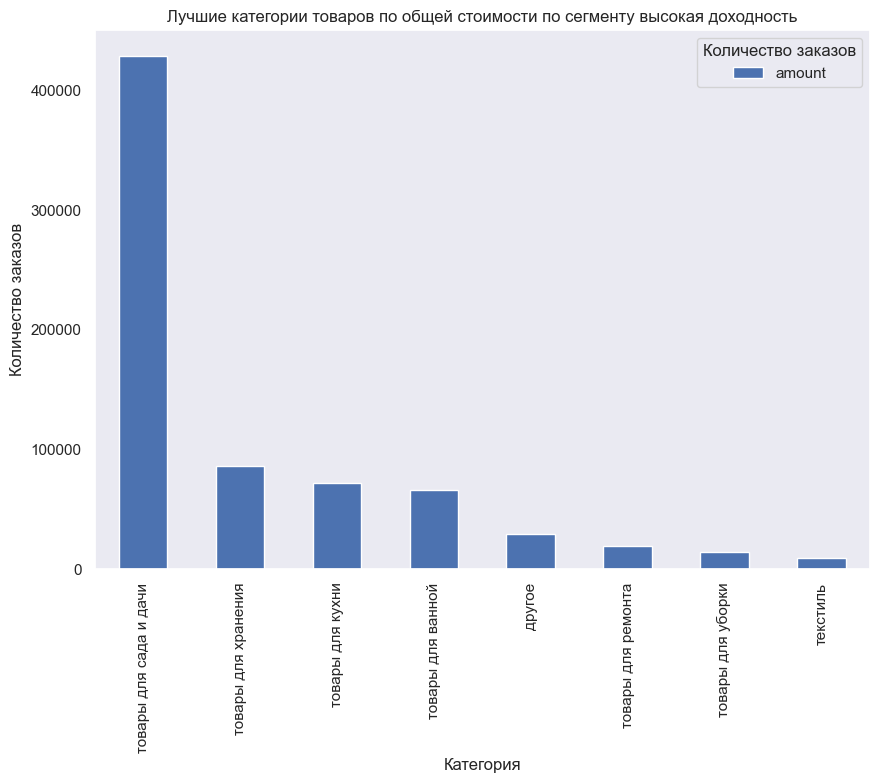

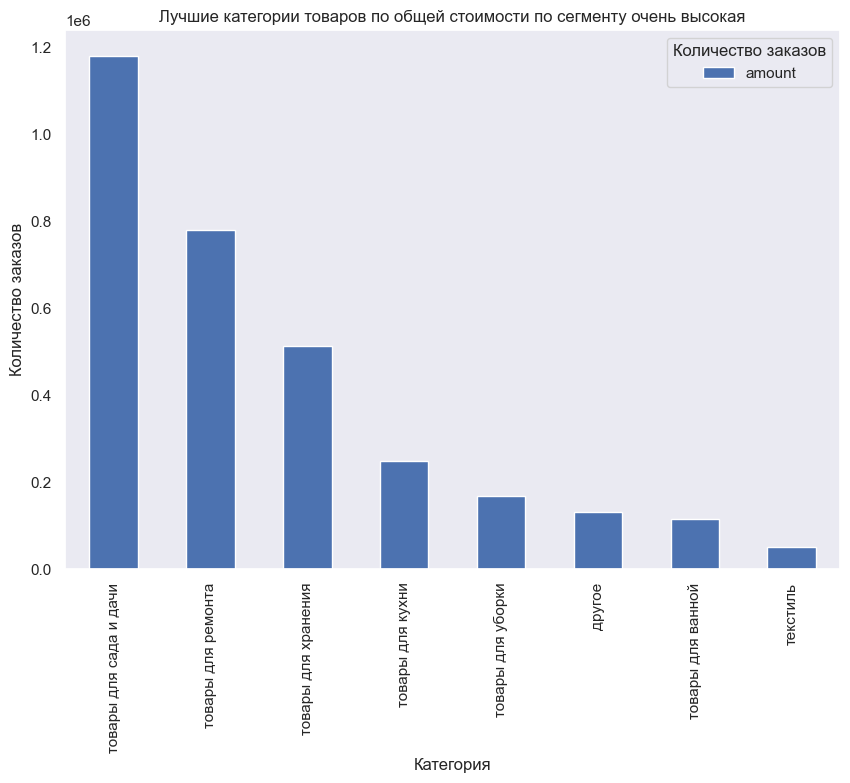

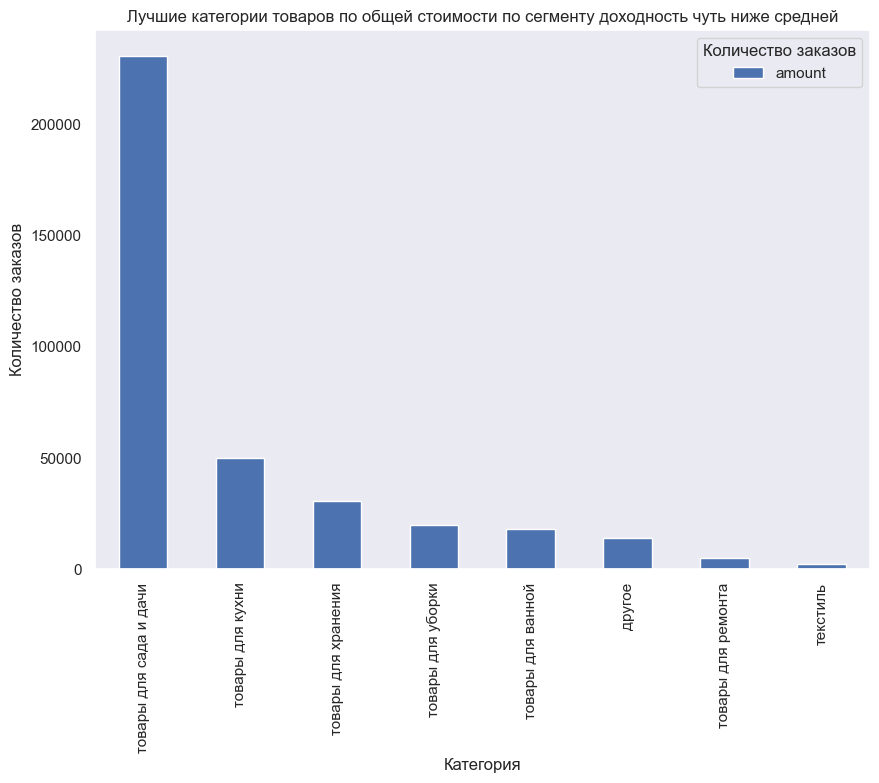

In [72]:
for row_revenue in revenue_categories:
    try:
        top_categories = online_shop.query('revenue_group == @row_revenue').pivot_table(index = 'category', values = 'amount', aggfunc = 'sum').sort_values(by = 'amount', ascending = False)
        top_categories.plot(kind = 'bar', figsize=(10, 7))
        plt.title('Лучшие категории товаров по общей стоимости по сегменту '+row_revenue)
        plt.ylabel('Количество заказов')
        plt.xlabel('Категория')
        plt.legend(title='Количество заказов')
        plt.grid()
        plt.show()
    except: print(f"Нет необходимых данных для построения графика по категории {row_revenue}")

<b>Выводы:</b>
* на основании представленной нуменклатуры товаров было осуществлено сегментирование покупателей. Была выявлена группа покупателей, имеющая ярко выраженное предпочтение в категории товарной группы;
* также было осуществлено сегментирование покупателей на 4 группы по уровню доходности на основе среднего чека заказа, а именно: низкая доходность, доходность чуть ниже средней, высокая доходность, очень высокая;
* было выявлено что у покупателей ярко выражено отдающих предпочтение категории "Товары для сада и дачи" наиболее активным месяцем является декабрь. Хорошие результаты имеются по февралю. Однако по остальным месяцам результаты либо низкие либо совсем отсутствуют. Маркетологам рекомендуется продумать рекламные и акционные способы привлечения таких покупателей в весеннее и летнее время;
* было выявлено что у покупателей ярко выражено отдающих предпочтение категории "Другое" наиболее активным месяцем является август. Хорошие результаты имеются по июню и сентябрю. По остальным месяцам результаты существенно ниже. Маркетологам особо рекомендуется продумать рекламные и акционные способы привлечения таких покупателей в мае;
* было выявлено что подавляющее количество покупателей чаще всего делают заказы из категории "Товары для сада и дачи". Возможно маркетологам стоит подумать над увеличение ассортимента по данной категории и сокращением ассортимента по другим категориям, а возможно и сокращению других товарных категорий для становления специализированного магазина для дачи и сада. Это подтвержает исследование что разовых покупателей, которые сделали заказы по другим товарным категориям сравнительно очень мало. Товары для кухни - 420 и товары для хранения - 340;
* было выявлено что покупатели с низкой доходностью в товарной категории "Дача и сад" наиболее активны в апреле и мае; 
* а вот покупатели с высокой и очень высокой доходностью в товарной категории "Дача и сад" в мае наоборот слабо активны, а стабильно активны в декабре.Это можно объяснить приобретением дорогостоящих подарков для дачи и сада к Новому Году;
* было выявлено что покупатели ярко выражено отдающие предпочтение категории "Другие" сделали заказов на самую высокую общую сумму по этой категории, чем покупатели ярко выражено отдающие предпочтение другим категориям товаров; 
* что касается покупателей не отдающих ярко выраженного предпочтения какой-либо товарной категории, то здесь уверенное первое место по общей выручки занимает товарная категория "Товары для сада и дачи".

<h2>Проверка статистических гипотез</h2>

Выше мы выяснили что имеет место примерно одинаковая общая выручка за проданные товары в категориях "Товары для ремонта" и "Товары для хранения". Узнаем есть ли различия в средней чеке между покупателями, сделавшими покупки только в данных категориях и больше не в каких.

In [73]:
tools_and_storage = online_shop.groupby('customer_id').agg({'category': 'nunique'})

In [74]:
tools_and_storage = tools_and_storage.query('category == 1')

In [75]:
tools_and_storage = tools_and_storage.set_axis(tools_and_storage.columns.tolist(), axis=1).reset_index()

In [76]:
customers_tools_and_storage = list(tools_and_storage['customer_id'])

In [77]:
tools_storage_customers = online_shop.query('category == "товары для ремонта" or category == "товары для хранения" and customer_id in @customers_tools_and_storage')

Теперь создадим сгруппированный датасет:

In [78]:
group_customers = tools_storage_customers.groupby(['customer_id', 'date', 'category','quantity'])['amount'].sum().reset_index()
group_customers = group_customers.sort_values(by = 'date', ascending = True)

Разделим покупателей по группам. 

In [79]:
group_a=group_customers.query('category == "товары для ремонта"')
group_b=group_customers.query('category == "товары для хранения"')

Проверим есть ли покупатели попавшие в обе группы

In [80]:
group_intersections=list(np.intersect1d(group_a['customer_id'], group_b['customer_id']))
len(group_intersections)

0

Создаем массив уникальных пар значений дат и групп теста

In [81]:
datesGroups = group_customers[['date', 'category']].drop_duplicates().reset_index(drop=True)

Получаем агрегированные кумулятивные по дням данные о заказах

In [82]:
ordersAggregated = (datesGroups
                    .apply(lambda x: group_customers[np.logical_and(group_customers['date'] <= x['date'],
                                                           group_customers['category'] == x['category'])]
                           .agg({'date' : 'max', 'category' : 'max', 'amount' : 'sum', 'quantity': 'sum'}), axis=1)
                    .sort_values(by=['date','category'])
                    .reset_index(drop=True))
ordersAggregated.columns = ['date', 'category', 'amount', 'quantity']

Построим график кумулятивной выручки

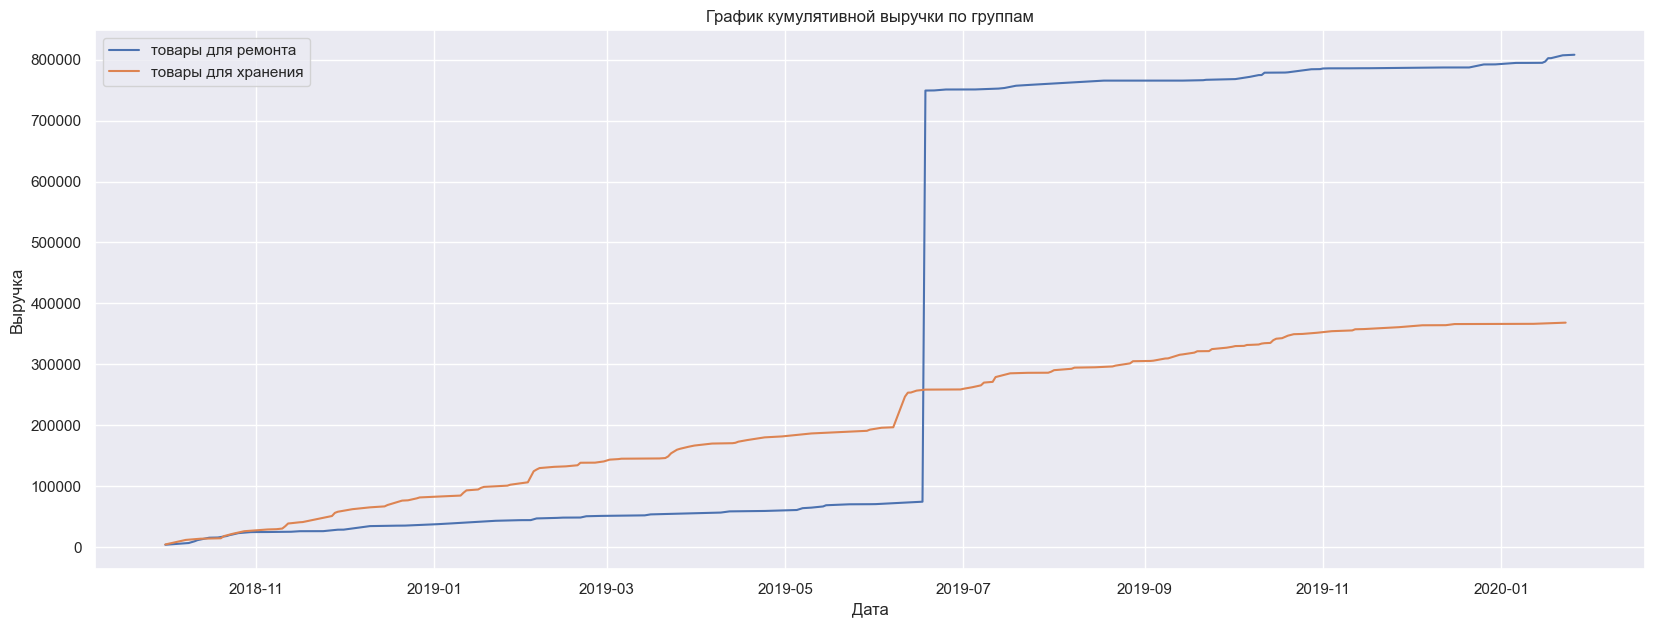

In [83]:
sns.set(font_scale=1, rc={'figure.figsize':(20,7)})
cumulativeRevenueA = ordersAggregated[ordersAggregated['category']=="товары для ремонта"][['date','amount']]
cumulativeRevenueB = ordersAggregated[ordersAggregated['category']=="товары для хранения"][['date','amount']]
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['amount'], label='товары для ремонта')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['amount'], label='товары для хранения')
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend();

Видим что в в конце июня 2019 года выручка от покупателей, которые покупают товары только в категории "Товары для ремонта" резко взлетела по сравнению с категорией "Товары для хранения"

Для того, чтобы изучить динамику среднего чека по заявленным двум группам, необходимо разделить кумулятивную выручку на кумулятивное количество.

In [84]:
ordersAggregated['avg_price'] = ordersAggregated['amount'] / ordersAggregated['quantity']

Построим график кумулятивного среднего чека

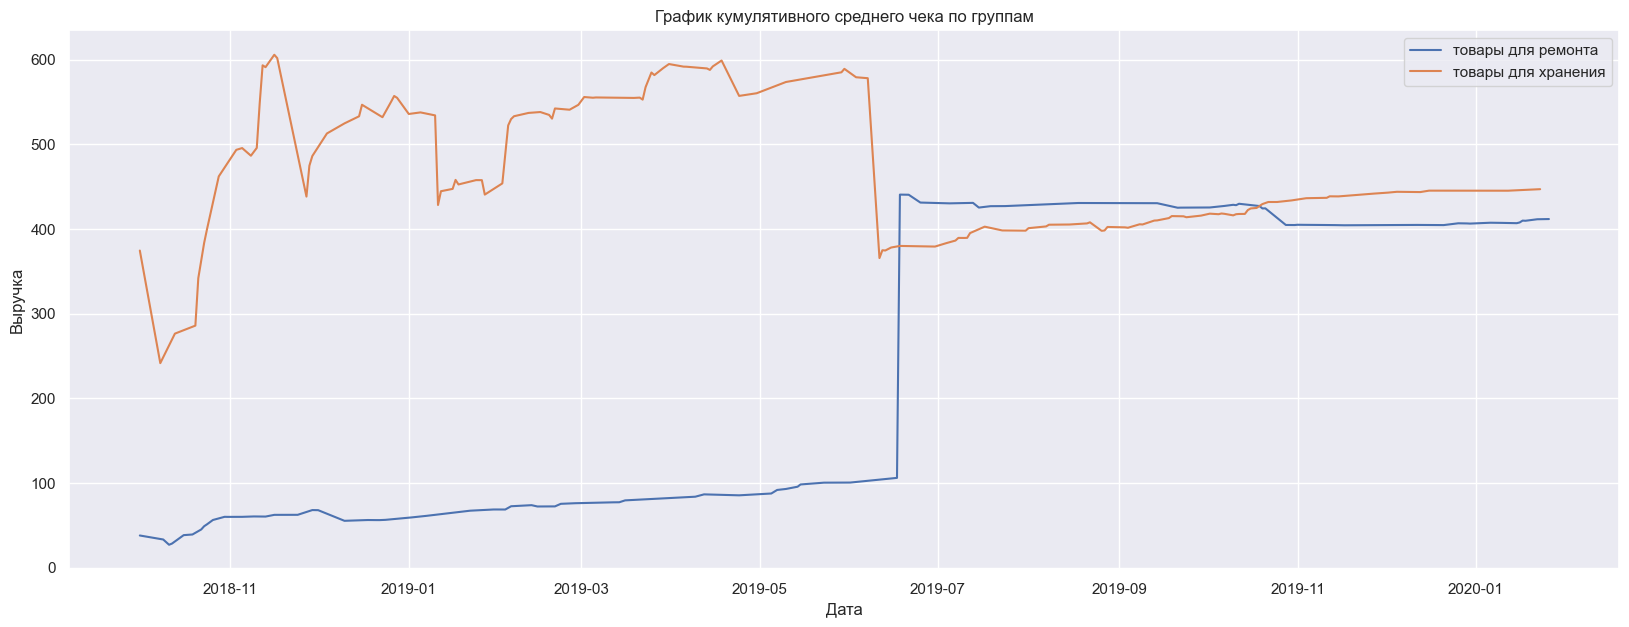

In [85]:
sns.set(font_scale=1, rc={'figure.figsize':(20,7)})
cumulativeRevenueA = ordersAggregated[ordersAggregated['category']=="товары для ремонта"][['date','avg_price']]
cumulativeRevenueB = ordersAggregated[ordersAggregated['category']=="товары для хранения"][['date','avg_price']]
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['avg_price'], label='товары для ремонта')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['avg_price'], label='товары для хранения')
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend();

Построим гипотезу H0: Для товаров в категории "товары для ремонта" и "товары для хранения", попадающих в покупки клиентов, средний чек не отличается. Тогда гипотеза H1: Между показателями наблюдаются существенные различия.

Чтобы рассчитать статистическую значимость различий в среднем чеке между сегментами, применим критерий Манна-Уитни. И рассчитаем относительные различия между различными группами доходности в рамках обозначенных двух товарных категорий.

In [86]:
def test_values(df):
    
   # Расчитаем p-value
    extra_high_pvalue = st.mannwhitneyu(df.query('category == "товары для ремонта"')['avg_price'],
                                        df.query('category == "товары для хранения"')['avg_price'])[1]
    
    # Расчитаем относительный прирост среднего чека
    extra_high_delta = (df.query('category == "товары для ремонта"')['avg_price'].mean() /
                        df.query('category == "товары для хранения"')['avg_price'].mean()) - 1
    
     # Построение сводной таблицы с показателями попарных тестов
    test_values = pd.DataFrame({'groups_tested': ['товары для ремонта и товары для хранения'],
                                'p-value': [extra_high_pvalue],
                                'delta': [extra_high_delta]})
    test_values[['p-value', 'delta']] = round(test_values[['p-value', 'delta']], 5)
    test_values = test_values.set_index('groups_tested')
    return test_values

In [87]:
test_values(ordersAggregated)

,p-value,delta
groups_tested,,
товары для ремонта и товары для хранения,0.0,-0.5286


Значение p-value для среднего чека в категориях "товары для ремонта" и "товары для хранения". Мы можем отвергнуть нулевую гипотезу и считать, что в среднем чеке категории этих двух категорий есть различия.

Также мы выяснили что 2-ое и 3-ее место по общему количеству проданных товаров заняли товары в категориях "Товары для ремонта" и "Товары для кухни". Узнаем есть ли различия в среднем чеке между покупателями, сделавшими покупки только в данных категориях и больше не в каких.

In [88]:
tools_and_kitchen = online_shop.groupby('customer_id').agg({'category': 'nunique'})
tools_and_kitchen = tools_and_kitchen.query('category == 1')
tools_and_kitchen = tools_and_kitchen.set_axis(tools_and_kitchen.columns.tolist(), axis=1).reset_index()
customers_tools_and_kitchen = list(tools_and_kitchen['customer_id'])
tools_kitchen_customers = online_shop.query('category == "товары для ремонта" or category == "товары для кухни" and customer_id in @customers_tools_and_kitchen')

Теперь создадим сгруппированный датасет:

In [89]:
group_customers = tools_kitchen_customers.groupby(['customer_id', 'date', 'category','quantity'])['amount'].sum().reset_index()
group_customers = group_customers.sort_values(by = 'date', ascending = True)

Разделим покупателей по группам. 

In [90]:
group_a=group_customers.query('category == "товары для ремонта"')
group_b=group_customers.query('category == "товары для кухни"')

Проверим есть ли покупатели попавшие в обе группы

In [91]:
group_intersections=list(np.intersect1d(group_a['customer_id'], group_b['customer_id']))
len(group_intersections)

0

Создаем массив уникальных пар значений дат и групп теста

In [92]:
datesGroups = group_customers[['date', 'category']].drop_duplicates().reset_index(drop=True)

Получаем агрегированные кумулятивные по дням данные о заказах

In [93]:
ordersAggregated = (datesGroups
                    .apply(lambda x: group_customers[np.logical_and(group_customers['date'] <= x['date'],
                                                           group_customers['category'] == x['category'])]
                           .agg({'date' : 'max', 'category' : 'max', 'amount' : 'sum', 'quantity': 'sum'}), axis=1)
                    .sort_values(by=['date','category'])
                    .reset_index(drop=True))
ordersAggregated.columns = ['date', 'category', 'amount', 'quantity']

Построим график кумулятивной выручки

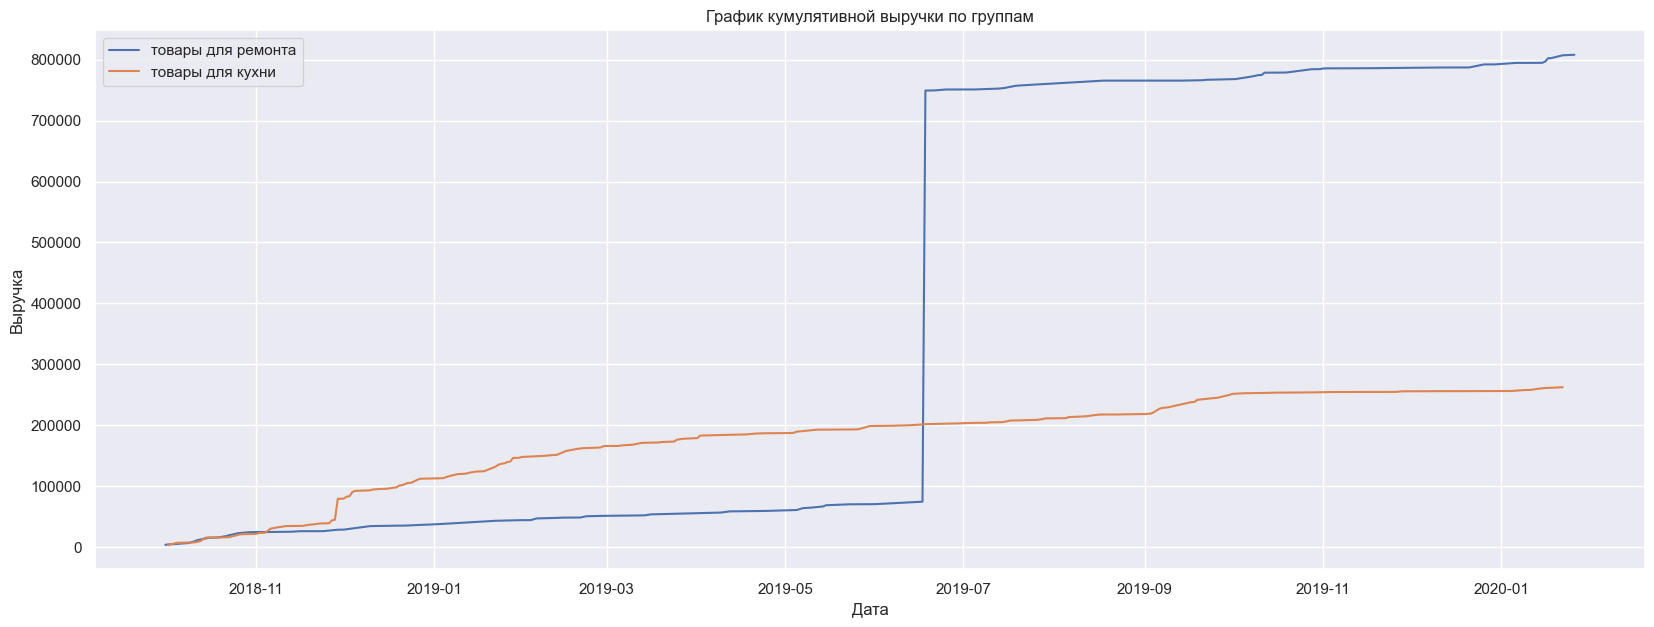

In [94]:
sns.set(font_scale=1, rc={'figure.figsize':(20,7)})
cumulativeRevenueA = ordersAggregated[ordersAggregated['category']=="товары для ремонта"][['date','amount']]
cumulativeRevenueB = ordersAggregated[ordersAggregated['category']=="товары для кухни"][['date','amount']]
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['amount'], label='товары для ремонта')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['amount'], label='товары для кухни')
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend();

Для того, чтобы изучить динамику среднего чека по заявленным двум группам, необходимо разделить кумулятивную выручку на кумулятивное количество.

In [95]:
ordersAggregated['avg_price'] = ordersAggregated['amount'] / ordersAggregated['quantity']

Построим график кумулятивного среднего чека

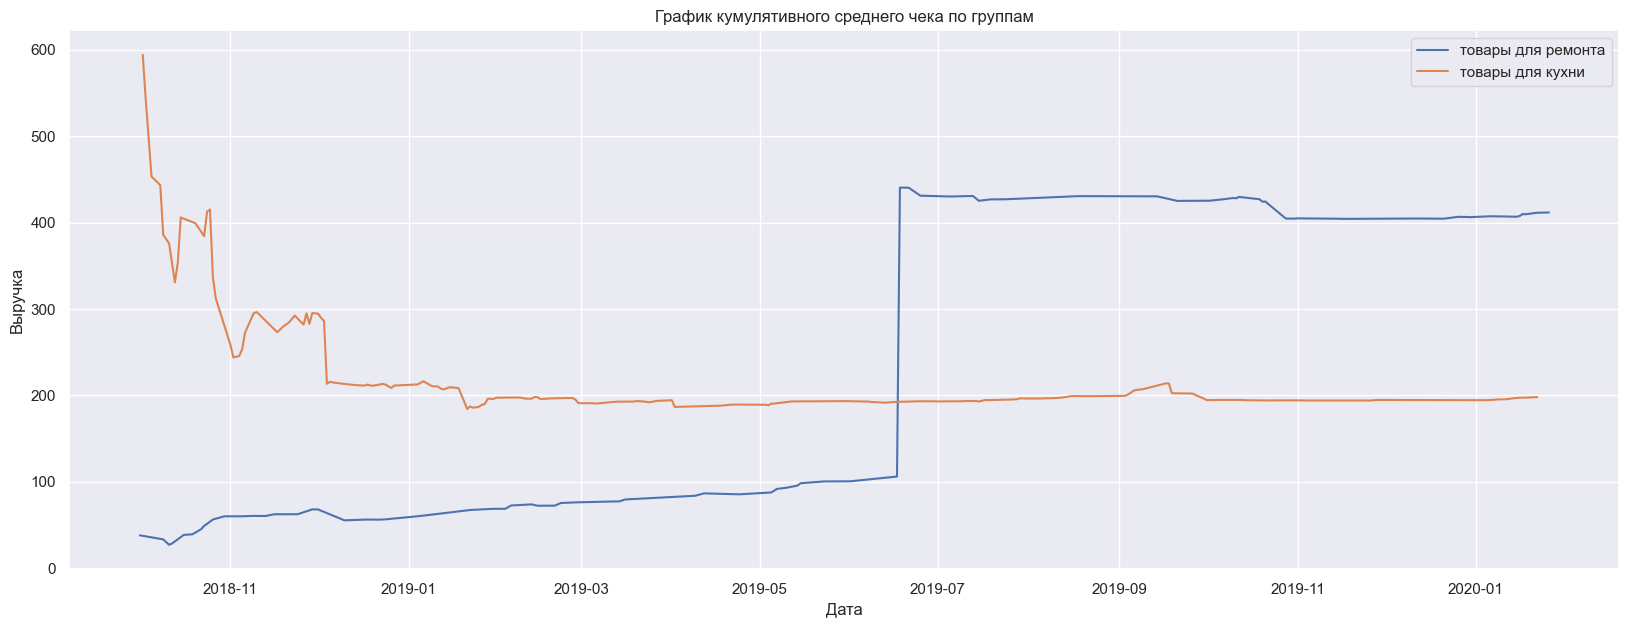

In [96]:
sns.set(font_scale=1, rc={'figure.figsize':(20,7)})
cumulativeRevenueA = ordersAggregated[ordersAggregated['category']=="товары для ремонта"][['date','avg_price']]
cumulativeRevenueB = ordersAggregated[ordersAggregated['category']=="товары для кухни"][['date','avg_price']]
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['avg_price'], label='товары для ремонта')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['avg_price'], label='товары для кухни')
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend();

Построим гипотезу H0: Для товаров в категории "товары для ремонта" и "товары для кухни", попадающих в покупки клиентов, средний чек не отличается. Тогда гипотеза H1: Между показателями наблюдаются существенные различия.

Чтобы рассчитать статистическую значимость различий в среднем чеке между сегментами, применим критерий Манна-Уитни. И рассчитаем относительные различия между различными группами доходности в рамках обозначенных двух товарных категорий.

In [97]:
def test_values(df):
    
   # Расчитаем p-value
    extra_high_pvalue = st.mannwhitneyu(df.query('category == "товары для ремонта"')['avg_price'],
                                        df.query('category == "товары для кухни"')['avg_price'])[1]
    
    # Расчитаем относительный прирост среднего чека
    extra_high_delta = (df.query('category == "товары для ремонта"')['avg_price'].mean() /
                        df.query('category == "товары для кухни"')['avg_price'].mean()) - 1
    
     # Построение сводной таблицы с показателями попарных тестов
    test_values = pd.DataFrame({'groups_tested': ['товары для ремонта и товары для кухни'],
                                'p-value': [extra_high_pvalue],
                                'delta': [extra_high_delta]})
    test_values[['p-value', 'delta']] = round(test_values[['p-value', 'delta']], 5)
    test_values = test_values.set_index('groups_tested')
    return test_values

In [98]:
test_values(ordersAggregated)

,p-value,delta
groups_tested,,
товары для ремонта и товары для кухни,0.03585,-0.02359


Значение p-value для среднего чека в категориях "товары для ремонта" и "товары для хранения". Мы можем отвергнуть нулевую гипотезу и считать, что в среднем чеке категории этих двух категорий есть различия.

<h2>Общие выводы</h2>

Были проанализированы данные о 7476 транзакциях в интернет-магазине товаров для дома и быта «Пока все ещё тут» с информацией о дате заказа, идентификаторе покупателя и заказе, наименовании купленного товара, количестве товара в заказе и его цене.

Данные предоставлены за период с 1 октября 2018 года по 31 января 2020.

Исследовательский анализ данных показал:
* на основании представленной нуменклатуры товаров было осуществлено категорирование товарной группы. За образец был взят пример категорирования товарной группы крупнейших сетей строительных гипермаркетов. В результате было выделено 8 категорий: товары для сада и дачи, товары для кухни, товары для ванной, товары для уборки, товары для ремонта, товары для хранения, текстиль, а также категория "другое";
* после анализа суммарной выручки по категориям товаров замечено что наибольшую выручку за рассматриваемый период дали товары из категории "Товары для сада и дачи", затем идут товары из категории "Товары для ремонта" и затем "Товары для хранения". Наименьшую выручку принесли товары из категории "Текстиль";
* после анализа суммарного количества проданных товаров по категориям товаров за рассматриваемый период наибольшее количество проданных товаров из категории "Товары для сада и дачи", на втором и третьем месте во сравнимыми показателями расположились товары из категорий "Товары для ремонта" и "Товары для кухни". Наименьшее количество проданных товаров из категории "Текстиль";
* было выявлено что повторную покупку совершают только чуть более половины покупателей. Третью покупку совершает лишь небольшое число покупателей. Рекомендуется подумать над улучшением сервиса как технического так и клиентского;
* можно сделать вывод что декабрь является стабильно сезонным месяцем. Высокие данные по обоим годам это подтверждают. Это в первую очередь связано подготовкой к Новому Году и большим количеством заказов в связи с этим. Высокий результат по заказам в феврале 2019 года. Несмотря на то что мы располагаем данными только за один год февраль вполне можно назвать сезонным месяцем поскольку в этом месяц совершаются заказы к 23 февраля и 8 марта;
* что касается недельного пика загруженности заказами, то здесь наблюдается значительное уменьшение количества заказов в пятницу. В субботу количество заказов достигает наименьшего значения и в воскресенье заметен подъём. Отделу маркетинга рекомендуется подумать над составлением клиенских программ и акций для пятницы-субботы.

Было выявлено что больше половины покупателей, а именно 59% приобретали товары в категории "Дача и сад", 12% - в категории "Товары для кухни", 10% - в категории "Товары для хранения". Наименьшее количество (1%) покупателей приобретали товары в категории "Текстиль".

Средний чек - 509 рублей.

Сегментацию решено было провести по следующим параметрам:

Сегментация по товарным категориям:
* покупателей, имеющих любимую категорию, т. е. делавших заказы категории товаров абслютно большее количество раз;
* остальльных покупателей.

Сегментация по уровню доходности. Уровень доходности был рассчитан на основе среднего статистической выборки чеков покупателей.
* низкая доходность;
* доходность чуть ниже средней;
* высокая доходность;
* очень высокая.

Было выявлено что наиболее сезонным месяцем для покупателей, имеющих любимую категорию "Товары для сада и дачи" является декабрь. Он лидирует с большим отрывом. Это напрямую связано с приближающимися новогодними праздниками. По категории "Другое" наиболее сезонным месяцем для покупателей, чаще всего формирующих заказы в этой категории является август. По остальным категориям данные для анализа отсутствуют.

Видим что для широкой массы покупателей:

- в категории "товары для уборки" наиболее сезонными месяцами являются ноябрь и октябрь;
- в категории "товары для хранения" - февраль;
- в категории "товары для ремонта" - декабрь;
- в категории "товары для кухни" - октябрь, ноябрь, декабрь;
- в категории "товары для ванной" - декабрь;
- в категории "другое" - декабрь.

Для обоих сегментов покупателей по товарным категориям лучшей категорией товаров по числу заказов является категория "Товары для дачи". Та же самая ситуация по сегментам покупателей с уровнем доходности.

Вместе с тем установлено что покупатели, имеющие ярко выраженную любимую категория, наибольщую выручку сделали не в товарной категории "Товары для сада и дачи", а в товарной категории "Другое". Это товарная категория, включающая в себя товары одинаково применимые и для дачи и для повседневных домашних нужд. Рекомендовано нарастить ассортимент данной категории товаров.

В целом установлено что товарная категория "Товары для сада и дачи" для магазина является преобладающей. Рекомендовано сосредоточиться ассортимент по данной категории, а также по категории "Другое".